In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import matplotlib.tri as tri
from scipy import stats
from scipy.optimize import minimize
from scipy.special import softmax
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Polygon, Ellipse
from matplotlib.collections import EllipseCollection
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

# **PART A**

## **Part A.1**: Bernoulli with Beta Prior

In [2]:
class BernoulliBetaPrior:
    """ 
    Parameter estimation (theta) for Bernoulli with Beta prior
    Beta prior assumes theta ~ Beta(alpha_0, beta_0)
    """
    def __init__(self, alpha_prior = 1, beta_prior = 1):
        self.alpha_prior = alpha_prior
        self.beta_prior = beta_prior
        self.data = None
        self.alpha_post = None          # posterior parameter alpha_n
        self.beta_post= None            # posterior parameter beta_n
        
        
    def generate_data(self, n_samples, true_theta):
        """
        Generate binary data from Bernoulli distribution
        true_theta: ground truth success probability
        """
        self.true_theta = true_theta
        self.data = np.random.binomial(1, true_theta, n_samples)    # single trial, with true_theta success probability, do for n_samples number of times
        
        
        return self.data
    
    def update_posterior(self, data = None):
        if data is not None:
            self.data = data
        if self.data is None:
            raise ValueError("No data provied for posterior update")
        
        N = len(self.data)              # number of observations
        sum_y = np.sum(self.data)       # total number of successes
        
        # update the posterior parameters
        self.alpha_post = self.alpha_prior + sum_y
        self.beta_post = self.beta_prior + N - sum_y
        
    def compute_estimates(self):
        """
        Compute MLE, MAP, and Posterior Mean Estimates
        """
        if self.data is None:
            raise ValueError("No data available for estimation")
        
        N = len(self.data)
        sum_y = np.sum(self.data)

        mle_ = sum_y / N if N > 0 else 0        # directly from the formula for MLE
        if self.alpha_post > 1 and self.beta_post > 1:
            # mode of Beta(a, b) = (a - 1) / (a + b - 2) when a, b > 1
            map_ = (self.alpha_post - 1) / (self.alpha_post + self.beta_post - 2)
        else:
            # if mode is undefined, estimate MAP to posterior mean
            map_ = self.alpha_post / (self.alpha_post + self.beta_post)

        # E[theta | Data] -> bayesian point estimate (posterior mean)
        posterior_mean = self.alpha_post / (self.alpha_post + self.beta_post)
        
        return{
            'MLE': mle_,
            'MAP': map_,
            'Posterior Mean': posterior_mean,
            'True Theta': getattr(self, 'true_theta', None)
        }
        
    def plot_distributions(self, title_suffix = ""):
        """
        Prior ~ Beta(alpha_prior, beta_prior)
        Likelihood ~ Bernoulli(data | theta)
        Posterior ~ Beta(alpha_post, beta_post)
        Point estimates ~ (MLE, MAP, Posterior Mean)
        """
        theta_range = np.linspace(0, 1, 1000)
        prior_pdf = stats.beta.pdf(theta_range, self.alpha_prior, self.beta_prior)
        
        if self.data is not None:
            N = len(self.data)
            sum_y = np.sum(self.data)
            likelihood = theta_range ** sum_y * (1 - theta_range) ** (N - sum_y)
            likelihood = likelihood / np.max(likelihood) * np.max(prior_pdf)
        else:
            likelihood = np.ones_like(theta_range)
            
        if self.alpha_post is not None and self.beta_post is not None:
            posterior_pdf = stats.beta.pdf(theta_range, self.alpha_post, self.beta_post)
        else:
            posterior_pdf = prior_pdf
            
        plt.figure(figsize=(12, 6))
        plt.plot(theta_range, prior_pdf, 'b-', linewidth=2, 
                label=f'Prior: Beta({self.alpha_prior}, {self.beta_prior})')
        if self.data is not None:
            plt.plot(theta_range, likelihood, 'r--', linewidth=2, 
                    label=f'Likelihood (n = {len(self.data)})')
        if self.alpha_post is not None:
            plt.plot(theta_range, posterior_pdf, 'g-', linewidth=3, 
                    label=f'Posterior: Beta({self.alpha_post}, {self.beta_post})')
            
        if self.data is not None:
            estimates = self.compute_estimates()
            plt.axvline(estimates['MLE'], color='orange', linestyle=':', linewidth=2, 
                       label=f"MLE = {estimates['MLE']:.3f}")
            plt.axvline(estimates['MAP'], color='purple', linestyle=':', linewidth=2, 
                       label=f"MAP = {estimates['MAP']:.3f}")
            plt.axvline(estimates['Posterior Mean'], color='brown', linestyle=':', linewidth=2, 
                       label=f"Post. Mean = {estimates['Posterior Mean']:.3f}")
            
            if estimates['True Theta'] is not None:
                plt.axvline(estimates['True Theta'], color='black', linestyle='-', linewidth=2, 
                           label=f"True Theta = {estimates['True Theta']:.3f}")

        plt.xlabel('Theta (Success Probability)')
        plt.ylabel('Density')
        plt.title(f'Bayesian Parameter Estimation - Bernoulli with Beta Prior {title_suffix}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

In [3]:
def bayesian_updation():
    true_theta = 0.8
    data_sizes = [5, 50, 500]
    
    # Different prior beliefs to compare
    priors = [
        (1, 1, "Uninformative (Uniform)"),      # Flat prior: no preference
        (2, 2, "Weakly Informative"),           # Slight preference for theta = 0.5  
        (7, 3, "Informative (favor success)"),  # Strong belief in high theta
        (3, 7, "Informative (favor failure)")   # Strong belief in low theta
    ]
    
    print(f"True Theta: {true_theta}\n")
    
    max_samples = max(data_sizes)
    np.random.seed(13)
    full_data = np.random.binomial(1, true_theta, max_samples)
    
    print("Updating Bayesian\n")
    
    results_summary = []
    
    for alpha, beta, prior_name in priors:
        print(f"\n{prior_name} Prior: Beta({alpha}, {beta})")
        print("-" * 40)
        
        estimator = BernoulliBetaPrior(alpha, beta)
        
        # convergence with increasing sample size
        for n in data_sizes:
            data_subset = full_data[:n]
            estimator.generate_data(n, true_theta)
            estimator.data = data_subset
            estimator.update_posterior()
            
            estimates = estimator.compute_estimates()
            
            print(f"n={n:3d}: MLE={estimates['MLE']:.3f}, "
                  f"MAP={estimates['MAP']:.3f}, "
                  f"Post.Mean={estimates['Posterior Mean']:.3f}")
            
            results_summary.append({
                'Prior': prior_name,
                'n': n,
                'MLE': estimates['MLE'],
                'MAP': estimates['MAP'],
                'Posterior Mean': estimates['Posterior Mean']
            })
        
        estimator.data = full_data[:max(data_sizes)]
        estimator.update_posterior()
        estimator.plot_distributions(f"- {prior_name}")
        
    return results_summary

True Theta: 0.8

Updating Bayesian


Uninformative (Uniform) Prior: Beta(1, 1)
----------------------------------------
n=  5: MLE=0.400, MAP=0.400, Post.Mean=0.429
n= 50: MLE=0.800, MAP=0.800, Post.Mean=0.788
n=500: MLE=0.794, MAP=0.794, Post.Mean=0.793


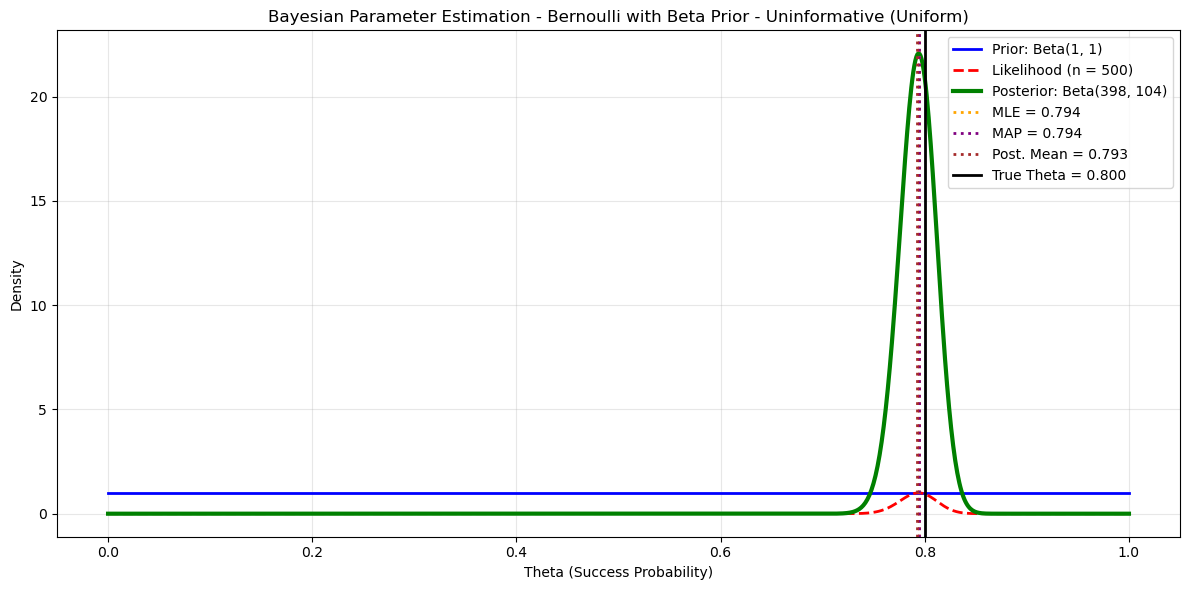


Weakly Informative Prior: Beta(2, 2)
----------------------------------------
n=  5: MLE=0.400, MAP=0.429, Post.Mean=0.444
n= 50: MLE=0.800, MAP=0.788, Post.Mean=0.778
n=500: MLE=0.794, MAP=0.793, Post.Mean=0.792


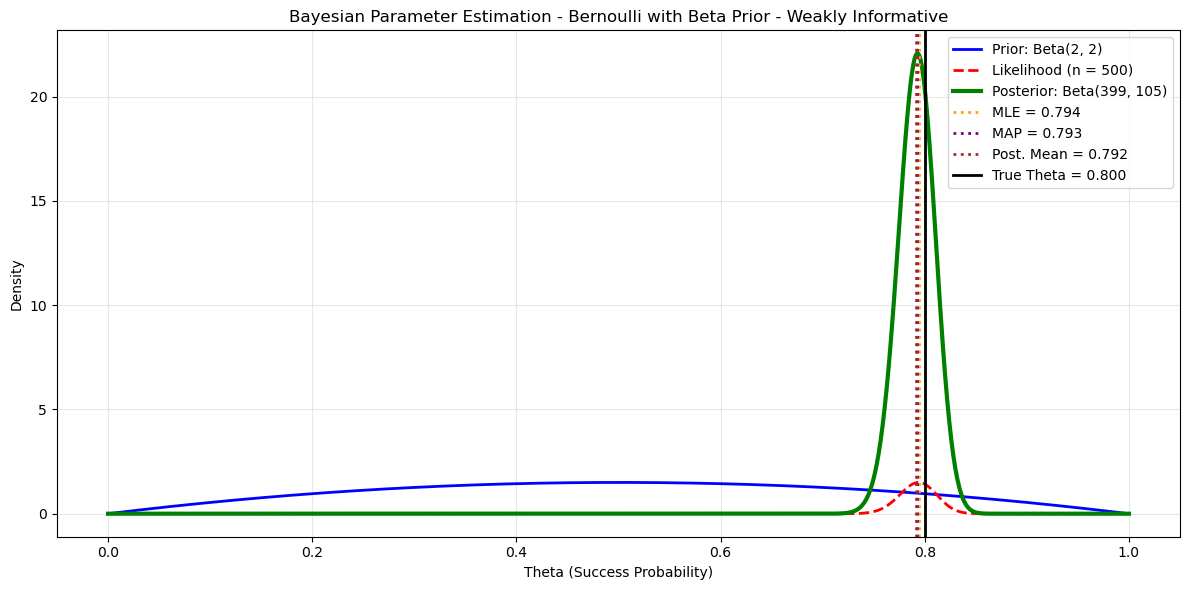


Informative (favor success) Prior: Beta(7, 3)
----------------------------------------
n=  5: MLE=0.400, MAP=0.615, Post.Mean=0.600
n= 50: MLE=0.800, MAP=0.793, Post.Mean=0.783
n=500: MLE=0.794, MAP=0.793, Post.Mean=0.792


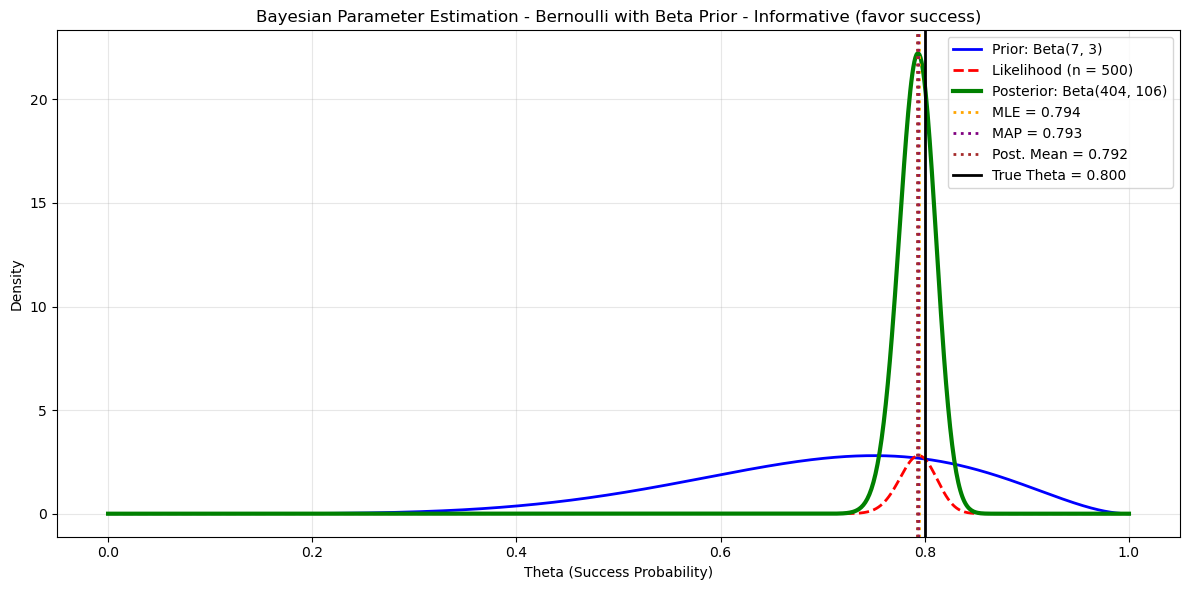


Informative (favor failure) Prior: Beta(3, 7)
----------------------------------------
n=  5: MLE=0.400, MAP=0.308, Post.Mean=0.333
n= 50: MLE=0.800, MAP=0.724, Post.Mean=0.717
n=500: MLE=0.794, MAP=0.785, Post.Mean=0.784


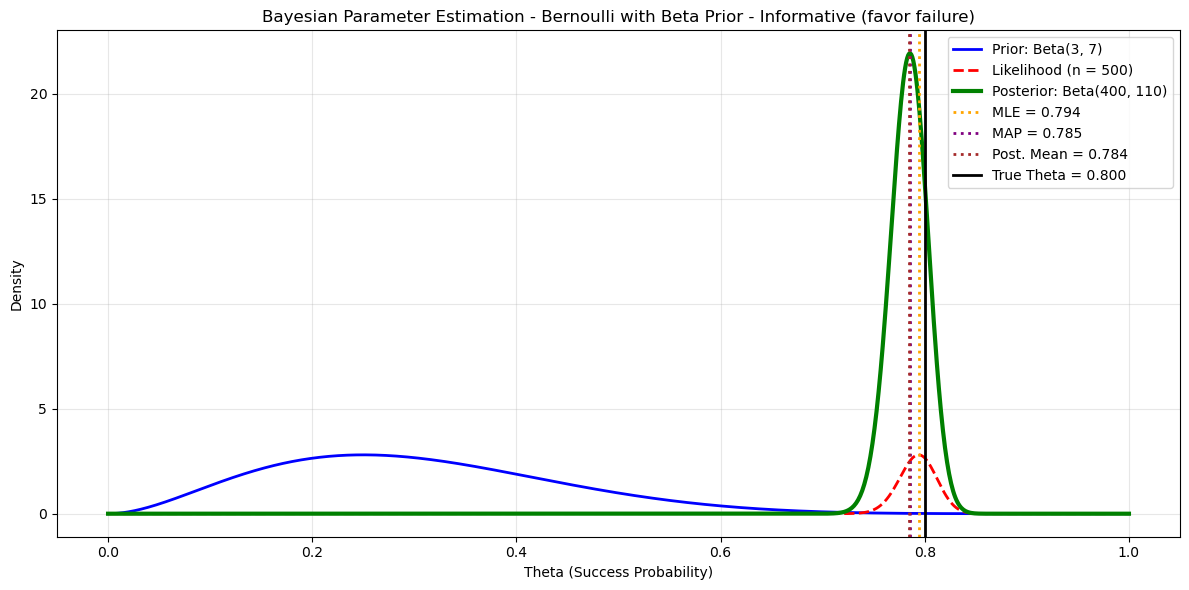

In [4]:
if __name__ == "__main__":
    results = bayesian_updation()

## **Part A.2**: Multinomial with Dirichlet Prior

In [5]:
class MultinomialDirichletPrior:
    """
    Parameter estimation (theta_i's) for Multinomial with Dirichlet prior
    Dirichlet prior assumes theta ~ Dirichlet(alpha_0, alpha_1, ..., alpha_K)
    """
    def __init__(self, alpha_prior = None, K = 3):
        self.K = K                      # number of categories
        if alpha_prior is None:
            self.alpha_prior = np.ones(K)
        else:
            self.alpha_prior = np.array(alpha_prior)

        self.data = None                # observed data
        self.counts = None              # category counts
        self.alpha_post = None          # posterior parameters
        
    def generate_data(self, n_samples, true_probs):
        """
        Generate data from ground truth
        true_probs : true probabilities for each category [theta_1, ... , theta_k]
        """
        self.true_probs = np.array(true_probs)
        
        self.data = np.random.choice(self.K, size = n_samples, p = self.true_probs)
        # count occurences for each category
        self.counts = np.bincount(self.data, minlength = self.K)
        
        return self.data, self.counts
    
    def update_posterior(self, counts = None):
        if counts is not None:
            self.counts = counts
        if self.counts is None:
            raise ValueError("No data provided for posterior update")

        # alpha_post_i = alpha_prior_i + count_i
        self.alpha_post = self.alpha_prior + self.counts
        
    def compute_estimates(self):
        """
        Compute MLE, MAP, and Posterior Mean Estimates
        """
        if self.counts is None:
            raise ValueError("No counts available for estimation")
        
        N = np.sum(self.counts)          # total number of observations
        
        mle_ = self.counts / N if N > 0 else np.zeros(self.K)  

        posterior_mean = self.alpha_post / np.sum(self.alpha_post)
        
        if np.all(self.alpha_post > 1):
            map_ = (self.alpha_post - 1) / (np.sum(self.alpha_post) - self.K)
        else:
            map_ = posterior_mean.copy()
        
        return {
            'MLE': mle_,
            'MAP': map_,
            'Posterior Mean': posterior_mean,
            'True Probs': getattr(self, 'true_probs', None)
        }
        
    def sample_posterior(self, n_samples = 1000):
        """
        Sample examples from the posterior Dirichlet distribution
        """
        if self.alpha_post is None:
            raise ValueError("Posterior parameters not computed yet")
        
        return stats.dirichlet.rvs(self.alpha_post, size = n_samples)
    
    def posterior_predictive(self, n_new = 1):
        if self.alpha_post is None:
            raise ValueError("Posterior parameters not computed yet")

        # posterior predictive mean: E[theta | data] = alpha_post / sum (alpha_i)
        pred_probs = self.alpha_post / np.sum(self.alpha_post)
        
        # Monte Carlo approximation of posterior predcitive distribution
        posterior_samples = self.sample_posterior(1000)
        predictive_samples = []
        
        for theta in posterior_samples:
            new_data = np.random.multinomial(n_new, theta)
            predictive_samples.append(new_data)
            
        return pred_probs, np.array(predictive_samples)
    


In [6]:
def plot_dirichlet_2d(alpha_values, title, estimates = None, true_probs = None):
    fig, ax = plt.subplots(1, 1, figsize = (10, 8))
    vertices = np.array([[0, 0], [1, 0], [0.5, np.sqrt(3)/2]]) # class_0, class_1, class_2
    
    triangle = Polygon(vertices, fill = False, edgecolor = 'black', linewidth = 2)
    ax.add_patch(triangle)
    
    n_points = 100
    x = np.linspace(0, 1, n_points)
    y = np.linspace(0, 1, n_points)
    X, Y = np.meshgrid(x, y)
    pdf_values = np.zeros_like(X)
    
    for i in range(n_points):
        for j in range(n_points):
            cart_point = np.array([X[i, j], Y[i, j]])
            
            v0 = vertices[2] - vertices[0]
            v1 = vertices[1] - vertices[0]
            v2 = cart_point - vertices[0]
            
            dot00 = np.dot(v0, v0)
            dot01 = np.dot(v0, v1)
            dot02 = np.dot(v0, v2)
            dot11 = np.dot(v1, v1)
            dot12 = np.dot(v1, v2)

            inv_denom = 1 / (dot00 * dot11 - dot01 * dot01)
            u = (dot11 * dot02 - dot01 * dot12) * inv_denom
            v = (dot00 * dot12 - dot01 * dot02) * inv_denom

            if u >= 0 and v >= 0 and (u + v) <= 1:
                w1 = 1 - u - v
                w2 = v
                w3 = u
                if w1 >= 0 and w2 >= 0 and w3 >= 0 and abs(w1 + w2 + w3 - 1) < 1e-10:
                    probs = np.array([w1, w2, w3])
                    if np.all(probs > 0):
                        pdf_values[i,j] = stats.dirichlet.pdf(probs, alpha_values)
    
    pdf_values[pdf_values == 0] = np.nan
    
    contour = ax.contour(X, Y, pdf_values, levels=10, colors='blue', alpha=0.6)
    contourf = ax.contourf(X, Y, pdf_values, levels=20, cmap='Blues', alpha=0.3)
    
    plt.colorbar(contourf, ax=ax, label='Density')
    
    def prob_to_cart(probs):
        return probs[1] * vertices[1] + probs[2] * vertices[2]
    
    if estimates is not None:
        if 'MLE' in estimates and estimates['MLE'] is not None:
            mle_cart = prob_to_cart(estimates['MLE'])
            ax.plot(mle_cart[0], mle_cart[1], 'ro', markersize=10, label=f"MLE = {estimates['MLE']}")
        if 'MAP' in estimates and estimates['MAP'] is not None:
            map_cart = prob_to_cart(estimates['MAP'])
            ax.plot(map_cart[0], map_cart[1], 'go', markersize=10, label=f"MAP = {estimates['MAP']}")
        if 'Posterior Mean' in estimates and estimates['Posterior Mean'] is not None:
            pm_cart = prob_to_cart(estimates['Posterior Mean'])
            ax.plot(pm_cart[0], pm_cart[1], 'bo', markersize=10, label=f"Post. Mean = {estimates['Posterior Mean']}")
            
    if true_probs is not None:
        true_cart = prob_to_cart(true_probs)
        ax.plot(true_cart[0], true_cart[1], 'k*', markersize=15, label=f"True theta = {true_probs}")

    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.0)
    ax.set_aspect('equal')
    ax.set_title(title)
    ax.text(vertices[0,0]-0.05, vertices[0,1]-0.05, 'theta_1 = 1\n(Class 0)', ha='center', va='top')
    ax.text(vertices[1,0]+0.05, vertices[1,1]-0.05, 'theta_2 = 1\n(Class 1)', ha='center', va='top')
    ax.text(vertices[2,0], vertices[2,1]+0.05, 'theta_3 = 1\n(Class 2)', ha='center', va='bottom')
    
    if estimates is not None or true_probs is not None:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [7]:
def plot_posterior_samples(samples, true_probs=None):
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    vertices = np.array([[0, 0], [1, 0], [0.5, np.sqrt(3)/2]])
    triangle = Polygon(vertices, fill=False, edgecolor='black', linewidth=2)
    
    ax.add_patch(triangle)
    
    def prob_to_cart(probs):
        return probs[1] * vertices[1] + probs[2] * vertices[2]
    
    cart_samples = np.array([prob_to_cart(sample) for sample in samples])
    ax.scatter(cart_samples[:,0], cart_samples[:,1], alpha=0.6, s=20, c='blue', label='Posterior samples')
    
    if true_probs is not None:
        true_cart = prob_to_cart(true_probs)
        ax.plot(true_cart[0], true_cart[1], 'k*', markersize=15, label=f"True theta = {true_probs}")

    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.0)
    ax.set_aspect('equal')
    ax.set_title('Posterior Samples on Probability Simplex')
    ax.text(vertices[0,0]-0.05, vertices[0,1]-0.05, 'theta_1 = 1\n(Class 0)', ha='center', va='top')
    ax.text(vertices[1,0]+0.05, vertices[1,1]-0.05, 'theta_2 = 1\n(Class 1)', ha='center', va='top')
    ax.text(vertices[2,0], vertices[2,1]+0.05, 'theta_3 = 1\n(Class 2)', ha='center', va='bottom')
    ax.legend()
    
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [8]:
def multinomial_bayesian():
    true_probs = np.array([0.5, 0.3, 0.2])
    data_sizes = [5, 50, 500]  
    K = 3  
    
    priors = [
        ([1, 1, 1], "Uninformative (Uniform)"),        # Uniform on data
        ([2, 2, 2], "Weakly Informative"),             # Slight center bias
        ([5, 3, 2], "Informative (matches true)"),     # Prior ≈ true probabilities
        ([2, 5, 3], "Informative (mismatched)")        # Prior favors wrong category
    ]
    
    print(f"True class probabilities: theta = {true_probs}\n")
    
    max_samples = max(data_sizes)
    np.random.seed(13) 
    full_data = np.random.choice(K, size=max_samples, p=true_probs)
    full_counts = np.bincount(full_data, minlength=K)
    
    print("Generated data summary:")
    for size in data_sizes:
        subset_data = full_data[:size]
        subset_counts = np.bincount(subset_data, minlength=K)
        empirical_probs = subset_counts / size
        print(f"n={size:3d}: counts={subset_counts}, empirical probs={empirical_probs}")

    print("\nTesting Priors\n")

    results_summary = []
    
    for alpha_prior, prior_name in priors:
        print(f"\n{prior_name} Prior: Dir({alpha_prior})")
        print("-" * 50)
        
        estimator = MultinomialDirichletPrior(alpha_prior, K)
        
        for n in data_sizes:
            subset_counts = np.bincount(full_data[:n], minlength=K)
            estimator.counts = subset_counts
            estimator.update_posterior()
            estimates = estimator.compute_estimates()
            
            print(f"n={n:3d}: MLE={estimates['MLE']}")
            print(f"MAP={estimates['MAP']}")
            print(f"Posterior.Mean={estimates['Posterior Mean']}")
            print()
            
            results_summary.append({
                'Prior': prior_name,
                'n': n,
                'MLE': estimates['MLE'].copy(),
                'MAP': estimates['MAP'].copy(),
                'Posterior Mean': estimates['Posterior Mean'].copy()
            })
            
        estimator.counts = np.bincount(full_data[:max(data_sizes)], minlength=K)
        estimator.update_posterior()
        estimates = estimator.compute_estimates()
        
        plot_dirichlet_2d(estimator.alpha_prior, 
                       f"Prior: {prior_name} - Dir({alpha_prior})", 
                       true_probs=true_probs)
        
        plot_dirichlet_2d(estimator.alpha_post, 
                       f"Posterior: {prior_name} (n={max(data_sizes)})", 
                       estimates=estimates, 
                       true_probs=true_probs)
        
    print("\nPosterior Predictive Probabilities")
    
    estimator = MultinomialDirichletPrior([1, 1, 1], K)
    estimator.counts = full_counts
    estimator.update_posterior()
    pred_probs, predictive_samples = estimator.posterior_predictive(n_new=1)
    
    print(f"Posterior predictive probabilities for new observation:")
    print(f"P(new obs = class 0) = {pred_probs[0]:.3f}")
    print(f"P(new obs = class 1) = {pred_probs[1]:.3f}")
    print(f"P(new obs = class 2) = {pred_probs[2]:.3f}")
    print(f"Sum = {np.sum(pred_probs):.3f}")
    print(f"\nPosterior predictive uncertainty (from 1000 samples):")
    
    pred_mean = np.mean(predictive_samples, axis=0)
    pred_std = np.std(predictive_samples, axis=0)
    
    print(f"Mean counts for 1 new obs: {pred_mean}")
    print(f"Std of counts: {pred_std}")
    
    posterior_samples = estimator.sample_posterior(500)
    plot_posterior_samples(posterior_samples, true_probs)
    
    return results_summary

True class probabilities: theta = [0.5 0.3 0.2]

Generated data summary:
n=  5: counts=[1 1 3], empirical probs=[0.2 0.2 0.6]
n= 50: counts=[26 14 10], empirical probs=[0.52 0.28 0.2 ]
n=500: counts=[263 134 103], empirical probs=[0.526 0.268 0.206]

Testing Priors


Uninformative (Uniform) Prior: Dir([1, 1, 1])
--------------------------------------------------
n=  5: MLE=[0.2 0.2 0.6]
MAP=[0.2 0.2 0.6]
Posterior.Mean=[0.25 0.25 0.5 ]

n= 50: MLE=[0.52 0.28 0.2 ]
MAP=[0.52 0.28 0.2 ]
Posterior.Mean=[0.50943396 0.28301887 0.20754717]

n=500: MLE=[0.526 0.268 0.206]
MAP=[0.526 0.268 0.206]
Posterior.Mean=[0.52485089 0.26838966 0.20675944]



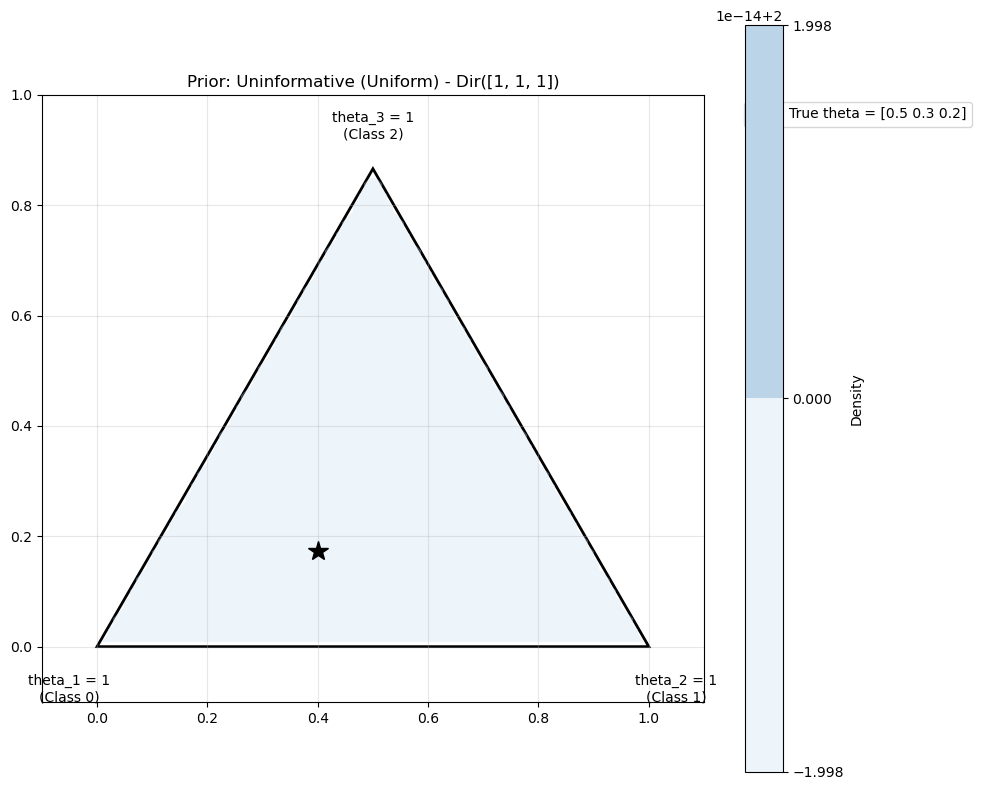

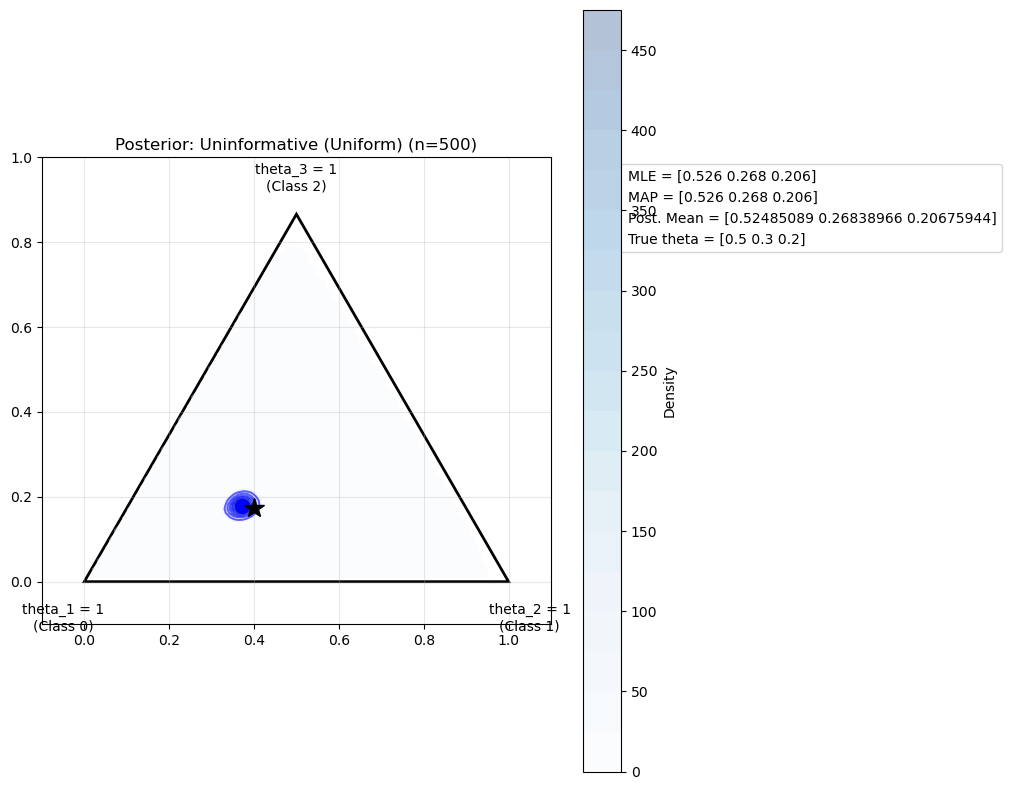


Weakly Informative Prior: Dir([2, 2, 2])
--------------------------------------------------
n=  5: MLE=[0.2 0.2 0.6]
MAP=[0.25 0.25 0.5 ]
Posterior.Mean=[0.27272727 0.27272727 0.45454545]

n= 50: MLE=[0.52 0.28 0.2 ]
MAP=[0.50943396 0.28301887 0.20754717]
Posterior.Mean=[0.5        0.28571429 0.21428571]

n=500: MLE=[0.526 0.268 0.206]
MAP=[0.52485089 0.26838966 0.20675944]
Posterior.Mean=[0.52371542 0.2687747  0.20750988]



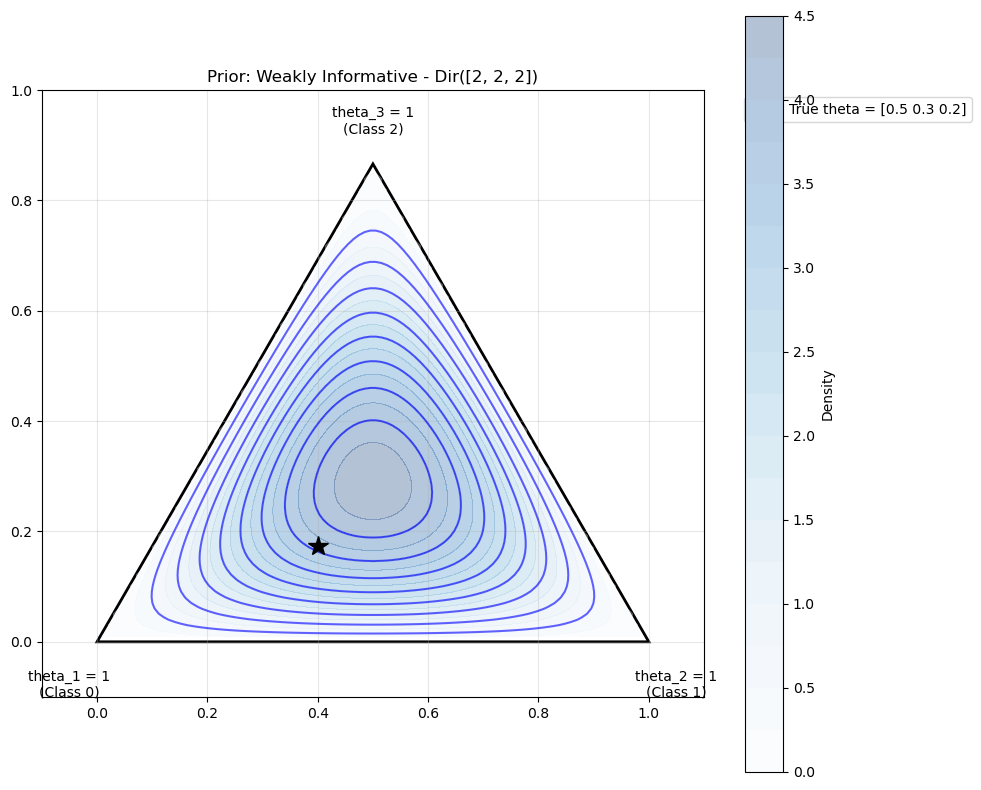

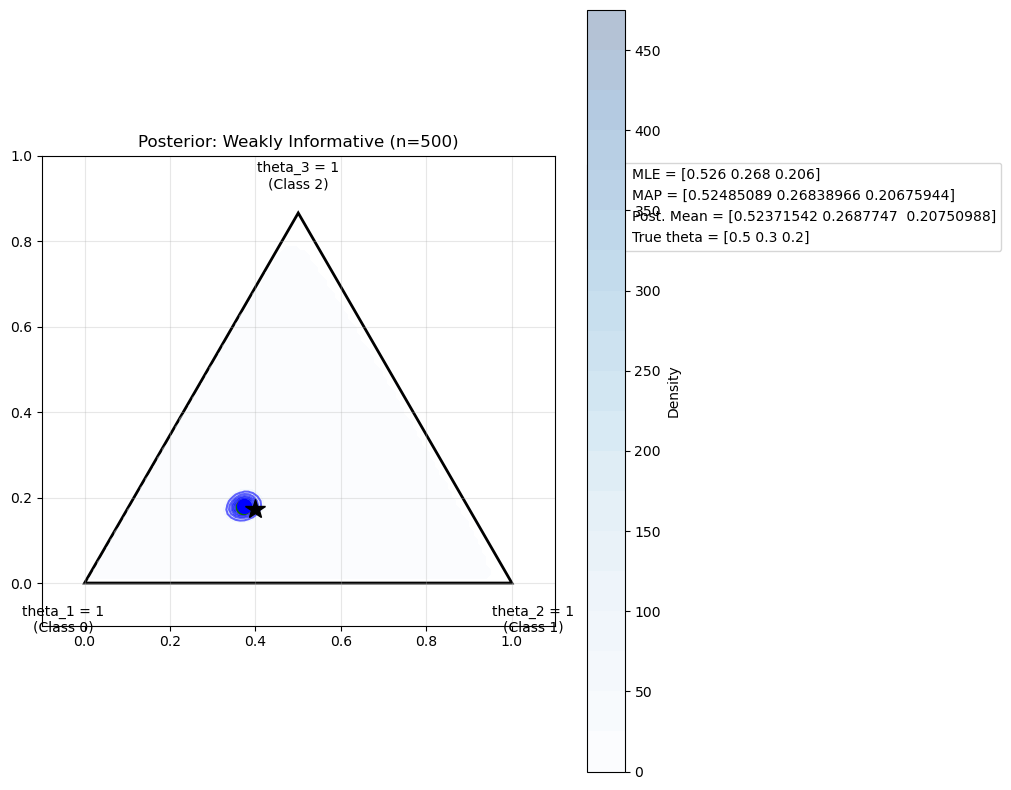


Informative (matches true) Prior: Dir([5, 3, 2])
--------------------------------------------------
n=  5: MLE=[0.2 0.2 0.6]
MAP=[0.41666667 0.25       0.33333333]
Posterior.Mean=[0.4        0.26666667 0.33333333]

n= 50: MLE=[0.52 0.28 0.2 ]
MAP=[0.52631579 0.28070175 0.19298246]
Posterior.Mean=[0.51666667 0.28333333 0.2       ]

n=500: MLE=[0.526 0.268 0.206]
MAP=[0.52662722 0.26824458 0.20512821]
Posterior.Mean=[0.5254902  0.26862745 0.20588235]



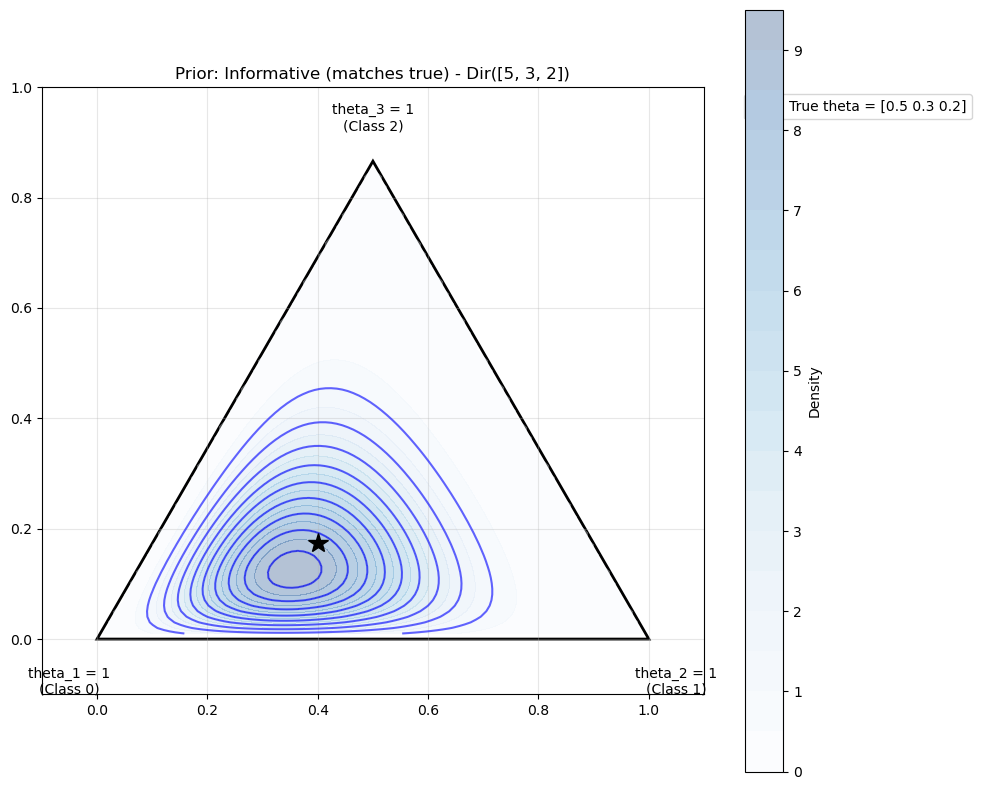

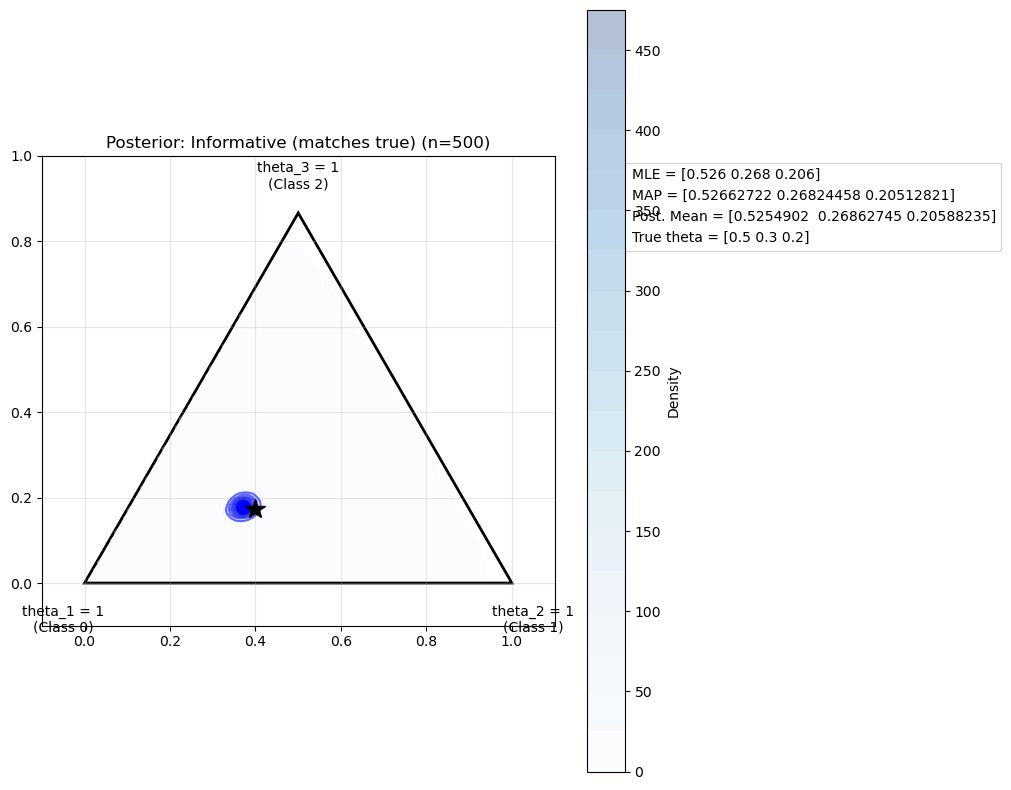


Informative (mismatched) Prior: Dir([2, 5, 3])
--------------------------------------------------
n=  5: MLE=[0.2 0.2 0.6]
MAP=[0.16666667 0.41666667 0.41666667]
Posterior.Mean=[0.2 0.4 0.4]

n= 50: MLE=[0.52 0.28 0.2 ]
MAP=[0.47368421 0.31578947 0.21052632]
Posterior.Mean=[0.46666667 0.31666667 0.21666667]

n=500: MLE=[0.526 0.268 0.206]
MAP=[0.52071006 0.27218935 0.20710059]
Posterior.Mean=[0.51960784 0.27254902 0.20784314]



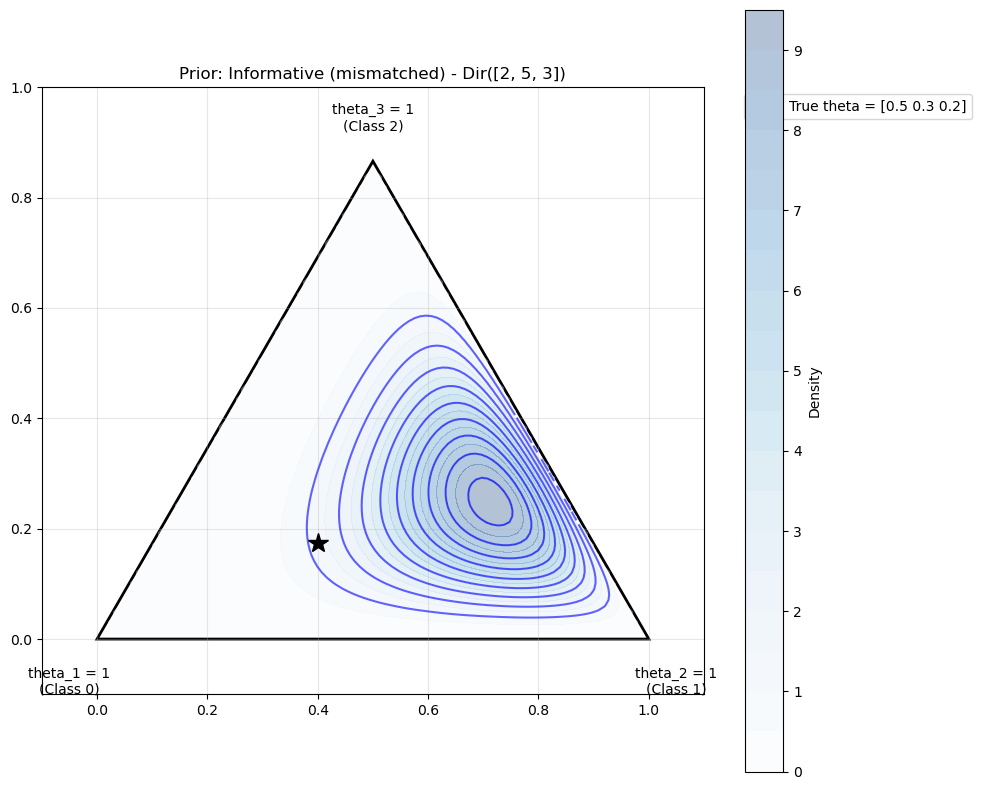

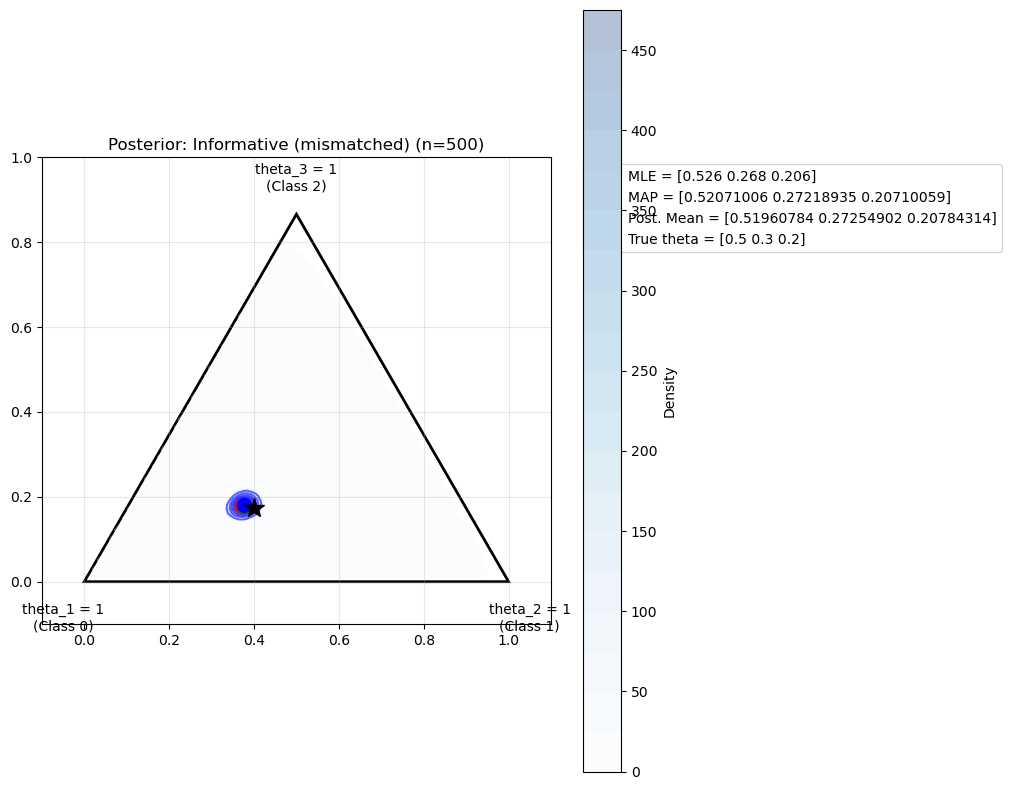


Posterior Predictive Probabilities
Posterior predictive probabilities for new observation:
P(new obs = class 0) = 0.525
P(new obs = class 1) = 0.268
P(new obs = class 2) = 0.207
Sum = 1.000

Posterior predictive uncertainty (from 1000 samples):
Mean counts for 1 new obs: [0.492 0.279 0.229]
Std of counts: [0.499936   0.44850753 0.42018924]


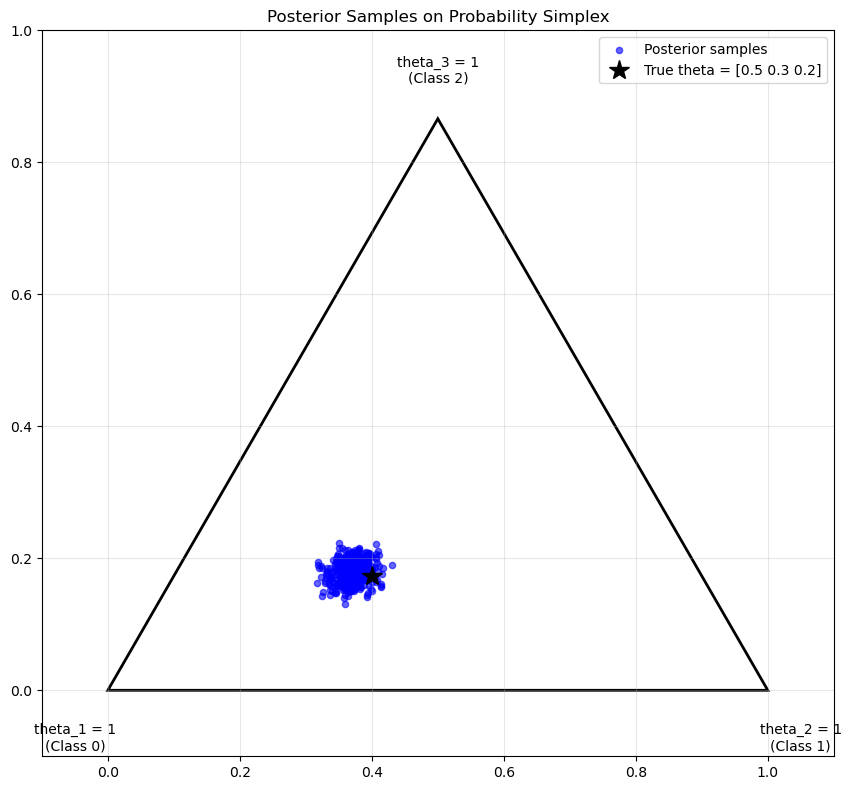

In [9]:
if __name__ == "__main__":
    results = multinomial_bayesian()

## **Part A.3**: Univariate Gaussian

### **Case 1**: Known Variance, Unknown Mean

In [ ]:
class GaussianKnownVariance:
    """
    Univariate Gaussian
    Parameter estimation for (mu) with known variance (sigma^2)
    """
    def __init__(self, mu_0 = 0.0, sigma_0_sq = 1.0, sigma_sq = 1.0):
        self.mu_0 = mu_0                    
        self.sigma_0_sq = sigma_0_sq        
        self.sigma_sq = sigma_sq
        
        # posterior parameters to be set to None initially
        self.mu_N = None                    
        self.sigma_N_sq = None              
        self.data = None
        
    def generate_data(self, n_samples, true_mean):
        self.true_mean = true_mean
        self.data = np.random.normal(true_mean, np.sqrt(self.sigma_sq), n_samples)
        
        return self.data
    
    def update_posterior(self, data = None):
        if data is not None:
            self.data = data

        if self.data is None:
            raise ValueError("No data provided for posterior update")
        
        N = len(self.data)
        x_bar = np.mean(self.data)
        
        self.mu_N = ((self.sigma_sq * self.mu_0 + N * self.sigma_0_sq * x_bar) / (N * self.sigma_0_sq + self.sigma_sq))
        precision_N = N / self.sigma_sq + 1 / self.sigma_0_sq
        self.sigma_N_sq = 1 / precision_N
        
        return self.mu_N, self.sigma_N_sq
    
    def get_estimates(self):
        """
        MLE, MAP, and Posterior Mean to be returned
        """
        if self.data is None:
            raise ValueError("No data available for estimation")
        
        mle_ = np.mean(self.data)
        map_ = self.mu_N
        posterior_mean = self.mu_N
        
        return{
            'MLE': mle_,
            'MAP': map_,
            'Posterior Mean': posterior_mean,
            'True Mean': getattr(self, 'true_mean', None)
        }

In [11]:
def plot_case1_distributions(estimator, title_suffix=""):
    if estimator.data is None:
        raise ValueError("No data to plot")
        
    if estimator.mu_N is not None:
        sigma_N = np.sqrt(estimator.sigma_N_sq)
        mu_range = np.linspace(
            min(estimator.mu_0 - 3 * np.sqrt(estimator.sigma_0_sq), 
                estimator.mu_N - 3 * sigma_N),
            max(estimator.mu_0 + 3 * np.sqrt(estimator.sigma_0_sq),
                estimator.mu_N + 3 * sigma_N),
            1000
        )
    else:
        mu_range = np.linspace(
            estimator.mu_0 - 3 * np.sqrt(estimator.sigma_0_sq),
            estimator.mu_0 + 3 * np.sqrt(estimator.sigma_0_sq),
            1000
        )
    
    prior_pdf = stats.norm.pdf(mu_range, estimator.mu_0, np.sqrt(estimator.sigma_0_sq))
    
    plt.figure(figsize=(12, 6))
    plt.plot(mu_range, prior_pdf, 'b-', linewidth=2, 
             label=f'Prior: N(mu_0 = {estimator.mu_0}, sigma_0_sq = {estimator.sigma_0_sq})')

    if estimator.mu_N is not None:
        sigma_N = np.sqrt(estimator.sigma_N_sq)
        posterior_pdf = stats.norm.pdf(mu_range, estimator.mu_N, sigma_N)
        plt.plot(mu_range, posterior_pdf, 'r-', linewidth=3,
                 label=f'Posterior: N(mu_N = {estimator.mu_N:.3f}, sigma_N_sq = {estimator.sigma_N_sq:.3f})')
        
        estimates = estimator.get_estimates()
        plt.axvline(estimates['MLE'], color='orange', linestyle='--', linewidth=2,
                   label=f"MLE = {estimates['MLE']:.3f}")
        plt.axvline(estimates['Posterior Mean'], color='green', linestyle='--', linewidth=2,
                   label=f"mu_N = {estimates['Posterior Mean']:.3f}")

        if estimates['True Mean'] is not None:
            plt.axvline(estimates['True Mean'], color='black', linestyle='-', linewidth=2,
                       label=f"True mu = {estimates['True Mean']:.3f}")

    plt.xlabel('mu')
    plt.ylabel('Density')
    plt.title(f'Case 1: Known Variance sigma_sq={estimator.sigma_sq}, Unknown Mean {title_suffix}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [12]:
def case1():
    true_mean = 2.5
    known_variance = 1.5
    data_sizes = [5, 50, 250]
    
    priors = [
        (0.0, 4.0, "Uninformative:"),
        (2.0, 0.25, "Informative (close):"),
        (-1.0, 0.25, "Informative (wrong):")
    ]
    
    print(f"True mean: mu = {true_mean}")
    print(f"Known variance: sigma_sq = {known_variance}\n")
    
    max_samples = max(data_sizes)
    np.random.seed(13)
    full_data = np.random.normal(true_mean, np.sqrt(known_variance), max_samples)
    
    for mu_0, sigma_0_sq, prior_name in priors:
        print(f"\n{prior_name}")
        print("-" * 50)
        
        for n in data_sizes:
            estimator = GaussianKnownVariance(mu_0, sigma_0_sq, known_variance)
            data_subset = full_data[:n]
            estimator.data = data_subset
            estimator.update_posterior()
            
            estimates = estimator.get_estimates()
            
            print(f"n={n:3d}: x_bar={estimates['MLE']:.3f}, "
                  f"mu_N={estimates['Posterior Mean']:.3f}, "
                  f"sigma_N²={estimator.sigma_N_sq:.3f}")
            
            estimator = GaussianKnownVariance(mu_0, sigma_0_sq, known_variance)
            estimator.data = full_data[:max(data_sizes)]
            estimator.true_mean = true_mean
            estimator.update_posterior()

            plot_case1_distributions(estimator, f"- {prior_name} (n={max(data_sizes)})")

True mean: mu = 2.5
Known variance: sigma_sq = 1.5


Uninformative:
--------------------------------------------------
n=  5: x_bar=2.939, mu_N=2.734, sigma_N²=0.279


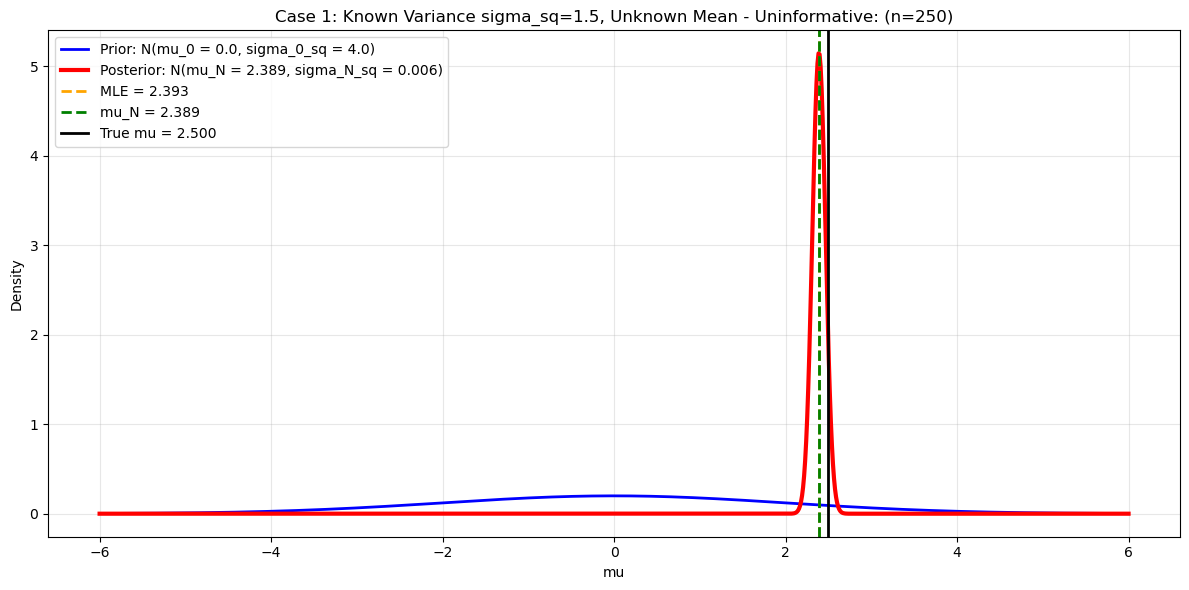

n= 50: x_bar=2.672, mu_N=2.652, sigma_N²=0.030


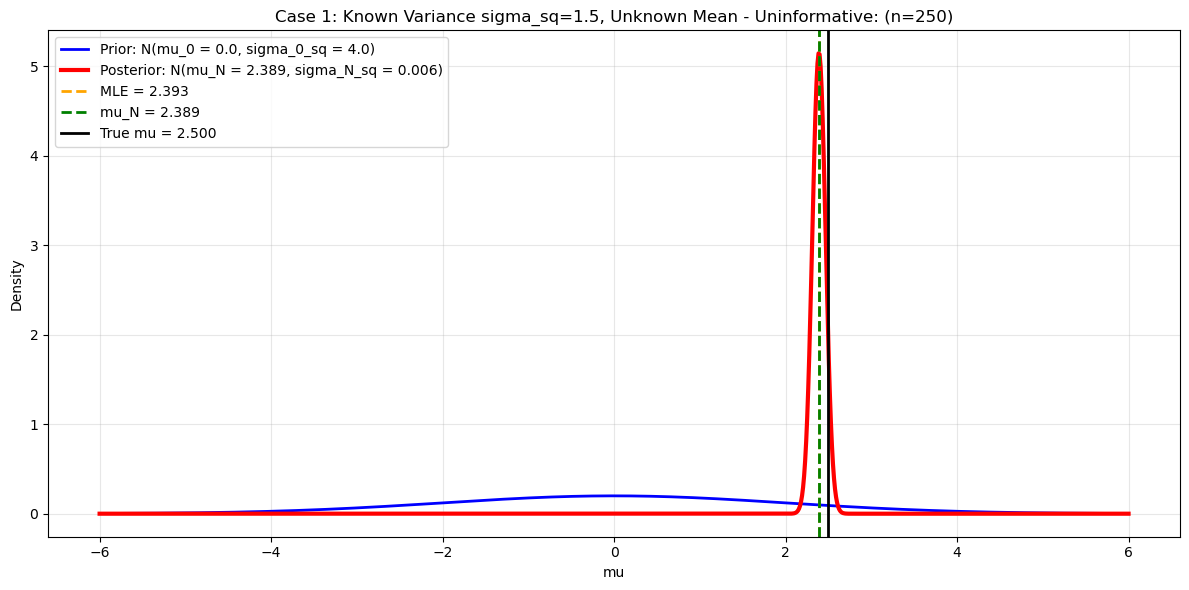

n=250: x_bar=2.393, mu_N=2.389, sigma_N²=0.006


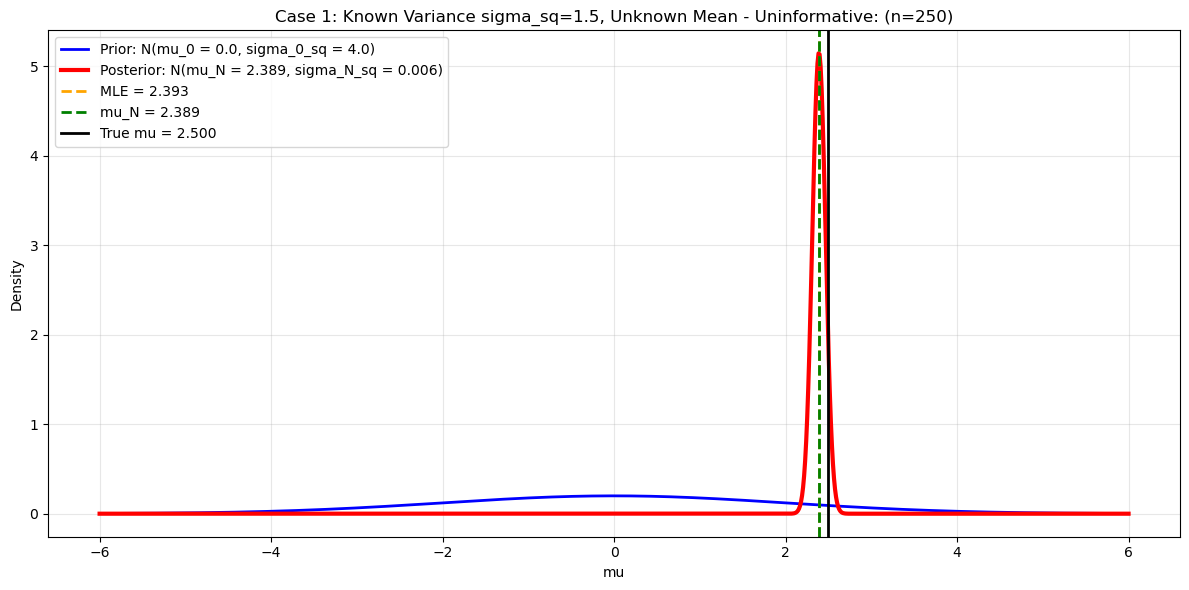


Informative (close):
--------------------------------------------------
n=  5: x_bar=2.939, mu_N=2.427, sigma_N²=0.136


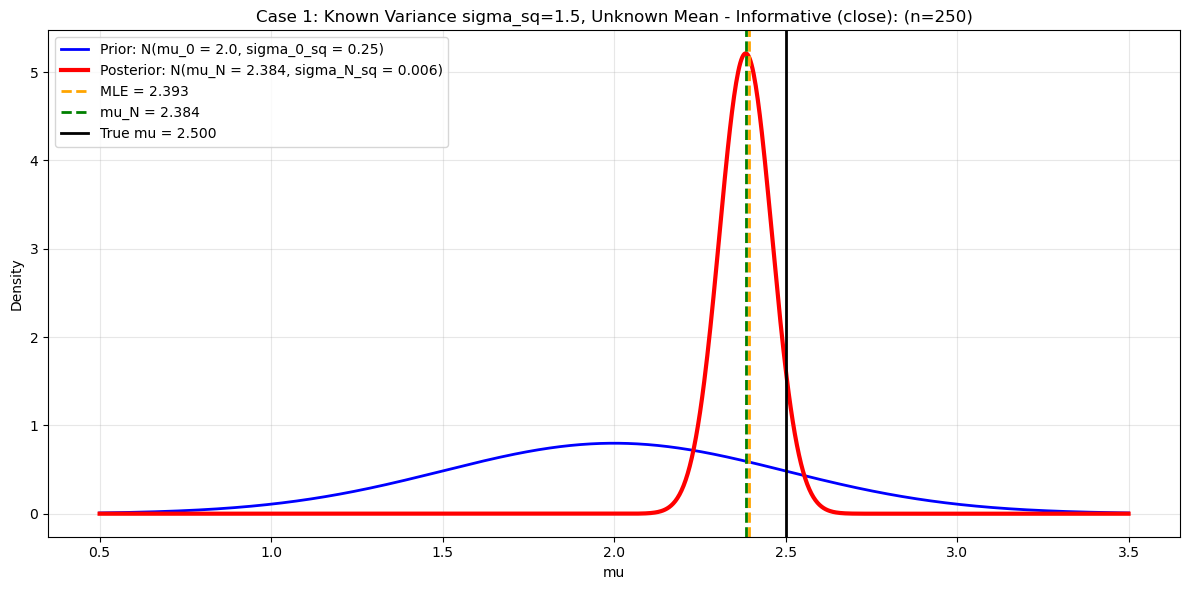

n= 50: x_bar=2.672, mu_N=2.600, sigma_N²=0.027


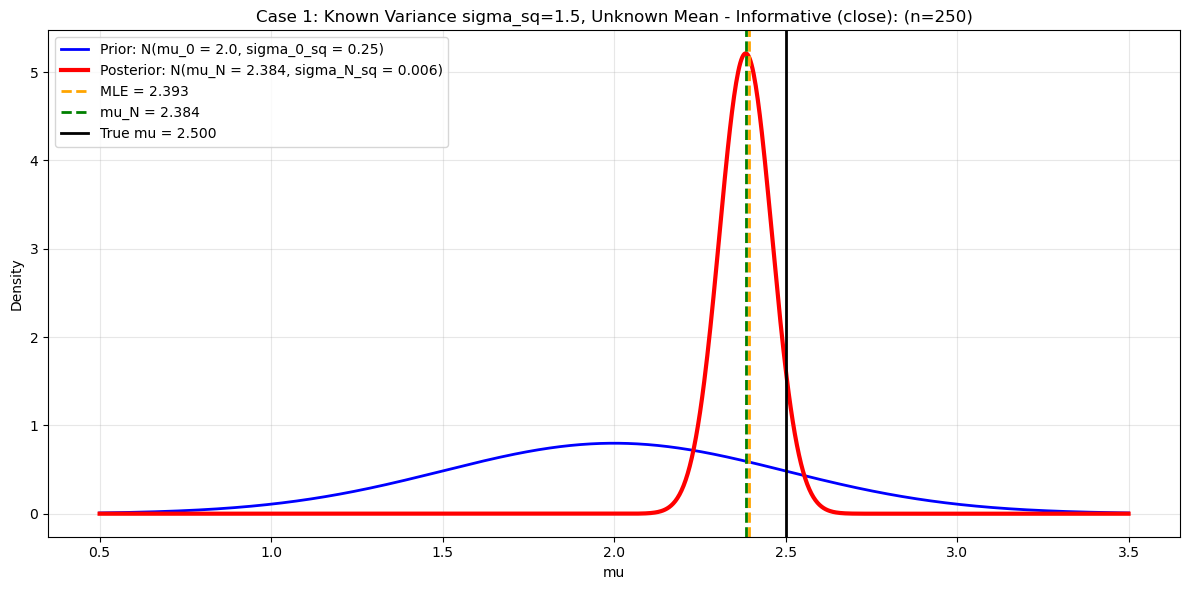

n=250: x_bar=2.393, mu_N=2.384, sigma_N²=0.006


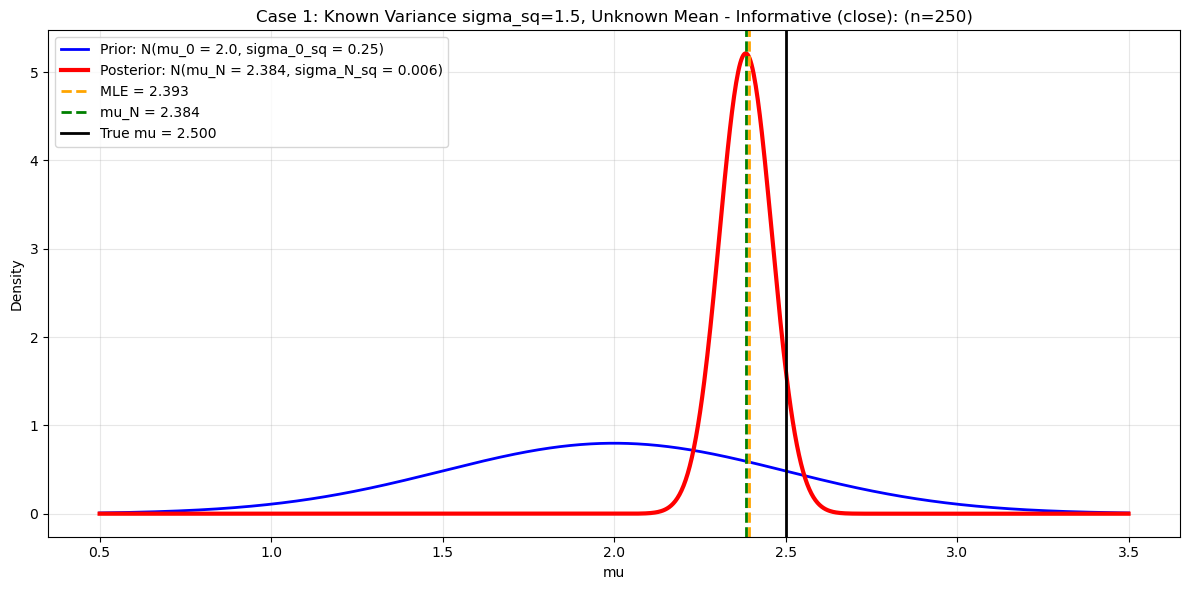


Informative (wrong):
--------------------------------------------------
n=  5: x_bar=2.939, mu_N=0.791, sigma_N²=0.136


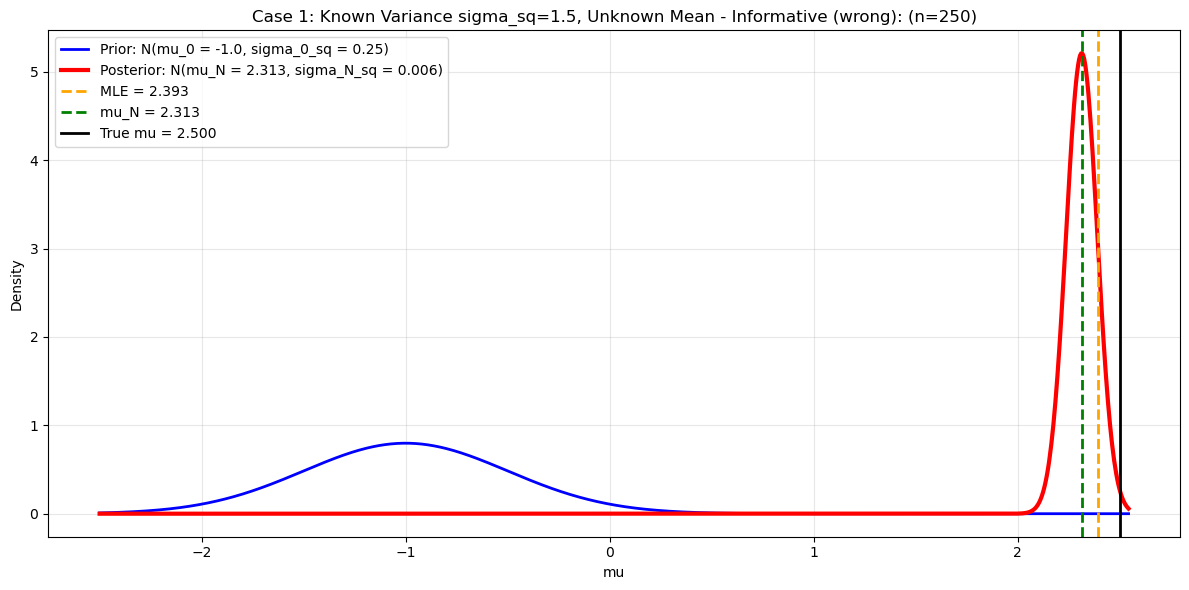

n= 50: x_bar=2.672, mu_N=2.278, sigma_N²=0.027


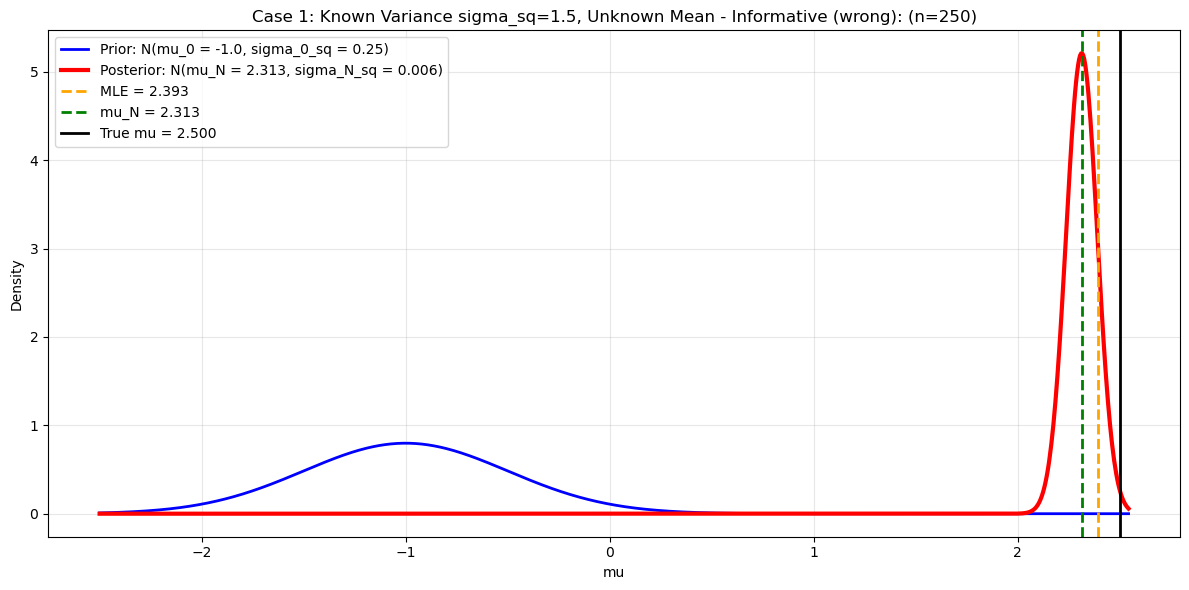

n=250: x_bar=2.393, mu_N=2.313, sigma_N²=0.006


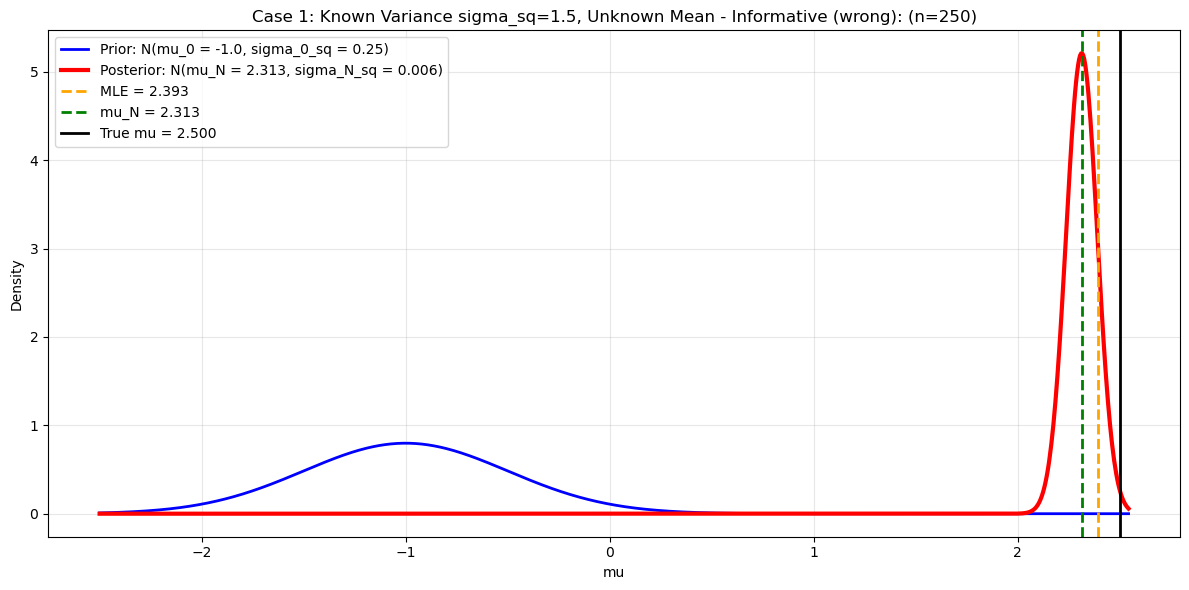

In [13]:
if __name__ == "__main__":
    case1()

### **Case 2**: Unknown Variance, Unknown Mean

In [14]:
class GaussianNormalInverseGamma:
    def __init__(self, mu_0 = 0.0, kappa_0 = 1.0, alpha_0 = 1.0, beta_0 = 1.0):
        self.mu_0 = mu_0        
        self.kappa_0 = kappa_0  
        self.alpha_0 = alpha_0  
        self.beta_0 = beta_0
        
        # posterior parameters to be determined later
        self.mu_n = None        
        self.kappa_n = None     
        self.alpha_n = None     
        self.beta_n = None      
        self.data = None
        
    def generate_data(self, n_samples, true_mean, true_variance):
        self.true_mean = true_mean
        self.true_var = true_variance
        self.data = np.random.normal(true_mean, np.sqrt(true_variance), n_samples)
        
        return self.data
    
    def update_posterior(self, data = None):
        """
        Update the posterior parameters for the NIG distribution as given in the slides
        """
        if data is not None:
            self.data = data
        
        if self.data is None:
            raise ValueError("No data available to update posterior.")
        
        N = len(self.data)
        x_bar = np.mean(self.data)
        
        sum_sq_dev = np.sum((self.data - x_bar) ** 2)
        
        self.kappa_n = self.kappa_0 + N
        self.mu_n = (self.kappa_0 * self.mu_0 + N * x_bar) / self.kappa_n
        self.alpha_n = self.alpha_0 + N / 2
        self.beta_n = self.beta_0 + 0.5 * sum_sq_dev + (self.kappa_0 * N * (x_bar - self.mu_0) ** 2) / (2 * self.kappa_n)
        
        return self.mu_n, self.kappa_n, self.alpha_n, self.beta_n
    
    def get_estimates(self):
        """
        Point Estimates for mean and variance
        """
        if self.data is None:
            raise ValueError("No data available to get estimates.")
        
        N = len(self.data)
        mle_mean = np.mean(self.data)
        mle_variance = np.var(self.data, ddof = 0)
        
        posterior_mean_mu = self.mu_n
        posterior_mean_sigma_sq = self.beta_n / (self.alpha_n - 1) if self.alpha_n > 1 else np.inf

        map_mean = self.mu_n
        map_variance = self.beta_n / (self.alpha_n + 1)
        
        return {
            'MLE_mean': mle_mean,
            'MLE_variance': mle_variance,
            'MAP_mean': map_mean,
            'MAP_variance': map_variance,
            'Posterior_Mean_mu': posterior_mean_mu,
            'Posterior_Mean_sigma_sq': posterior_mean_sigma_sq,
            'True_Mean': getattr(self, 'true_mean', None),
            'True_Variance': getattr(self, 'true_variance', None)
        }

In [15]:
def plot_case2_distributions(estimator, title_suffix=""):
    if estimator.data is None:
        raise ValueError("No data to plot")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    mu_range = np.linspace(estimator.mu_0 - 4, estimator.mu_0 + 4, 1000)
    
    prior_df = 2 * estimator.alpha_0
    prior_scale = np.sqrt(estimator.beta_0 * (estimator.kappa_0 + 1) / (estimator.alpha_0 * estimator.kappa_0))
    prior_mu_pdf = stats.t.pdf((mu_range - estimator.mu_0) / prior_scale, prior_df) / prior_scale
    
    ax1.plot(mu_range, prior_mu_pdf, 'b-', linewidth=2, 
             label=f'Prior: mu_0={estimator.mu_0}, kappa_0={estimator.kappa_0}')
    
    if estimator.mu_n is not None:
        post_df = 2 * estimator.alpha_n
        post_scale = np.sqrt(estimator.beta_n * (estimator.kappa_n + 1) / (estimator.alpha_n * estimator.kappa_n))
        post_mu_pdf = stats.t.pdf((mu_range - estimator.mu_n) / post_scale, post_df) / post_scale

        ax1.plot(mu_range, post_mu_pdf, 'r-', linewidth=3,
                label=f'Posterior: mu_n={estimator.mu_n:.3f}, kappa_n={estimator.kappa_n}')
        
        estimates = estimator.get_estimates()
        ax1.axvline(estimates['MLE_mean'], color='orange', linestyle='--', linewidth=2,
                   label=f"MLE = {estimates['MLE_mean']:.3f}")
        ax1.axvline(estimates['Posterior_Mean_mu'], color='green', linestyle='--', linewidth=2,
                   label=f"mu_n = {estimates['Posterior_Mean_mu']:.3f}")

        if estimates['True_Mean'] is not None:
            ax1.axvline(estimates['True_Mean'], color='black', linestyle='-', linewidth=2,
                       label=f"True mu = {estimates['True_Mean']:.3f}")
    
    ax1.set_xlabel('mu')
    ax1.set_ylabel('Density')
    ax1.set_title('Marginal Distribution of mu')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    sigma_sq_range = np.linspace(0.01, 10, 1000)
    
    prior_sigma_pdf = stats.invgamma.pdf(sigma_sq_range, estimator.alpha_0, scale=estimator.beta_0)
    ax2.plot(sigma_sq_range, prior_sigma_pdf, 'b-', linewidth=2,
             label=f'Prior: Inv-Gamma(alpha_0={estimator.alpha_0}, beta_0={estimator.beta_0})')

    if estimator.alpha_n is not None:
        post_sigma_pdf = stats.invgamma.pdf(sigma_sq_range, estimator.alpha_n, scale=estimator.beta_n)
        ax2.plot(sigma_sq_range, post_sigma_pdf, 'r-', linewidth=3,
                label=f'Posterior: Inv-Gamma(alpha_n={estimator.alpha_n:.1f}, beta_n={estimator.beta_n:.2f})')

        ax2.axvline(estimates['MLE_variance'], color='orange', linestyle='--', linewidth=2,
                   label=f"MLE = {estimates['MLE_variance']:.3f}")
        ax2.axvline(estimates['MAP_variance'], color='purple', linestyle='--', linewidth=2,
                   label=f"MAP = {estimates['MAP_variance']:.3f}")
        
        if estimates['True_Variance'] is not None:
            ax2.axvline(estimates['True_Variance'], color='black', linestyle='-', linewidth=2,
                       label=f"True sigma^2 = {estimates['True_Variance']:.3f}")

    ax2.set_xlabel('sigma^2')
    ax2.set_ylabel('Density')
    ax2.set_title('Marginal Distribution of sigma^2')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.suptitle(f'Case 2: N-I-G Prior, Unknown Mean & Variance {title_suffix}')
    plt.tight_layout()
    plt.show()

In [16]:
def case2():
    true_mean = 3.0
    true_variance = 2.0
    data_sizes = [5, 50, 250]
    
    priors = [
        (0.0, 1.0, 1.0, 1.0, "Uninformative"),
        (3.0, 2.0, 2.0, 2.0, "Informative"),
        (0.0, 5.0, 3.0, 0.5, "Strong mean, low variance belief")
    ]

    print(f"True mean: mu = {true_mean}")
    print(f"True variance: sigma^2 = {true_variance}\n")

    max_samples = max(data_sizes)
    np.random.seed(13)
    full_data = np.random.normal(true_mean, np.sqrt(true_variance), max_samples)
    
    for mu_0, kappa_0, alpha_0, beta_0, prior_name in priors:
        print(f"\n{prior_name}")
        print("-" * 50)

        for n in data_sizes:
            estimator = GaussianNormalInverseGamma(mu_0, kappa_0, alpha_0, beta_0)
            data_subset = full_data[:n]
            estimator.data = data_subset
            estimator.update_posterior()

            estimates = estimator.get_estimates()
            
            print(f"n={n:3d}: MLE_mu={estimates['MLE_mean']:.3f}, MLE_sigma_sq={estimates['MLE_variance']:.3f}")
            print(f"mu_n={estimates['Posterior_Mean_mu']:.3f}, MAP_sigma_sq={estimates['MAP_variance']:.3f}")
            
        estimator = GaussianNormalInverseGamma(mu_0, kappa_0, alpha_0, beta_0)
        estimator.data = full_data[:max(data_sizes)]
        estimator.true_mean = true_mean
        estimator.true_variance = true_variance
        estimator.update_posterior()
        
        plot_case2_distributions(estimator, f"- {prior_name} (n={max(data_sizes)})")

True mean: mu = 3.0
True variance: sigma^2 = 2.0


Uninformative
--------------------------------------------------
n=  5: MLE_mu=3.507, MLE_sigma_sq=0.979
mu_n=2.923, MAP_sigma_sq=1.905
n= 50: MLE_mu=3.198, MLE_sigma_sq=1.720
mu_n=3.136, MAP_sigma_sq=1.816
n=250: MLE_mu=2.876, MLE_sigma_sq=1.678
mu_n=2.865, MAP_sigma_sq=1.692


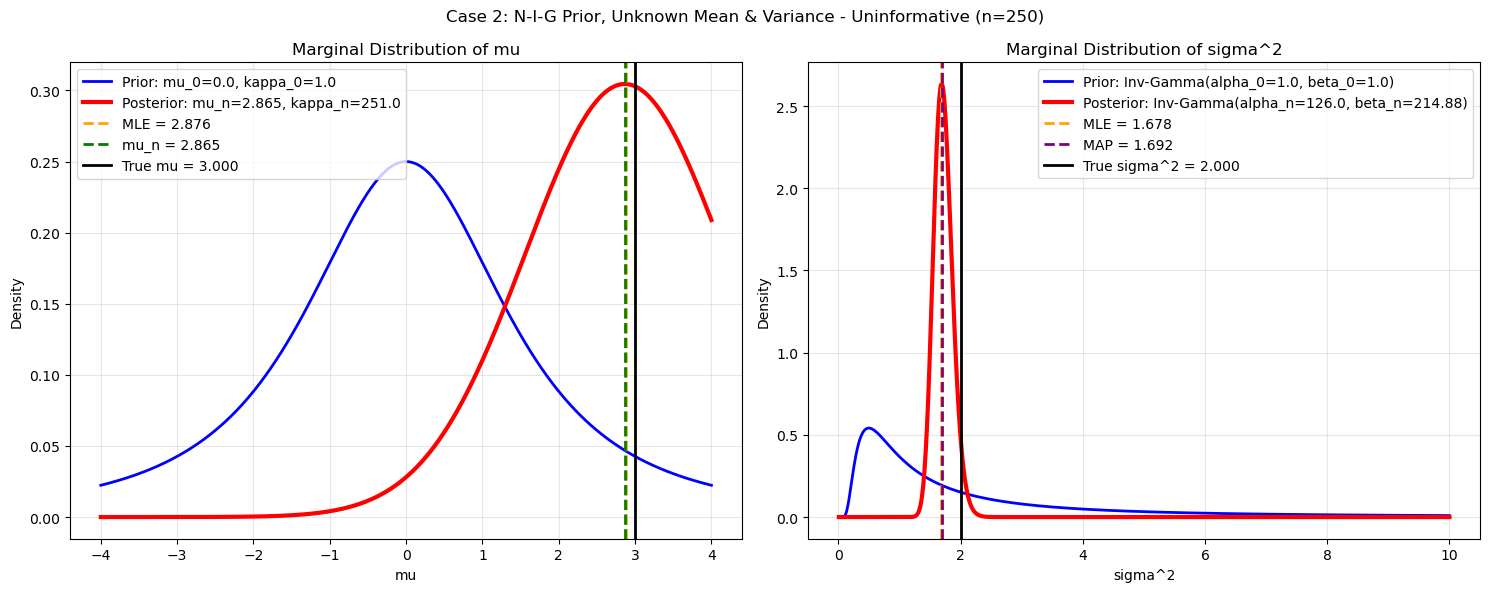


Informative
--------------------------------------------------
n=  5: MLE_mu=3.507, MLE_sigma_sq=0.979
mu_n=3.362, MAP_sigma_sq=0.842
n= 50: MLE_mu=3.198, MLE_sigma_sq=1.720
mu_n=3.191, MAP_sigma_sq=1.609
n=250: MLE_mu=2.876, MLE_sigma_sq=1.678
mu_n=2.877, MAP_sigma_sq=1.655


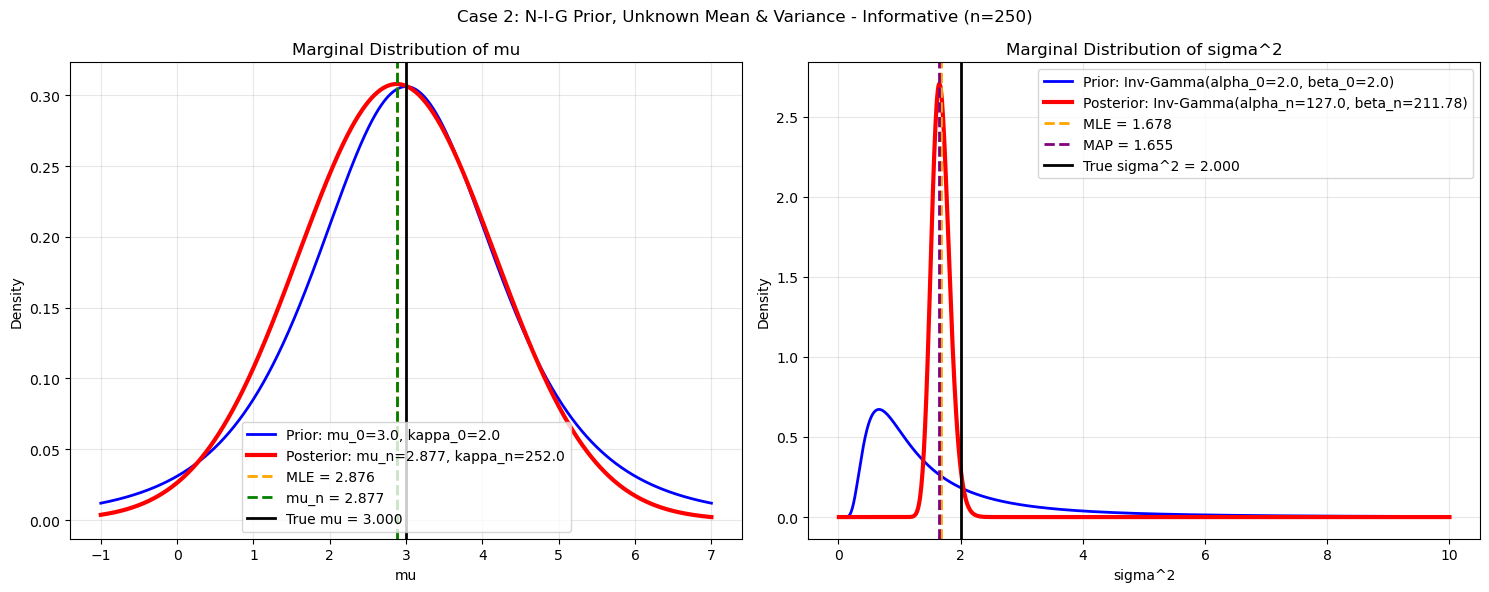


Strong mean, low variance belief
--------------------------------------------------
n=  5: MLE_mu=3.507, MLE_sigma_sq=0.979
mu_n=1.754, MAP_sigma_sq=2.819
n= 50: MLE_mu=3.198, MLE_sigma_sq=1.720
mu_n=2.908, MAP_sigma_sq=2.302
n=250: MLE_mu=2.876, MLE_sigma_sq=1.678
mu_n=2.820, MAP_sigma_sq=1.787


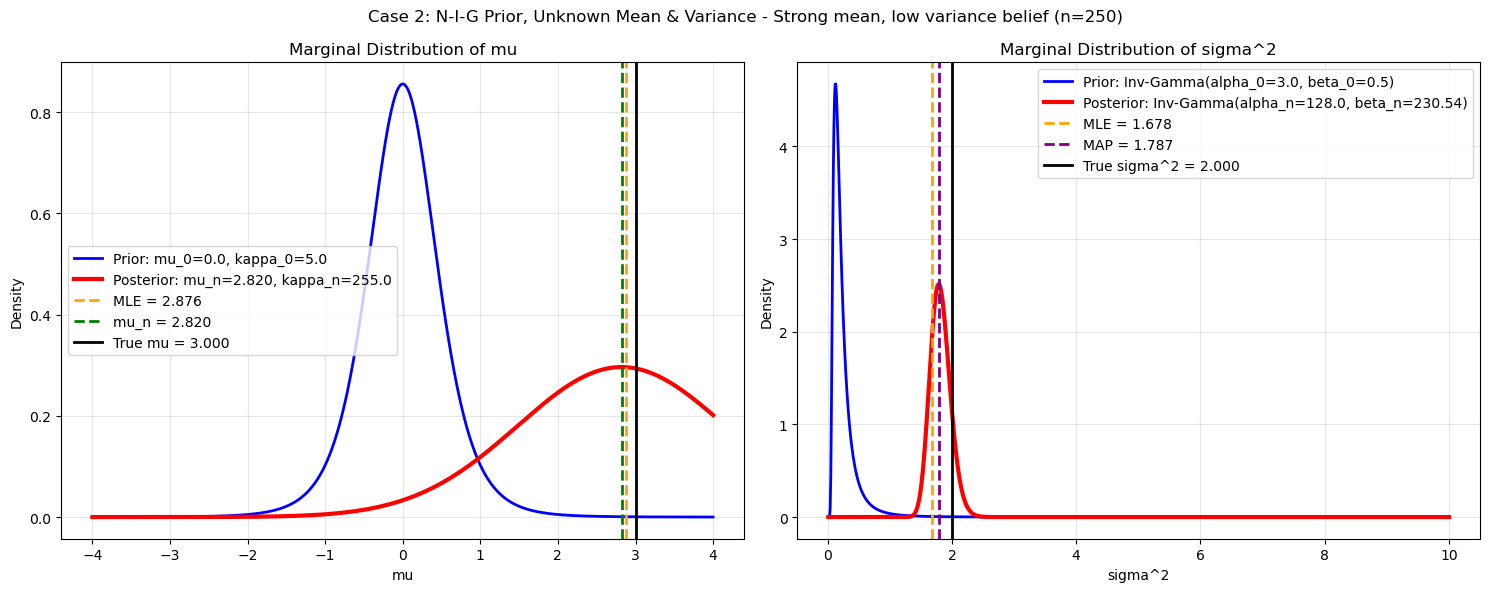

In [17]:
if __name__ == "__main__":
    case2()

## **Part A.4**: Multivariate Gaussian

In [18]:
class MultivariateGaussianNIW:
    """
    Multivariate Gaussian with Normal-Inverse-Wishart prior
    """
    def __init__(self, mu_0 = None, kappa_0 = 1.0, psi_0 = None, nu_0 = None, dim = 2):
        self.dim = dim
        self.mu_0 = np.array(mu_0) if mu_0 is not None else np.zeros(dim)
        self.kappa_0 = kappa_0
        self.psi_0 = np.array(psi_0) if psi_0 is not None else np.eye(dim)
        self.nu_0 = nu_0 if nu_0 is not None else dim + 2

        # posterior parameters to be determined later
        self.mu_n = None
        self.kappa_n = None
        self.psi_n = None
        self.nu_n = None
        self.data = None
        
    def generate(self, n_samples, true_mean, true_cov):
        self.true_mean = np.array(true_mean)
        self.true_cov = np.array(true_cov)
        
        self.data = np.random.multivariate_normal(true_mean, true_cov, n_samples)
        
        return self.data
    
    def update_posterior(self, data = None):
        if data is not None:
            self.data = data

        if self.data is None:
            raise ValueError("No data available to update posterior.")
        
        N = len(self.data)
        y_bar = np.mean(self.data, axis = 0)
        
        # S -> scatter matrix
        S = np.zeros((self.dim, self.dim))
        for i in range(N):
            diff = self.data[i] - y_bar
            S += np.outer(diff, diff)

        # updating the posterior parameters
        self.mu_n = (self.kappa_0 * self.mu_0 + N * y_bar) / (self.kappa_0 + N)
        self.kappa_n = self.kappa_0 + N
        self.psi_n = self.psi_0 + S + (self.kappa_0 * N / (self.kappa_0 + N)) * np.outer(y_bar - self.mu_0, y_bar - self.mu_0)
        self.nu_n = self.nu_0 + N
        
        return self.mu_n, self.kappa_n, self.psi_n, self.nu_n
    
    def get_estimates(self):
        """
        To determine the point estimates for the mean vector and covariance matrix
        """
        if self.data is None:
            raise ValueError("No data available to get estimates.")
        
        N = len(self.data)
        mle_mean = np.mean(self.data, axis=0)
        mle_cov = np.cov(self.data.T, ddof=0)
        
        posterior_mean_mu = self.mu_n
        if self.nu_n > self.dim + 1:
            posterior_mean_cov = self.psi_n / (self.nu_n - self.dim - 1)  
        else:
            posterior_mean_cov = None
            
        map_mean = self.mu_n
        map_cov = self.psi_n / (self.nu_n + 1 + self.dim)
        
        return{
            'MLE_mean': mle_mean,
            'MLE_cov': mle_cov,
            'MAP_mean': map_mean,
            'MAP_cov': map_cov,
            'Posterior_Mean_mu': posterior_mean_mu,
            'Posterior_Mean_cov': posterior_mean_cov,
            'True_Mean': getattr(self, 'true_mean', None),
            'True_Cov': getattr(self, 'true_cov', None)
        }
        
    def sample_posterior(self, n_samples = 1000):
        """
        ** From the INTERNET **
        The NIW posterior maintains the hierarchical structure:
        1. Sample Σ ~ Inverse-Wishart(νₙ, Ψₙ)
        2. For each Σ, sample μ | Σ ~ N(μₙ, Σ/κₙ)
        """
        if self.mu_n is None:
            raise ValueError("Posterior not computed yet")
        
        cov_samples = stats.wishart.rvs(self.nu_n, self.psi_n, size = n_samples)
        if n_samples == 1:
            cov_samples = cov_samples.reshape(1, self.dim, self.dim)
        mean_samples = np.zeros((n_samples, self.dim))
        
        for i in range(n_samples):
            conditional_cov = cov_samples[i] / self.kappa_n
            mean_samples[i] = np.random.multivariate_normal(self.mu_n, conditional_cov)
            
        return mean_samples, cov_samples

In [19]:
def plot_confidence_ellipse(mean, cov, ax, n_std=2.0, **kwargs):
    eigenvals, eigenvecs = np.linalg.eig(cov)
    
    angle = np.degrees(np.arctan2(eigenvecs[1, 0], eigenvecs[0, 0]))
    
    width = 2 * n_std * np.sqrt(eigenvals[0])
    height = 2 * n_std * np.sqrt(eigenvals[1])
    
    ellipse = Ellipse(mean, width, height, angle=angle, **kwargs)
    ax.add_patch(ellipse)
    
    return ellipse

In [20]:
def plot_posterior_samples_2d(estimator, n_samples=100, title_suffix=""):
    if estimator.data is None:
        raise ValueError("No data to plot")
        
    mean_samples, cov_samples = estimator.sample_posterior(n_samples)
    estimates = estimator.get_estimates()
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    ax1.scatter(estimator.data[:, 0], estimator.data[:, 1], alpha=0.6, s=30, 
                c='lightblue', label=f'Observed data (n={len(estimator.data)})')
    
    if estimates['True_Mean'] is not None and estimates['True_Cov'] is not None:
        ax1.scatter(estimates['True_Mean'][0], estimates['True_Mean'][1], 
                   c='black', s=100, marker='*', label='True mean')
        plot_confidence_ellipse(estimates['True_Mean'], estimates['True_Cov'], ax1, 
                               n_std=2, fill=False, edgecolor='black', linewidth=2,
                               label='True 95% ellipse')
    
    ax1.scatter(estimates['MLE_mean'][0], estimates['MLE_mean'][1], 
               c='orange', s=100, marker='s', label='MLE mean')
    plot_confidence_ellipse(estimates['MLE_mean'], estimates['MLE_cov'], ax1,
                           n_std=2, fill=False, edgecolor='orange', linewidth=2,
                           linestyle='--', label='MLE 95% ellipse')
    
    ax1.set_xlabel('X_1')
    ax1.set_ylabel('X_2')
    ax1.set_title('Data and True/MLE Parameters')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.scatter(mean_samples[:, 0], mean_samples[:, 1], alpha=0.6, s=20,
                c='red', label='Posterior mean samples')
    ax2.scatter(estimates['Posterior_Mean_mu'][0], estimates['Posterior_Mean_mu'][1],
               c='darkred', s=100, marker='D', label='Posterior mean')
    
    if estimates['True_Mean'] is not None:
        ax2.scatter(estimates['True_Mean'][0], estimates['True_Mean'][1], 
                   c='black', s=100, marker='*', label='True mean')
    
    ax2.set_xlabel('mu_1')
    ax2.set_ylabel('mu_2')
    ax2.set_title('Posterior Samples of Mean Vector')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    ax3.scatter(estimator.data[:, 0], estimator.data[:, 1], alpha=0.4, s=20,
                c='lightblue', label='Data')
    
    n_ellipses = min(20, n_samples)
    for i in range(0, n_samples, n_samples//n_ellipses):
        plot_confidence_ellipse(mean_samples[i], cov_samples[i], ax3,
                               n_std=2, fill=False, alpha=0.3, edgecolor='red')
    
    if estimates['Posterior_Mean_cov'] is not None:
        plot_confidence_ellipse(estimates['Posterior_Mean_mu'], 
                               estimates['Posterior_Mean_cov'], ax3,
                               n_std=2, fill=False, edgecolor='darkred', 
                               linewidth=3, label='Posterior mean ellipse')

    ax3.set_xlabel('X_1')
    ax3.set_ylabel('X_2')
    ax3.set_title('Posterior Covariance Ellipses')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    cov_11 = cov_samples[:, 0, 0] 
    cov_22 = cov_samples[:, 1, 1] 
    cov_12 = cov_samples[:, 0, 1] 

    ax4.hist(cov_11, alpha=0.5, bins=30, label='cov_11', color='blue')
    ax4.hist(cov_22, alpha=0.5, bins=30, label='cov_22', color='red')
    ax4.hist(cov_12, alpha=0.5, bins=30, label='cov_12', color='green')

    if estimates['True_Cov'] is not None:
        ax4.axvline(estimates['True_Cov'][0,0], color='blue', linestyle='--', 
                   linewidth=2, label='True cov_11')
        ax4.axvline(estimates['True_Cov'][1,1], color='red', linestyle='--', 
                   linewidth=2, label='True cov_22')
        ax4.axvline(estimates['True_Cov'][0,1], color='green', linestyle='--', 
                   linewidth=2, label='True cov_12')

    ax4.set_xlabel('Value')
    ax4.set_ylabel('Frequency')
    ax4.set_title('Posterior Covariance Elements')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.suptitle(f'Multivariate Gaussian Bayesian Estimation {title_suffix}')
    plt.tight_layout()
    plt.show()

In [21]:
def plot_prior_vs_posterior(estimator, title_suffix=""):
    if estimator.data is None:
        raise ValueError("No data to plot")
        
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    prior_mean_samples = []
    prior_cov_samples = []
    
    for _ in range(500):
        cov_sample = stats.invwishart.rvs(estimator.nu_0, estimator.psi_0)
        mean_cov = cov_sample / estimator.kappa_0
        mean_sample = np.random.multivariate_normal(estimator.mu_0, mean_cov)
        
        prior_mean_samples.append(mean_sample)
        prior_cov_samples.append(cov_sample)
        
    prior_mean_samples = np.array(prior_mean_samples)
    prior_cov_samples = np.array(prior_cov_samples)
    
    post_mean_samples, post_cov_samples = estimator.sample_posterior(500)
    
    ax1.scatter(prior_mean_samples[:, 0], prior_mean_samples[:, 1], 
               alpha=0.6, s=20, c='blue', label='Prior mean samples')
    ax1.scatter(post_mean_samples[:, 0], post_mean_samples[:, 1], 
               alpha=0.6, s=20, c='red', label='Posterior mean samples')
    
    ax1.scatter(estimator.mu_0[0], estimator.mu_0[1], c='darkblue', s=100, 
               marker='s', label='Prior mean')
    ax1.scatter(estimator.mu_n[0], estimator.mu_n[1], c='darkred', s=100, 
               marker='D', label='Posterior mean')
    
    if hasattr(estimator, 'true_mean'):
        ax1.scatter(estimator.true_mean[0], estimator.true_mean[1], 
                   c='black', s=100, marker='*', label='True mean')
    
    ax1.set_xlabel('mu_1')
    ax1.set_ylabel('mu_2')
    ax1.set_title('Prior vs Posterior: Mean Vector')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    covariance_elements = [
        (0, 0, 'cov_11', 'Variance of X_1'),
        (1, 1, 'cov_22', 'Variance of X_2'),  
        (0, 1, 'cov_12', 'Covariance X_1,X_2')
    ]
    
    axes = [ax2, ax3, ax4]
    
    for idx, (i, j, label, title) in enumerate(covariance_elements):
        ax = axes[idx]
        ax.set_xlim(-5, 5)

        ax.hist(prior_cov_samples[:, i, j], alpha=0.6, bins=30, 
                label=f'Prior {label}', color='blue', density=True)
        ax.hist(post_cov_samples[:, i, j], alpha=0.6, bins=30, 
                label=f'Posterior {label}', color='red', density=True)
                
        if hasattr(estimator, 'true_cov'):
            ax.axvline(estimator.true_cov[i,j], color='black', linestyle='--', 
                      linewidth=2, label=f'True {label}')
        
        ax.set_xlabel(label)
        ax.set_ylabel('Density')
        ax.set_title(f'Prior vs Posterior: {title}')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'Prior vs Posterior Distributions {title_suffix}')
    plt.tight_layout()
    plt.show()

In [22]:
def demonstrate_multivariate_gaussian():
    true_mean = np.array([2.0, -1.0])
    true_cov = np.array([[2.0, 0.8], 
                        [0.8, 1.5]])
    data_sizes = [5, 50, 500]
    
    print(f"True mean: mu = {true_mean}")
    print(f"True covariance:\ncov = \n{true_cov}\n")
    
    priors = [
        (np.array([0.0, 0.0]), 0.1, np.eye(2), 4, "Uninformative"),
        (np.array([2.0, -1.0]), 2.0, np.array([[2.0, 0.8], [0.8, 1.5]]), 6, "Informative (correct)"),
        (np.array([0.0, 0.0]), 5.0, np.eye(2) * 0.5, 8, "Strong but wrong prior")
    ]
    
    np.random.seed(13)
    max_samples = max(data_sizes)
    full_data = np.random.multivariate_normal(true_mean, true_cov, max_samples)
    
    print("Comparing Priors\n")
    
    # ** Symbols from INTERNET **
    for mu_0, kappa_0, psi_0, nu_0, prior_name in priors:
        print(f"\n{prior_name} Prior:")
        print(f"μ₀ = {mu_0}, κ₀ = {kappa_0}")
        print(f"Ψ₀ = \n{psi_0}")
        print(f"ν₀ = {nu_0}")
        print("-" * 40)
        
        for n in data_sizes:
            estimator = MultivariateGaussianNIW(mu_0, kappa_0, psi_0, nu_0)
            
            data_subset = full_data[:n]
            estimator.data = data_subset
            estimator.true_mean = true_mean
            estimator.true_cov = true_cov
            estimator.update_posterior()
            
            estimates = estimator.get_estimates()
            
            print(f"n={n:3d}:")
            print(f"MLE mean = {estimates['MLE_mean']}")
            print(f"Post mean = {estimates['Posterior_Mean_mu']}")
            if estimates['Posterior_Mean_cov'] is not None:
                print(f"Post cov = \n{estimates['Posterior_Mean_cov']}")
            print()
        
        estimator = MultivariateGaussianNIW(mu_0, kappa_0, psi_0, nu_0)
        estimator.data = full_data[:max(data_sizes)]
        estimator.true_mean = true_mean
        estimator.true_cov = true_cov
        estimator.update_posterior()
        
        plot_posterior_samples_2d(estimator, n_samples=200, 
                                 title_suffix=f"- {prior_name} (n={max(data_sizes)})")
        
        plot_prior_vs_posterior(estimator, title_suffix=f"- {prior_name}")
    
    
    estimator = MultivariateGaussianNIW(np.array([0.0, 0.0]), 1.0, np.eye(2), 4)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for i, n in enumerate([10, 50, 200]):
        data_subset = full_data[:n]
        estimator.data = data_subset
        estimator.true_mean = true_mean
        estimator.true_cov = true_cov
        estimator.update_posterior()
        
        mean_samples, cov_samples = estimator.sample_posterior(100)
        
        axes[i].scatter(data_subset[:, 0], data_subset[:, 1], 
                       alpha=0.6, s=30, c='lightblue', label=f'Data (n={n})')
        
        plot_confidence_ellipse(true_mean, true_cov, axes[i], 
                               n_std=2, fill=False, edgecolor='black', 
                               linewidth=2, label='True')
        
        for j in range(0, 100, 20):
            plot_confidence_ellipse(mean_samples[j], cov_samples[j], axes[i],
                                   n_std=2, fill=False, alpha=0.3, edgecolor='red')
        
        estimates = estimator.get_estimates()
        if estimates['Posterior_Mean_cov'] is not None:
            plot_confidence_ellipse(estimates['Posterior_Mean_mu'], 
                                   estimates['Posterior_Mean_cov'], axes[i],
                                   n_std=2, fill=False, edgecolor='darkred', 
                                   linewidth=2, label='Posterior mean')
        
        axes[i].set_xlabel('X_1')
        axes[i].set_ylabel('X_2')
        axes[i].set_title(f'n = {n}')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
    
    plt.suptitle('Convergence of Posterior with Increasing Data')
    plt.tight_layout()
    plt.show()

True mean: mu = [ 2. -1.]
True covariance:
cov = 
[[2.  0.8]
 [0.8 1.5]]

Comparing Priors


Uninformative Prior:
μ₀ = [0. 0.], κ₀ = 0.1
Ψ₀ = 
[[1. 0.]
 [0. 1.]]
ν₀ = 4
----------------------------------------
n=  5:
MLE mean = [ 0.93840511 -1.41217292]
Post mean = [ 0.92000501 -1.38448326]
Post cov = 
[[1.11326026 0.72395527]
 [0.72395527 1.3553233 ]]

n= 50:
MLE mean = [ 1.93076048 -0.91759144]
Post mean = [ 1.92690666 -0.91575992]
Post cov = 
[[1.78740373 0.81178547]
 [0.81178547 1.35567336]]

n=500:
MLE mean = [ 2.03565742 -1.00848304]
Post mean = [ 2.03525037 -1.00828139]
Post cov = 
[[1.82398837 0.73515049]
 [0.73515049 1.5082084 ]]



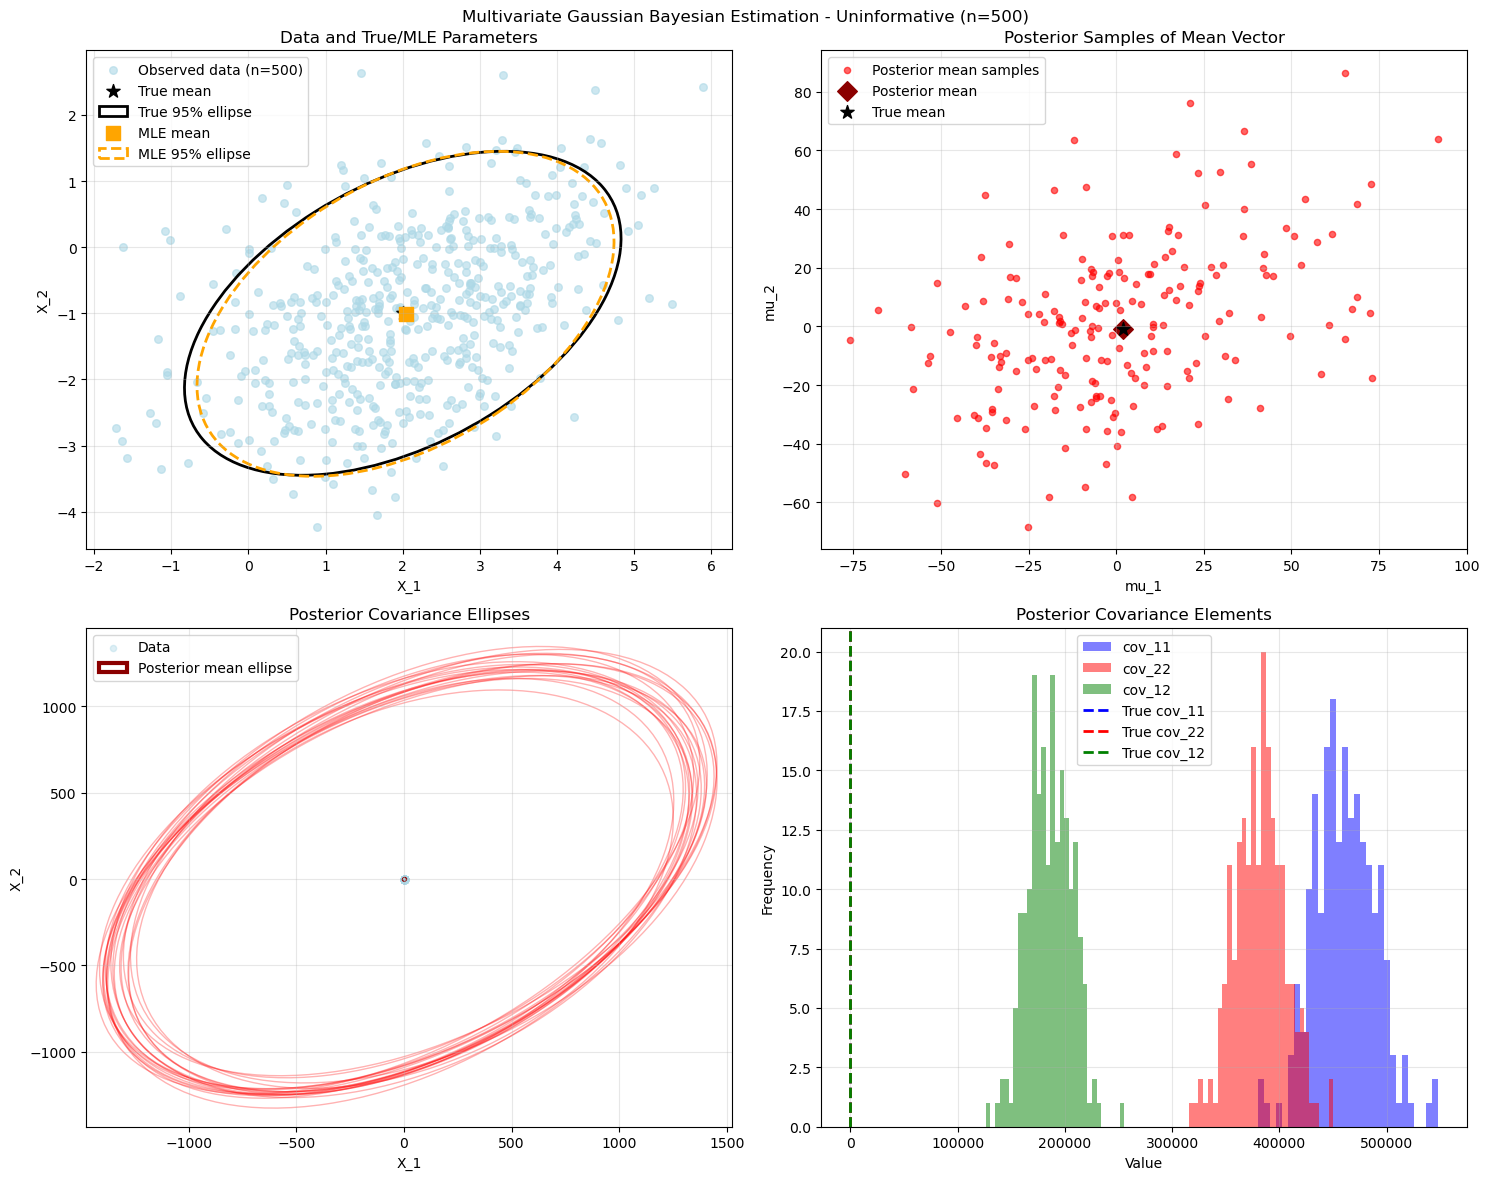

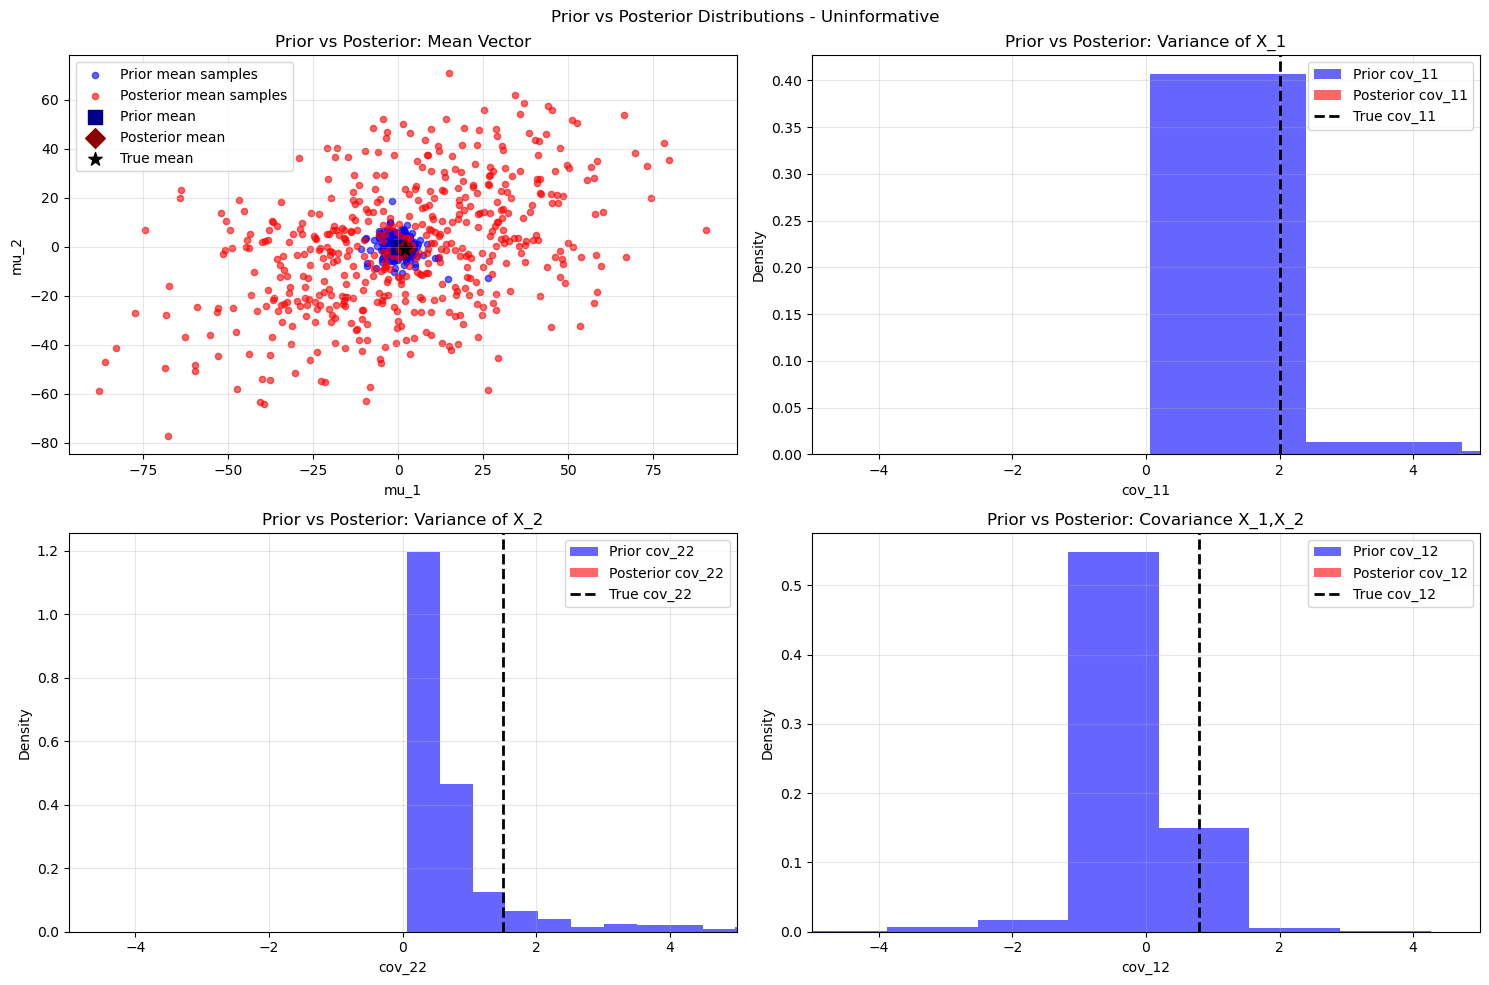


Informative (correct) Prior:
μ₀ = [ 2. -1.], κ₀ = 2.0
Ψ₀ = 
[[2.  0.8]
 [0.8 1.5]]
ν₀ = 6
----------------------------------------
n=  5:
MLE mean = [ 0.93840511 -1.41217292]
Post mean = [ 1.24171793 -1.29440923]
Post cov = 
[[1.15040057 0.73734236]
 [0.73734236 1.08489023]]

n= 50:
MLE mean = [ 1.93076048 -0.91759144]
Post mean = [ 1.93342353 -0.920761  ]
Post cov = 
[[1.73197679 0.79937542]
 [0.79937542 1.31261079]]

n=500:
MLE mean = [ 2.03565742 -1.00848304]
Post mean = [ 2.03551536 -1.00844925]
Post cov = 
[[1.81790537 0.73422474]
 [0.73422474 1.50300371]]



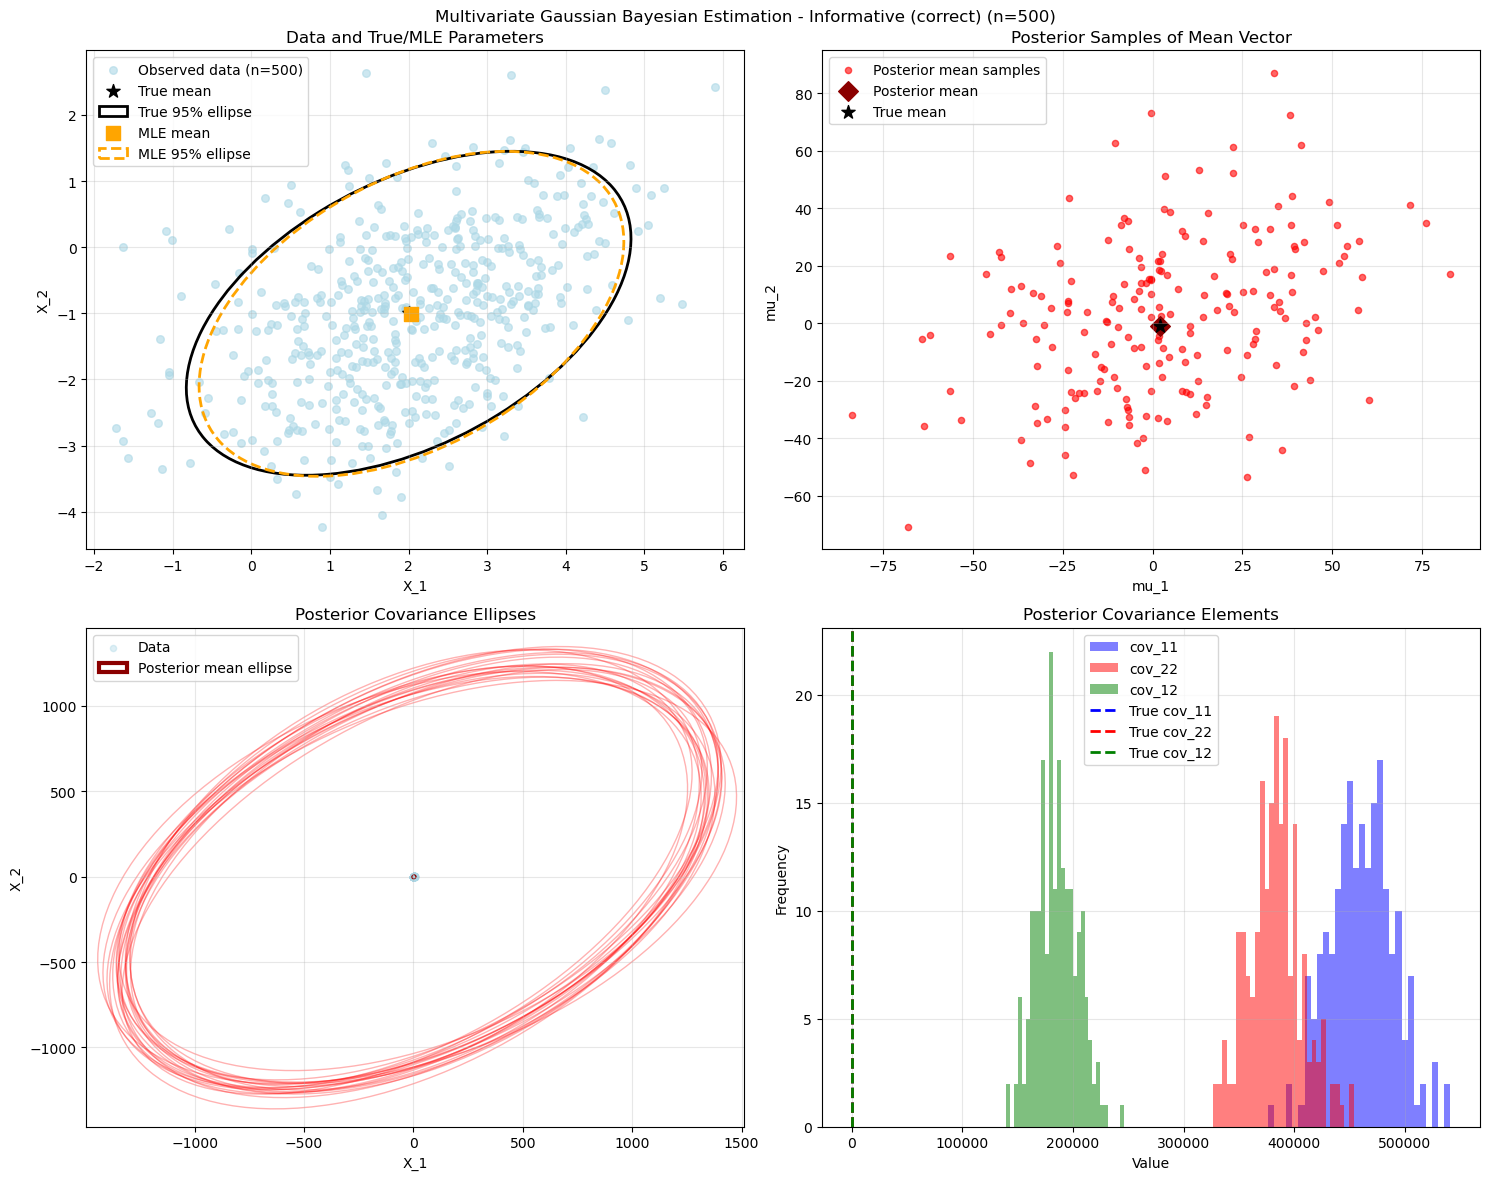

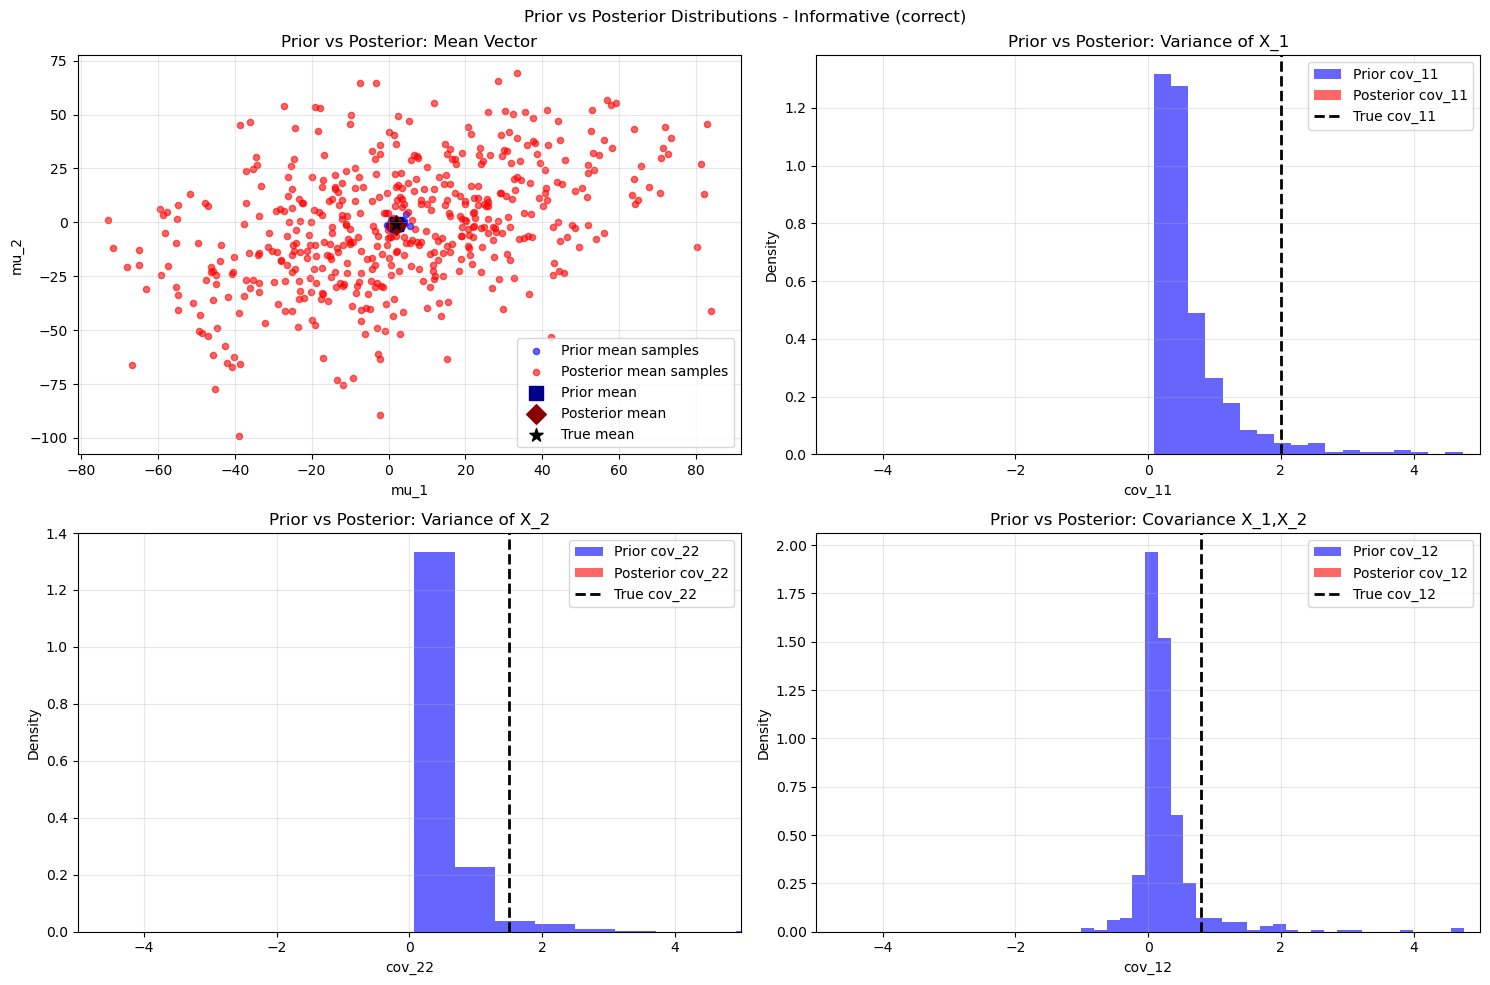


Strong but wrong prior Prior:
μ₀ = [0. 0.], κ₀ = 5.0
Ψ₀ = 
[[0.5 0. ]
 [0.  0.5]]
ν₀ = 8
----------------------------------------
n=  5:
MLE mean = [ 0.93840511 -1.41217292]
Post mean = [ 0.46920255 -0.70608646]
Post cov = 
[[0.82947382 0.11606765]
 [0.11606765 1.24220077]]

n= 50:
MLE mean = [ 1.93076048 -0.91759144]
Post mean = [ 1.7552368  -0.83417404]
Post cov = 
[[1.94964109 0.60954398]
 [0.60954398 1.31604485]]

n=500:
MLE mean = [ 2.03565742 -1.00848304]
Post mean = [ 2.0155024  -0.99849806]
Post cov = 
[[1.84835293 0.70960921]
 [0.70960921 1.50504073]]



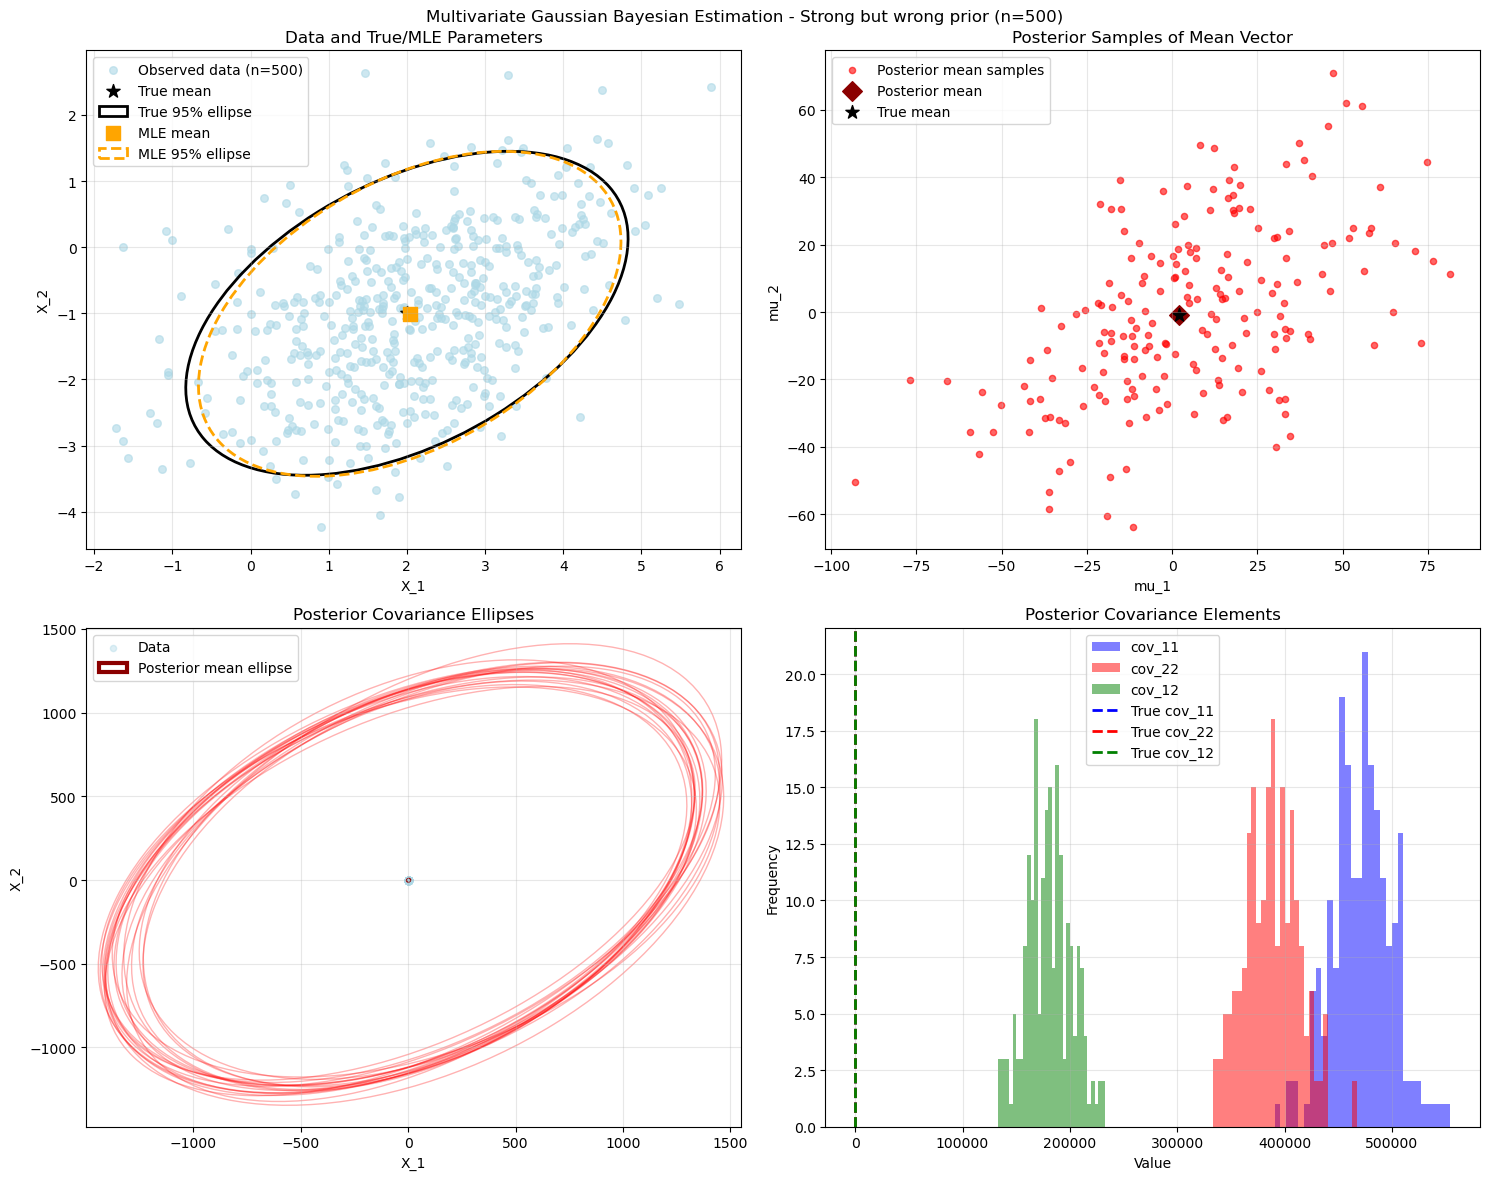

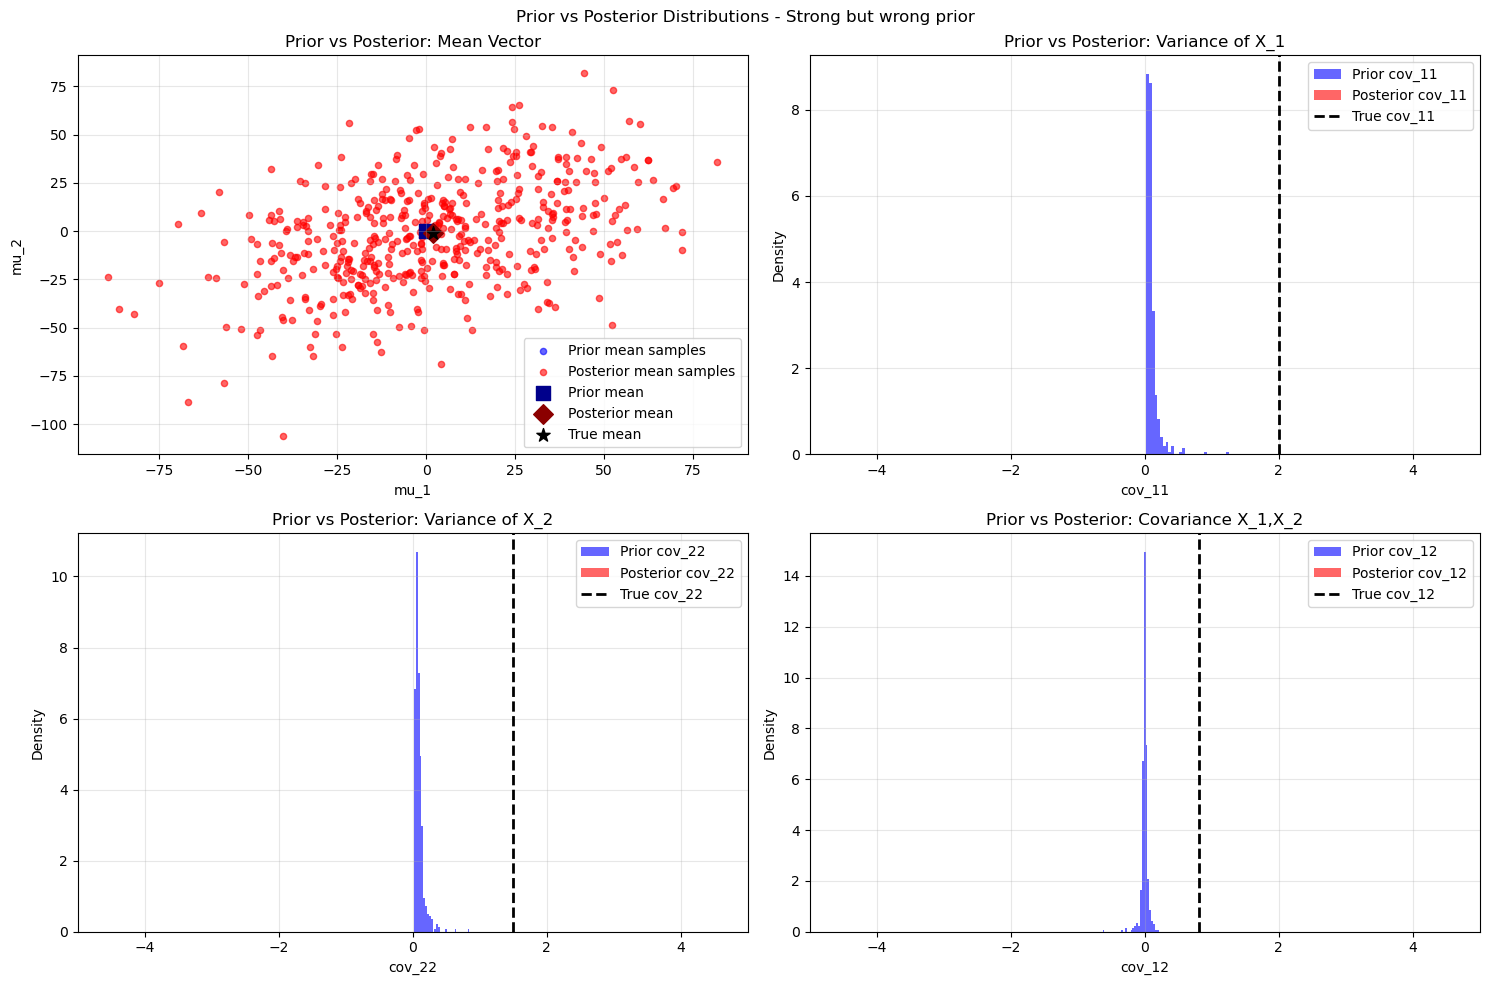

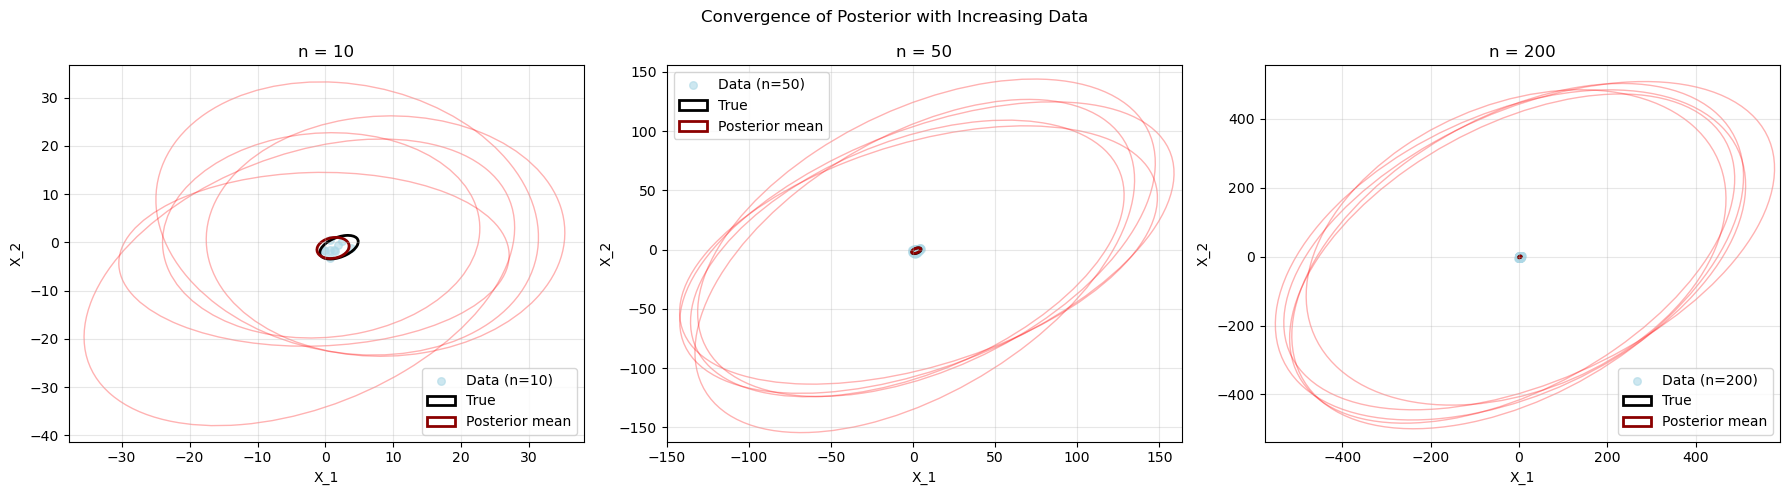

In [23]:
if __name__ == "__main__":
    demonstrate_multivariate_gaussian()

# **PART B**

## **Part B.1**: Probabilistic Linear Regression

In [24]:
class ProbabilisticLinearRegression:
    """
    Bayesian Linear Regression with Gaussian Prior over weights and known noise variance
    """
    def __init__(self, lambda_prior=1.0, noise_variance=1.0):
        self.lambda_prior = lambda_prior     
        self.noise_variance = noise_variance 
        self.beta = 1.0 / noise_variance     

        # posterior parameters
        self.mu_N = None                      
        self.Sigma_N = None                   
        
        self.X = None
        self.y = None
        self.true_weights = None

    def generate_data(self, n_samples, x_range=(-5, 5), true_weights=None):
        """
        generate values of x uniformly in the given range
        y_clean = X @ true_weights
        y = y_clean + noise
        noise comes from Gaussian with 0 mean and known variance
        """
        if true_weights is None:
            true_weights = np.array([1.5, 2.0], dtype=float)
        
        self.true_weights = np.asarray(true_weights, dtype=float)
        
        x_vals = np.linspace(x_range[0], x_range[1], int(n_samples))
        X = np.column_stack([np.ones_like(x_vals), x_vals])
        
        y_clean = X @ self.true_weights
        noise = np.random.normal(0.0, np.sqrt(self.noise_variance), size=X.shape[0])
        y = y_clean + noise
        
        self.X = X
        self.y = y
        return X, y
    
    def update_posterior(self, X=None, y=None):
        """
        Comes from the formulae given in the slides for cov_N, and mu_N
        """
        if X is not None and y is not None:
            self.X = np.asarray(X, dtype=float)
            self.y = np.asarray(y, dtype=float)
            
        if self.X is None or self.y is None:
            raise ValueError("No data provided for posterior update")
        
        n_features = self.X.shape[1]
        
        I = np.eye(n_features)                    
        XtX = self.X.T @ self.X                   
        Xty = self.X.T @ self.y                   
        
        self.Sigma_N = np.linalg.inv(self.lambda_prior * I + self.beta * XtX)
        
        self.mu_N = self.beta * self.Sigma_N @ Xty
        
        return self.mu_N, self.Sigma_N
    
    def get_estimates(self):
        if self.X is None or self.y is None:
            raise ValueError("No data available")
        
        mle_weights, *_ = np.linalg.lstsq(self.X, self.y, rcond=None)
        
        map_weights = self.mu_N
        
        return {
            'MLE': mle_weights,
            'MAP': map_weights,
            'True Weights': self.true_weights,
            'mu_N': self.mu_N,          
            'Sigma_N': self.Sigma_N     
        }
        
    def posterior_predictive(self, X_test):
        if self.mu_N is None or self.Sigma_N is None:
            raise ValueError("Posterior not computed yet")
        
        X_test = np.asarray(X_test, dtype=float)
        if X_test.ndim == 1:
            X_test = X_test[None, :]
        
        pred_mean = X_test @ self.mu_N
        
        epistemic_var = np.sum((X_test @ self.Sigma_N) * X_test, axis=1)
        pred_var = epistemic_var + self.noise_variance
        
        return pred_mean, pred_var
    
    def sample_posterior_weights(self, n_samples=1000):
        if self.mu_N is None or self.Sigma_N is None:
            raise ValueError("Posterior not computed yet")
        
        return np.random.multivariate_normal(self.mu_N, self.Sigma_N, int(n_samples))

In [25]:
def plot_posterior_over_weights(estimator, weight_ranges=None, title_suffix=""):
    if estimator.mu_N is None or estimator.Sigma_N is None:
        raise ValueError("Posterior not computed")
    
    if weight_ranges is None:
        w_mean = estimator.mu_N
        w_std = np.sqrt(np.diag(estimator.Sigma_N))
        weight_ranges = [
            [w_mean[0] - 3*w_std, w_mean + 3*w_std],
            [w_mean[1] - 3*w_std[1], w_mean[1] + 3*w_std[1]]
        ]
    
    w0_range = np.linspace(weight_ranges[0], weight_ranges[1], 100)
    w1_range = np.linspace(weight_ranges[1], weight_ranges[1][1], 100)
    W0, W1 = np.meshgrid(w0_range, w1_range)
    
    pos = np.dstack((W0, W1))
    rv = stats.multivariate_normal(estimator.mu_N, estimator.Sigma_N)
    pdf_values = rv.pdf(pos)
    
    plt.figure(figsize=(10, 8))
    
    plt.contour(W0, W1, pdf_values, levels=10, colors='blue', alpha=0.6)
    contourf = plt.contourf(W0, W1, pdf_values, levels=20, cmap='Blues', alpha=0.3)
    plt.colorbar(contourf, label='Posterior Density p(w|X,y)')
    
    estimates = estimator.get_estimates()
    
    plt.plot(estimates['MAP'][0], estimates['MAP'][1], 'ro', markersize=10,
             label=f"μ_N = [{estimates['MAP'][0]:.3f}, {estimates['MAP'][1]:.3f}]")
    
    plt.plot(estimates['MLE'][0], estimates['MLE'][1], 'go', markersize=10,
             label=f"MLE = [{estimates['MLE'][0]:.3f}, {estimates['MLE'][1]:.3f}]")
    
    if estimates['True Weights'] is not None:
        plt.plot(estimates['True Weights'][0], estimates['True Weights'][1], 
                 'k*', markersize=15,
                 label=f"True = [{estimates['True Weights'][0]:.3f}, {estimates['True Weights'][1]:.3f}]")
    
    plt.xlabel('w_0 (Intercept)')
    plt.ylabel('w_1 (Slope)')
    plt.title(f'Posterior p(w|X,y) = N(μ_N, Σ_N) {title_suffix}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [26]:
def plot_posterior_predictive(estimator, x_test_range=(-4, 4), n_test=100, title_suffix=""):
    if estimator.X is None or estimator.y is None:
        raise ValueError("No training data available")
    
    x_test = np.linspace(x_test_range[0], x_test_range[1], n_test)
    X_test = np.column_stack([np.ones(n_test), x_test])
    
    pred_mean, pred_var = estimator.posterior_predictive(X_test)
    pred_std = np.sqrt(pred_var)
    
    epistemic_var = np.sum((X_test @ estimator.Sigma_N) * X_test, axis=1)
    epistemic_std = np.sqrt(epistemic_var)
    
    plt.figure(figsize=(12, 8))
    
    plt.scatter(estimator.X[:, 1], estimator.y, color='black', alpha=0.7, s=50,
                label=f'Training Data (n={len(estimator.y)})')
    
    if estimator.true_weights is not None:
        y_true = X_test @ estimator.true_weights
        plt.plot(x_test, y_true, 'r-', linewidth=2, label='True Function')
    
    plt.plot(x_test, pred_mean, 'b-', linewidth=2, label='Predictive Mean (X* μ_N)')
    
    plt.fill_between(x_test, pred_mean - 2*pred_std, pred_mean + 2*pred_std,
                     alpha=0.3, color='blue', label='95% Total Uncertainty')
    
    plt.fill_between(x_test, pred_mean - 2*epistemic_std, pred_mean + 2*epistemic_std,
                     alpha=0.4, color='green', label='95% Epistemic (X* Σ_N X*^T)')
    
    weight_samples = estimator.sample_posterior_weights(20)
    for i, w_sample in enumerate(weight_samples[:5]):
        y_sample = X_test @ w_sample
        plt.plot(x_test, y_sample, 'gray', alpha=0.3, linewidth=1)
        if i == 0:
            plt.plot([], [], 'gray', alpha=0.3, linewidth=1, label='Posterior Samples from N(μ_N, Σ_N)')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Posterior Predictive: y* ~ N(X* μ_N, X* Σ_N X*^T + σ²) {title_suffix}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [27]:
def formulae_demonstrate():
    true_weights = np.array([1.5, 2.0])
    n_samples = 30
    
    configs = [
        (0.1, 1.0, "Weak Prior (λ=0.1), Noisy Data (σ²=1.0)"),
        (1.0, 0.25, "Medium Prior (λ=1.0), Clean Data (σ²=0.25)"),
        (10.0, 0.1, "Strong Prior (λ=10.0), Very Clean Data (σ²=0.1)")
    ]
    
    base_estimator = ProbabilisticLinearRegression(lambda_prior=1.0, noise_variance=0.5)
    X, y = base_estimator.generate_data(n_samples, true_weights=true_weights)
    
    for lambda_val, sigma2_val, config_name in configs:
        print(f"\n{config_name}")
        print(f"λ = {lambda_val}, β = 1/σ² = {1/sigma2_val:.2f}")
        print("-" * 40)
        
        estimator = ProbabilisticLinearRegression(lambda_prior=lambda_val, 
                                                 noise_variance=sigma2_val)
        estimator.true_weights = true_weights
        estimator.update_posterior(X, y)
        
        estimates = estimator.get_estimates()
        posterior_std = np.sqrt(np.diag(estimator.Sigma_N))
        
        print(f"μ_N = [{estimates['mu_N'][0]:.3f}, {estimates['mu_N'][1]:.3f}]")
        print(f"diag(Σ_N)^0.5 = [{posterior_std[0]:.3f}, {posterior_std[1]:.3f}]")
        print(f"MLE = [{estimates['MLE'][0]:.3f}, {estimates['MLE'][1]:.3f}]")
        
        plot_posterior_over_weights(estimator, title_suffix=f"- {config_name}")
        plot_posterior_predictive(estimator, title_suffix=f"- {config_name}")

In [28]:
def data_size_effects_demo():
    true_weights = np.array([1.5, 2.0])
    lambda_val = 1.0    
    sigma2_val = 0.5    
    data_sizes = [5, 20, 100]
    
    print(f"Fixed hyperparameters: λ = {lambda_val}, σ² = {sigma2_val}")
    print(f"True weights: {true_weights}\n")
    
    results = []
    
    for n in data_sizes:
        print(f"Data size n = {n}")
        print("-" * 20)
        
        estimator = ProbabilisticLinearRegression(lambda_prior=lambda_val, 
                                                 noise_variance=sigma2_val)
        X, y = estimator.generate_data(n, true_weights=true_weights)
        estimator.update_posterior()
        
        estimates = estimator.get_estimates()
        posterior_std = np.sqrt(np.diag(estimator.Sigma_N))
        
        print(f"μ_N = [{estimates['mu_N'][0]:.3f}, {estimates['mu_N'][1]:.3f}]")
        print(f"Posterior std = [{posterior_std[0]:.3f}, {posterior_std[1]:.3f}]")
        print()
        
        results.append({
            'n': n,
            'estimator': estimator,
            'posterior_std': posterior_std
        })
        
        plot_posterior_over_weights(estimator, title_suffix=f"(n={n})")
        plot_posterior_predictive(estimator, title_suffix=f"(n={n})")
    
    return results


Weak Prior (λ=0.1), Noisy Data (σ²=1.0)
λ = 0.1, β = 1/σ² = 1.00
----------------------------------------
μ_N = [1.546, 2.016]
diag(Σ_N)^0.5 = [0.182, 0.061]
MLE = [1.551, 2.017]


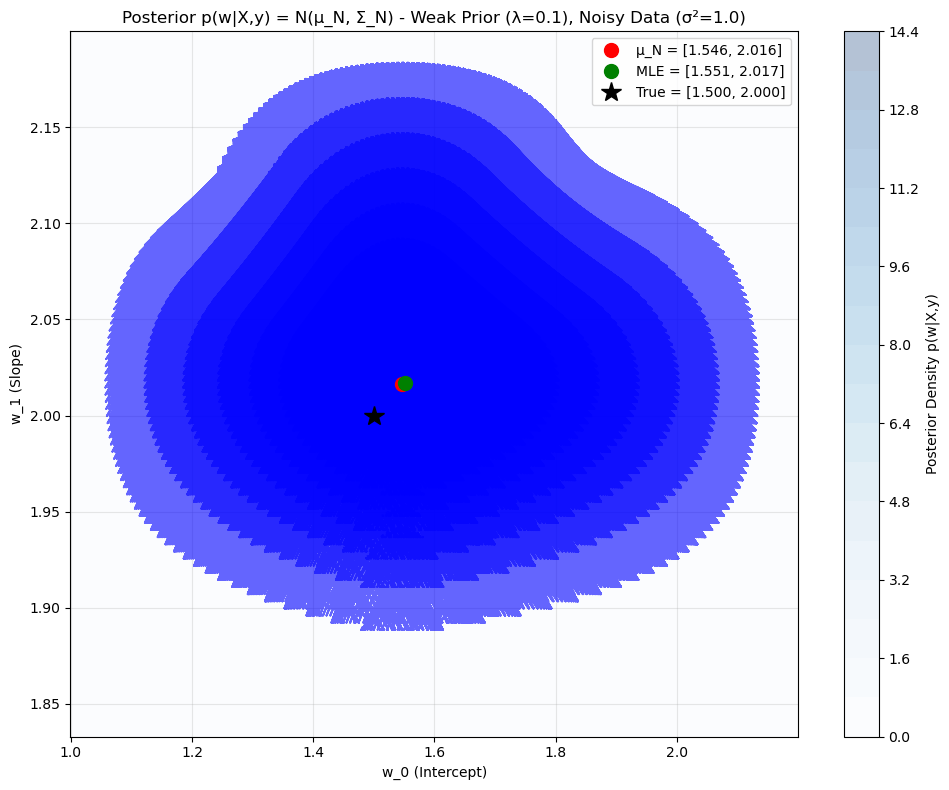

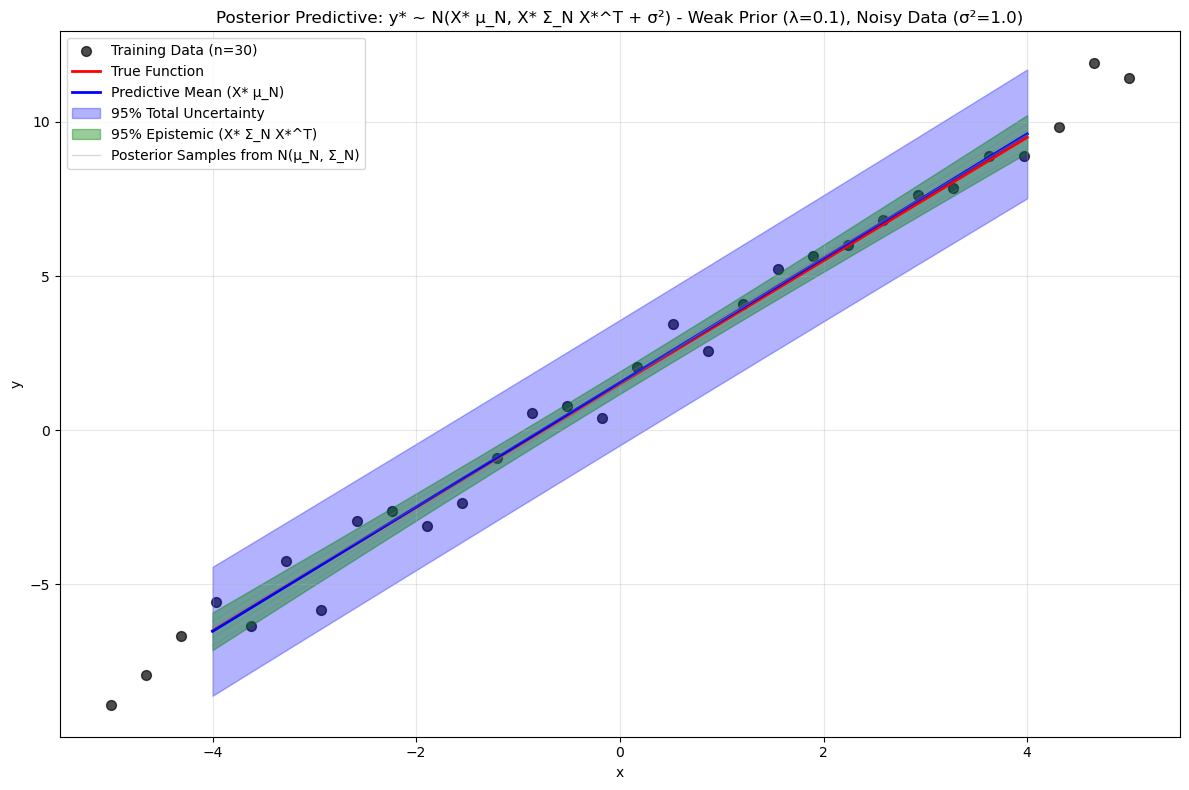


Medium Prior (λ=1.0), Clean Data (σ²=0.25)
λ = 1.0, β = 1/σ² = 4.00
----------------------------------------
μ_N = [1.538, 2.015]
diag(Σ_N)^0.5 = [0.091, 0.031]
MLE = [1.551, 2.017]


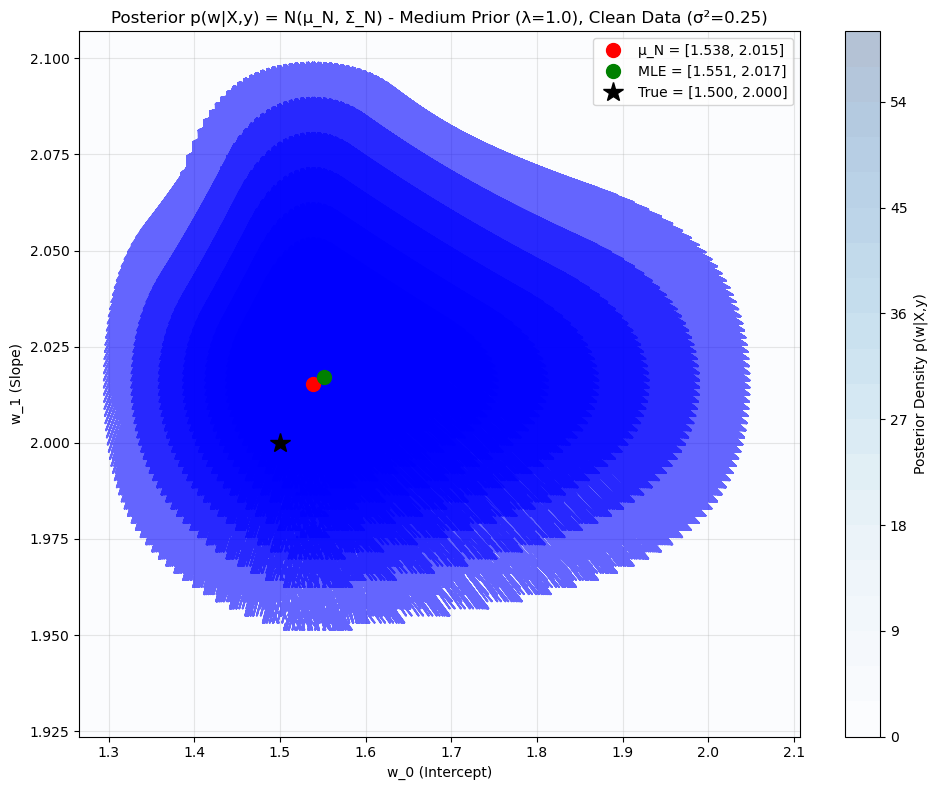

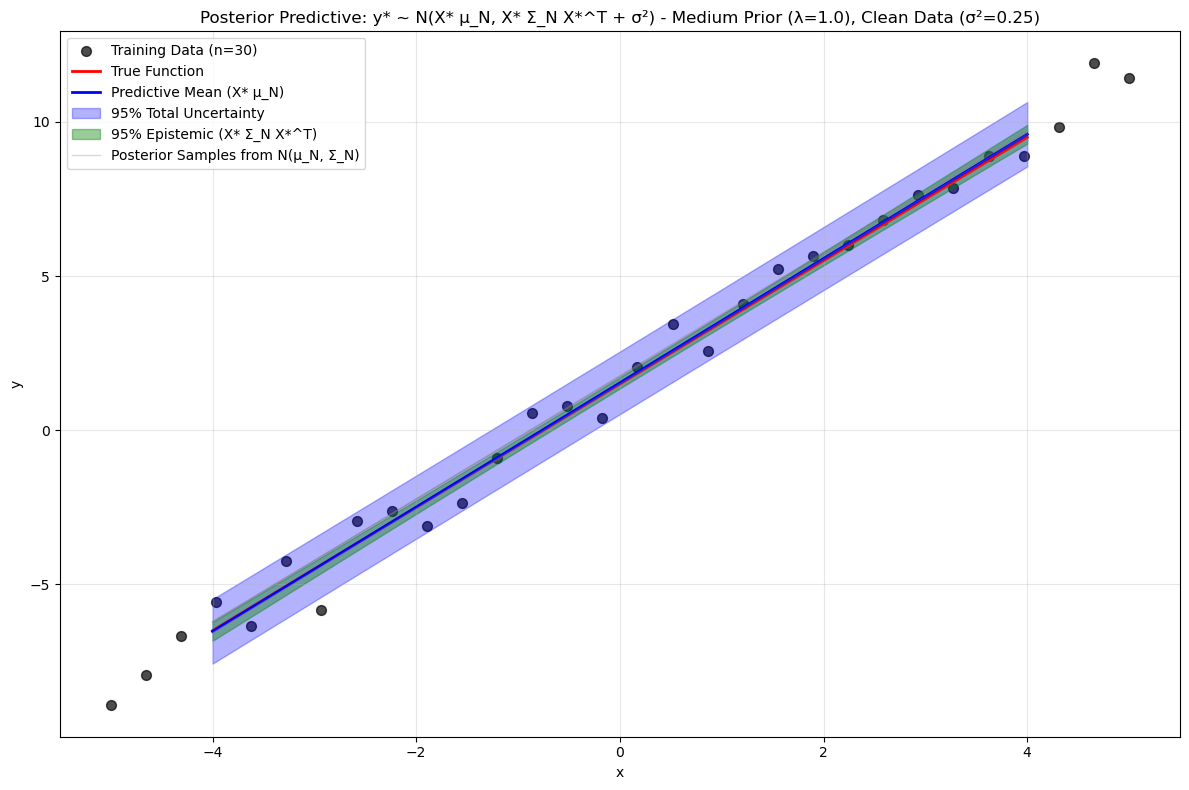


Strong Prior (λ=10.0), Very Clean Data (σ²=0.1)
λ = 10.0, β = 1/σ² = 10.00
----------------------------------------
μ_N = [1.501, 2.010]
diag(Σ_N)^0.5 = [0.057, 0.019]
MLE = [1.551, 2.017]


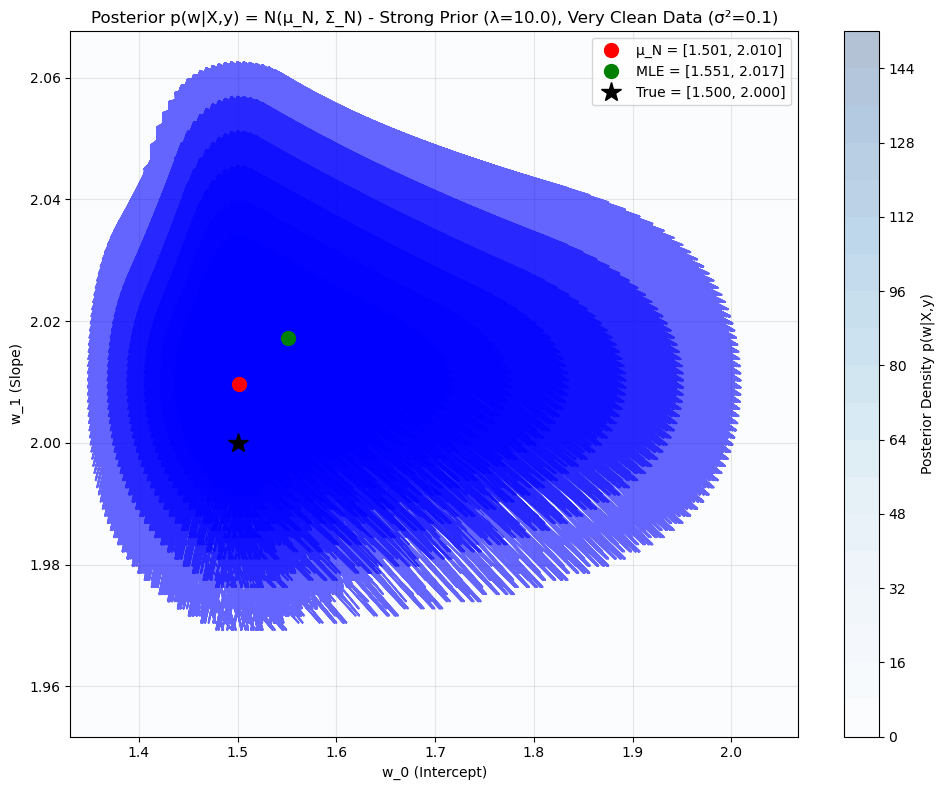

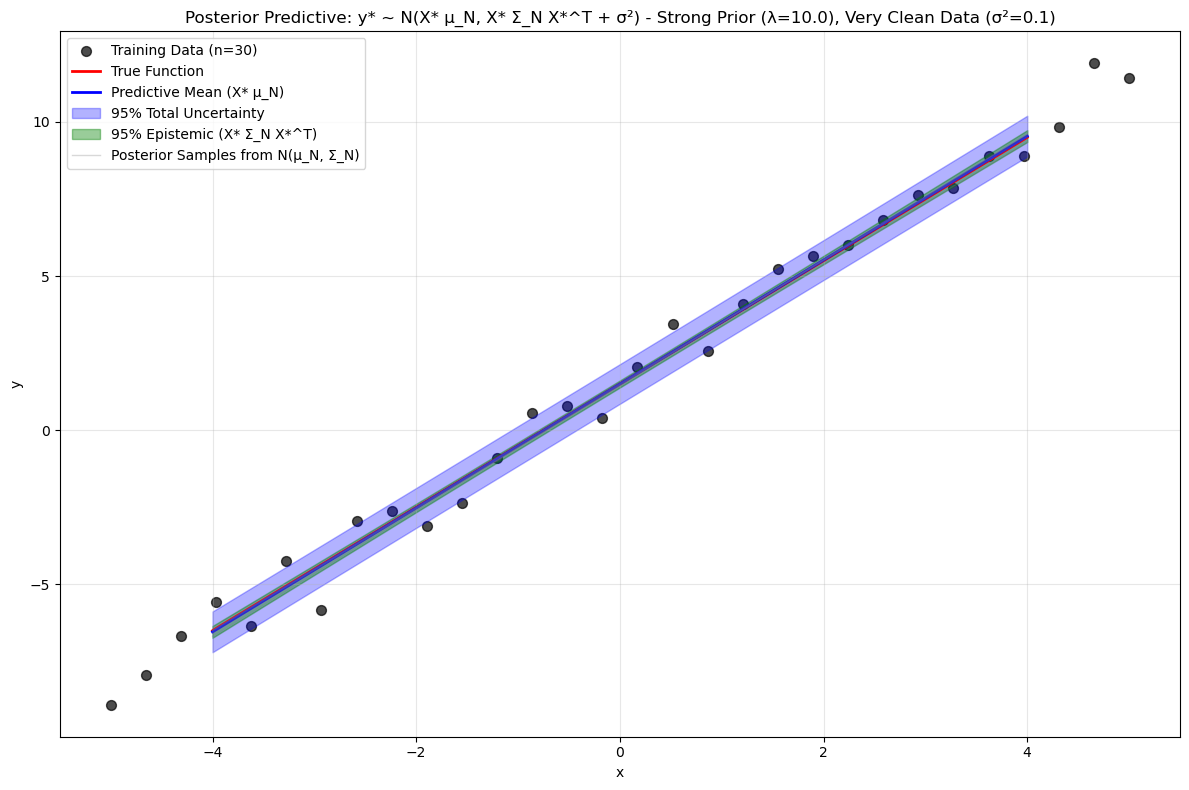

Fixed hyperparameters: λ = 1.0, σ² = 0.5
True weights: [1.5 2. ]

Data size n = 5
--------------------
μ_N = [1.594, 2.027]
Posterior std = [0.302, 0.089]



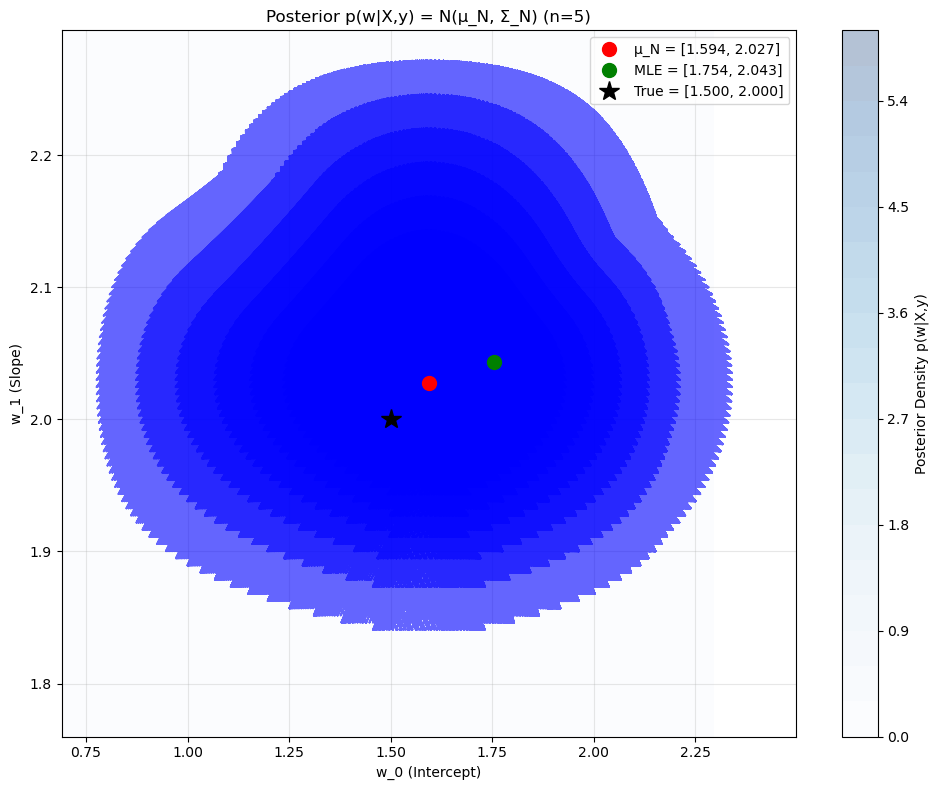

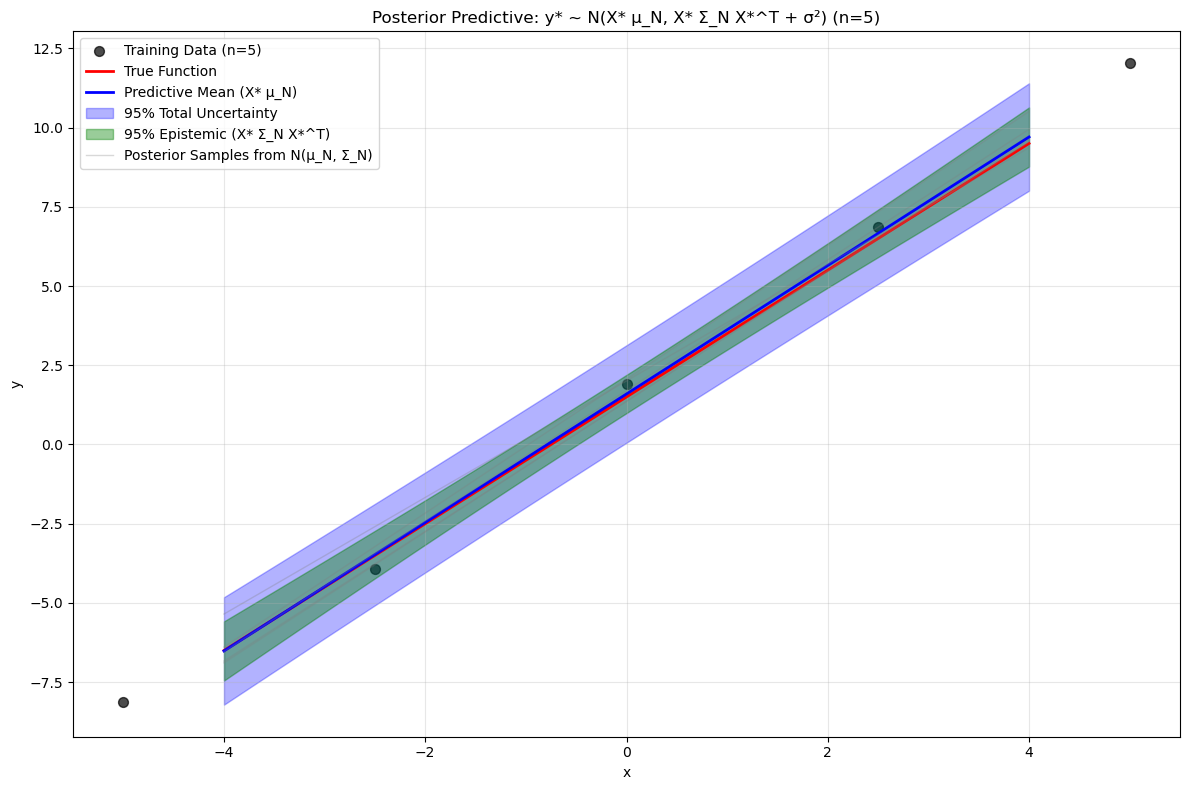

Data size n = 20
--------------------
μ_N = [1.538, 1.922]
Posterior std = [0.156, 0.052]



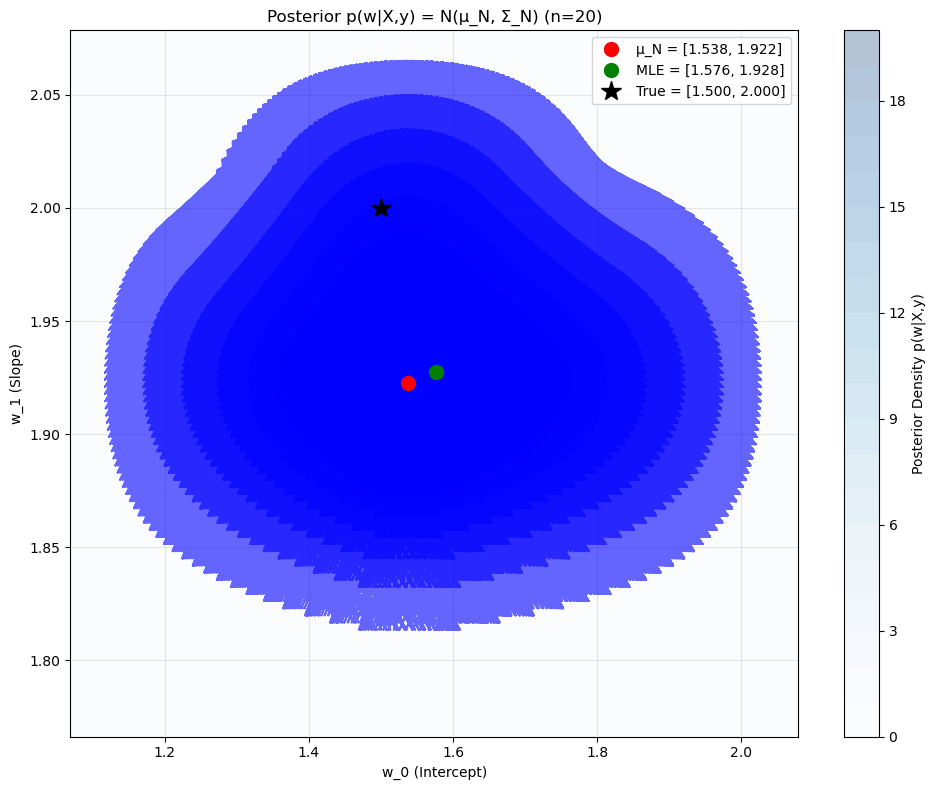

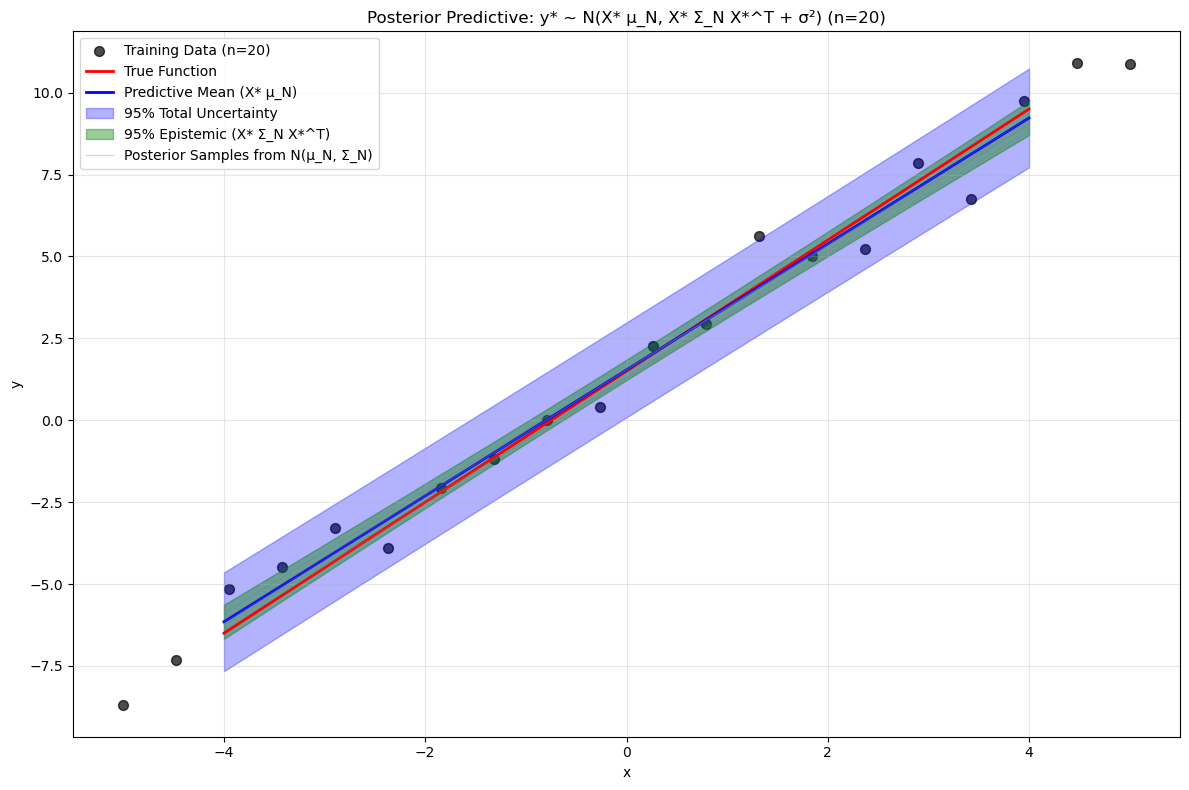

Data size n = 100
--------------------
μ_N = [1.450, 2.032]
Posterior std = [0.071, 0.024]



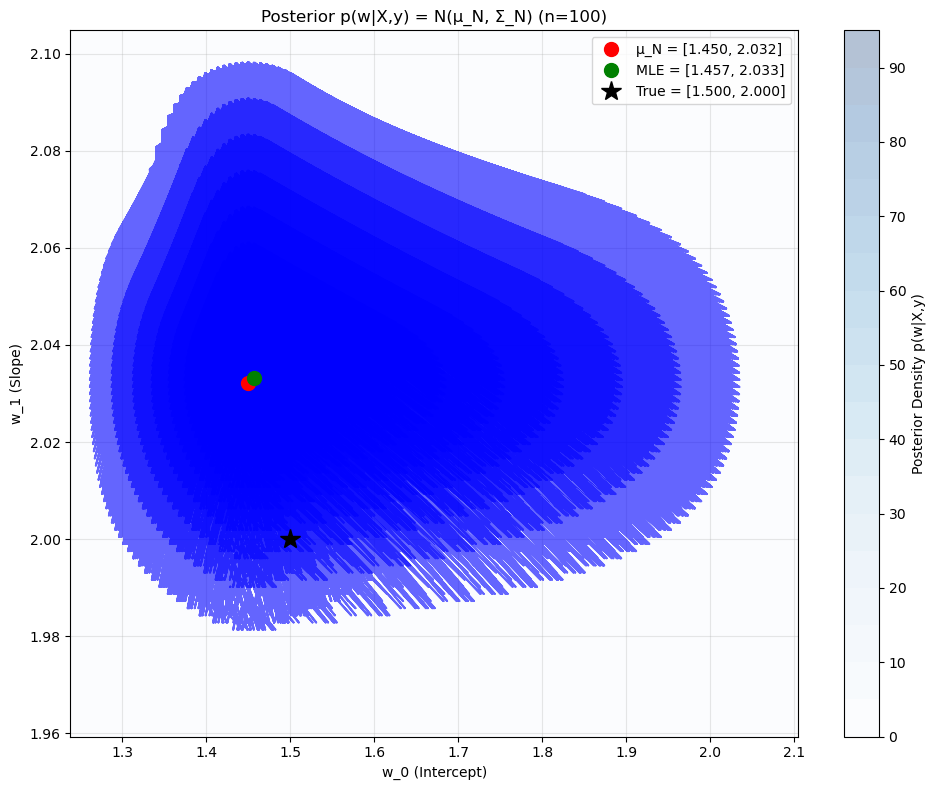

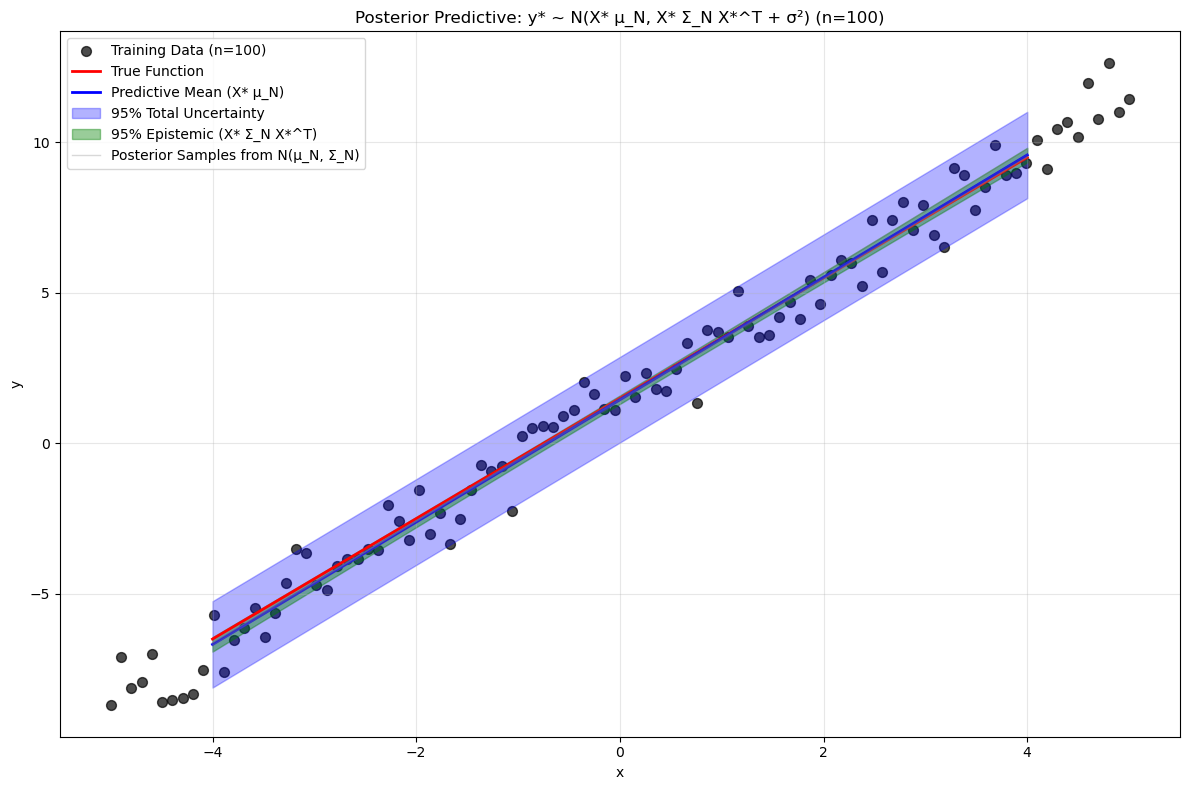

In [29]:
if __name__ == "__main__":
    formulae_demonstrate()
    results = data_size_effects_demo()

## **Part B.2**: Binary Logistic Regression

In [30]:
class BayesianBinaryLogisticRegression:
    """
    The posterior in this case is intractable, so we do a monte carlo sampling for the posterior extraction
    """
    def __init__(self, lambda_prior=1.0):
        self.lambda_prior = lambda_prior    
        
        self.w_MAP = None                   
        self.Lambda = None                  
        self.posterior_cov = None           
        
        self.X = None
        self.y = None
        self.true_weights = None
        
    def sigmoid(self, z):
        z = np.clip(z, -250, 250) # to prevent overflow
        return 1.0 / (1.0 + np.exp(-z))
    
    def generate_data(self, n_samples, n_features = 2, class_sep = 1.5, noise = 0.1, seed = None):
        if seed is not None:
            np.random.seed(seed)
        
        X_raw, y = make_classification(
            n_samples=n_samples,
            n_features=n_features,
            n_informative=n_features,
            n_redundant=0,
            n_clusters_per_class=1,
            n_classes=2,
            flip_y=noise,
            class_sep=class_sep,
            random_state=seed
        )
        
        X = np.column_stack([np.ones(n_samples), X_raw])
        y = y.astype(float)
        
        self.X = X
        self.y = y
        
        self.true_weights = np.random.normal(0, 1, X.shape[1])
        
        return X, y
        
    def negative_log_likelihood(self, w):
        mu = self.sigmoid(self.X @ w)
        mu = np.clip(mu, 1e-15, 1 - 1e-15)  
        log_likelihood = np.sum(self.y * np.log(mu) + (1 - self.y) * np.log(1 - mu))
        return -log_likelihood
    
    def negative_log_prior(self, w):
        return 0.5 * self.lambda_prior * np.sum(w**2)
    
    def negative_log_posterior(self, w):
        return self.negative_log_likelihood(w) + self.negative_log_prior(w)
    
    def gradient_negative_log_posterior(self, w):
        mu = self.sigmoid(self.X @ w)
        mu = np.clip(mu, 1e-15, 1 - 1e-15)
        grad_likelihood = self.X.T @ (mu - self.y)
        grad_prior = self.lambda_prior * w
        return grad_likelihood + grad_prior
    
    def hessian_negative_log_posterior(self, w):
        mu = self.sigmoid(self.X @ w)
        mu = np.clip(mu, 1e-15, 1 - 1e-15)
        W = np.diag(mu * (1 - mu))
        
        heissan_likelihood = self.X.T @ W @ self.X
        heissan_prior = self.lambda_prior * np.eye(len(w))
        
        return heissan_likelihood + heissan_prior
    
    def fit_laplace_approximation(self, maxiter = 100, method = 'Newton-CG'):
        if self.X is None or self.y is None:
            raise ValueError("No data available to fit the model")
        
        n_features = self.X.shape[1]
        result = minimize(
            fun = self.negative_log_posterior,
            x0 = np.zeros(n_features),
            jac = self.gradient_negative_log_posterior,
            hess = self.hessian_negative_log_posterior,
            method = method,
            options = {'maxiter': maxiter, 'disp': False}
        )
        
        if not result.success:
            print("Optimization failed:", result.message)
            
        self.w_MAP = result.x
        self.Lambda = self.hessian_negative_log_posterior(self.w_MAP)
        
        try:
            self.posterior_cov = np.linalg.inv(self.Lambda)
        except np.linalg.LinAlgError:
            self.posterior_cov = np.linalg.pinv(self.Lambda)
            print("Using pseudo-inverse for posterior covariance.")
            
        return self.w_MAP, self.posterior_cov
    
    def get_estimates(self):
        if self.X is None or self.y is None:
            raise ValueError("No data available to get estimates")
        
        # MLE using sklearn (no regularization)
        clf = LogisticRegression(fit_intercept = False, solver = 'lbfgs', max_iter = 1000, C = 1e10)
        clf.fit(self.X, self.y)
        mle_weights = clf.coef_[0]
        map_weights = self.w_MAP
        
        return{
            'MLE': mle_weights,
            'MAP': map_weights,
            'w_MAP': self.w_MAP,           
            'Lambda': self.Lambda,         
            'True_Weights': self.true_weights
        }
        
    def sample_posterior(self, n_samples = 1000):
        if self.w_MAP is None or self.posterior_cov is None:
            raise ValueError("Posterior not computed yet")
        
        return np.random.multivariate_normal(self.w_MAP, self.posterior_cov, n_samples)
    
    def predict_proba(self, X_new, use_samples = False, n_samples = 100):
        if use_samples:
            weight_samples = self.sample_posterior(n_samples)
            probas = []
            for w in weight_samples:
                p = self.sigmoid(X_new @ w)
                probas.append(p)
            return np.array(probas)
        else:
            return self.sigmoid(X_new @ self.w_MAP)

In [31]:
def plot_decision_boundary_with_uncertainty(estimator, n_grid=100, n_samples=50, title_suffix=""):
    if estimator.X is None or estimator.y is None:
        raise ValueError("No data to plot")
    
    # Create grid for visualization
    x1_min, x1_max = estimator.X[:, 1].min() - 1, estimator.X[:, 1].max() + 1
    x2_min, x2_max = estimator.X[:, 2].min() - 1, estimator.X[:, 2].max() + 1
    
    xx1, xx2 = np.meshgrid(
        np.linspace(x1_min, x1_max, n_grid),
        np.linspace(x2_min, x2_max, n_grid)
    )
    
    grid_points = np.column_stack([
        np.ones(xx1.ravel().shape[0]),
        xx1.ravel(),
        xx2.ravel()
    ])
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    
    proba_map = estimator.predict_proba(grid_points, use_samples=False)
    Z_map = proba_map.reshape(xx1.shape)
    
    plt.contourf(xx1, xx2, Z_map, levels=50, cmap='RdBu', alpha=0.6)
    plt.colorbar(label='P(Class=1 | w_MAP)')
    plt.contour(xx1, xx2, Z_map, levels=[0.5], colors='black', linewidths=2)
    
    plt.scatter(estimator.X[estimator.y == 0, 1], estimator.X[estimator.y == 0, 2], 
                c='blue', marker='o', s=50, alpha=0.7, label='Class 0')
    plt.scatter(estimator.X[estimator.y == 1, 1], estimator.X[estimator.y == 1, 2], 
                c='red', marker='s', s=50, alpha=0.7, label='Class 1')
    
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(f'MAP Decision Boundary {title_suffix}')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    
    weight_samples = estimator.sample_posterior(n_samples)
    for i, w_sample in enumerate(weight_samples[:20]):
        z_sample = grid_points @ w_sample
        plt.contour(xx1, xx2, z_sample.reshape(xx1.shape), levels=[0], 
                   colors='gray', alpha=0.3, linewidths=1)
    
    plt.scatter(estimator.X[estimator.y == 0, 1], estimator.X[estimator.y == 0, 2], 
                c='blue', marker='o', s=50, alpha=0.7, label='Class 0')
    plt.scatter(estimator.X[estimator.y == 1, 1], estimator.X[estimator.y == 1, 2], 
                c='red', marker='s', s=50, alpha=0.7, label='Class 1')
    
    plt.contour(xx1, xx2, Z_map, levels=[0.5], colors='black', linewidths=3)
    
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(f'Posterior Sample Boundaries {title_suffix}')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    
    probas_samples = estimator.predict_proba(grid_points, use_samples=True, n_samples=n_samples)
    proba_std = np.std(probas_samples, axis=0)  
    
    Z_std = proba_std.reshape(xx1.shape)
    
    plt.contourf(xx1, xx2, Z_std, levels=20, cmap='viridis', alpha=0.8)
    plt.colorbar(label='Prediction Std')
    
    plt.scatter(estimator.X[estimator.y == 0, 1], estimator.X[estimator.y == 0, 2], 
                c='blue', marker='o', s=50, alpha=0.7, label='Class 0')
    plt.scatter(estimator.X[estimator.y == 1, 1], estimator.X[estimator.y == 1, 2], 
                c='red', marker='s', s=50, alpha=0.7, label='Class 1')
    
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(f'Prediction Uncertainty {title_suffix}')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [32]:
def compare_with_mle(estimator, title_suffix=""):
    if estimator.X is None or estimator.y is None:
        raise ValueError("No data to compare")
    
    x1_min, x1_max = estimator.X[:, 1].min() - 1, estimator.X[:, 1].max() + 1
    x2_min, x2_max = estimator.X[:, 2].min() - 1, estimator.X[:, 2].max() + 1
    
    xx1, xx2 = np.meshgrid(
        np.linspace(x1_min, x1_max, 100),
        np.linspace(x2_min, x2_max, 100)
    )
    
    grid_points = np.column_stack([
        np.ones(xx1.ravel().shape[0]),
        xx1.ravel(),
        xx2.ravel()
    ])
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    
    clf = LogisticRegression(fit_intercept=False, solver='lbfgs', max_iter=1000, C=1e10)
    clf.fit(estimator.X, estimator.y)
    Z_mle = clf.predict_proba(grid_points)[:, 1].reshape(xx1.shape)
    
    plt.contourf(xx1, xx2, Z_mle, levels=50, cmap='RdBu', alpha=0.6)
    plt.colorbar(label='P(Class=1)')
    plt.contour(xx1, xx2, Z_mle, levels=[0.5], colors='black', linewidths=2)
    
    plt.scatter(estimator.X[estimator.y == 0, 1], estimator.X[estimator.y == 0, 2], 
                c='blue', marker='o', s=50, alpha=0.7, label='Class 0')
    plt.scatter(estimator.X[estimator.y == 1, 1], estimator.X[estimator.y == 1, 2], 
                c='red', marker='s', s=50, alpha=0.7, label='Class 1')
    
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(f'MLE (No Regularization) {title_suffix}')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    
    Z_map = estimator.predict_proba(grid_points, use_samples=False).reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z_map, levels=50, cmap='RdBu', alpha=0.6)
    plt.colorbar(label='P(Class=1)')
    plt.contour(xx1, xx2, Z_map, levels=[0.5], colors='black', linewidths=2)
    
    plt.scatter(estimator.X[estimator.y == 0, 1], estimator.X[estimator.y == 0, 2], 
                c='blue', marker='o', s=50, alpha=0.7, label='Class 0')
    plt.scatter(estimator.X[estimator.y == 1, 1], estimator.X[estimator.y == 1, 2], 
                c='red', marker='s', s=50, alpha=0.7, label='Class 1')
    
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(f'MAP with Prior (λ={estimator.lambda_prior}) {title_suffix}')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    estimates = estimator.get_estimates()
    print(f"\nWeight Comparison (λ = {estimator.lambda_prior}):")
    print(f"MLE weights: {estimates['MLE']}")
    print(f"MAP weights: {estimates['MAP']}")
    print(f"Difference:  {estimates['MAP'] - estimates['MLE']}")
    print(f"||w_MAP||:  {np.linalg.norm(estimates['MAP']):.4f}")
    print(f"||w_MLE||:  {np.linalg.norm(estimates['MLE']):.4f}")

In [33]:
def logistic_regression_probabilistic():
    lambda_values = [0.1, 1.0, 10.0]
    
    np.random.seed(13)
    base_estimator = BayesianBinaryLogisticRegression()
    X, y = base_estimator.generate_data(n_samples=100, class_sep=1.2)
    
    for lambda_val in lambda_values:
        print(f"\nPrior precision λ = {lambda_val}")
        print(f"Prior: p(w) = N(0, {1/lambda_val:.1f}I)")
        print("-" * 40)
        
        estimator = BayesianBinaryLogisticRegression(lambda_prior=lambda_val)
        estimator.X = X
        estimator.y = y
        
        estimator.fit_laplace_approximation()
        
        estimates = estimator.get_estimates()
        posterior_std = np.sqrt(np.diag(estimator.posterior_cov))
        
        print(f"w_MAP = {estimates['w_MAP']}")
        print(f"Posterior std = {posterior_std}")
        print(f"||w_MAP|| = {np.linalg.norm(estimates['w_MAP']):.4f}")
        
        plot_decision_boundary_with_uncertainty(estimator, title_suffix=f"(λ={lambda_val})")
        compare_with_mle(estimator, title_suffix=f"(λ={lambda_val})")

In [34]:
def demonstrate_data_size_effect():
    data_sizes = [20, 100, 500]
    lambda_val = 1.0
    
    np.random.seed(13)
    base_estimator = BayesianBinaryLogisticRegression()
    X_full, y_full = base_estimator.generate_data(n_samples=max(data_sizes), class_sep=1.0)
    
    for n in data_sizes:
        print(f"\nData size: n = {n}")
        print(f"Prior: p(w) = N(0, {1/lambda_val}I)")
        print("-" * 30)
        
        X_subset = X_full[:n]
        y_subset = y_full[:n]
        
        estimator = BayesianBinaryLogisticRegression(lambda_prior=lambda_val)
        estimator.X = X_subset
        estimator.y = y_subset
        estimator.fit_laplace_approximation()
        
        posterior_std = np.sqrt(np.diag(estimator.posterior_cov))
        print(f"w_MAP = {estimator.w_MAP}")
        print(f"Posterior std = {posterior_std}")
        print(f"Total uncertainty = {np.sum(posterior_std):.4f}")
        
        plot_decision_boundary_with_uncertainty(estimator, title_suffix=f"(n={n})")


Prior precision λ = 0.1
Prior: p(w) = N(0, 10.0I)
----------------------------------------
w_MAP = [-0.88293595  0.51226995  2.11149313]
Posterior std = [0.44709497 0.36207817 0.35436707]
||w_MAP|| = 2.3453


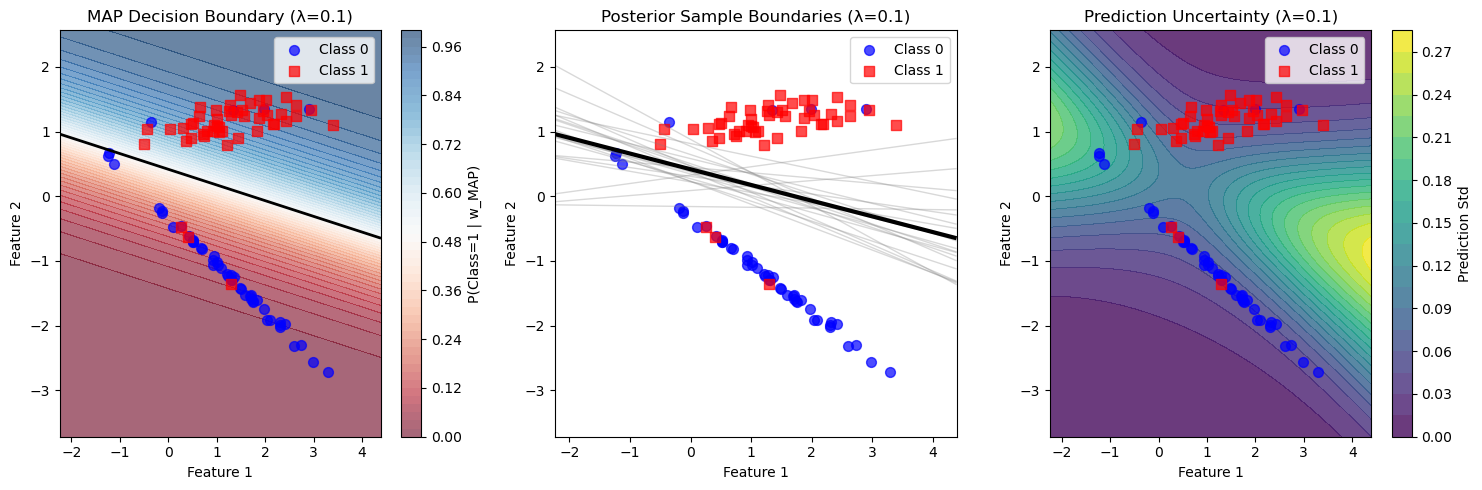

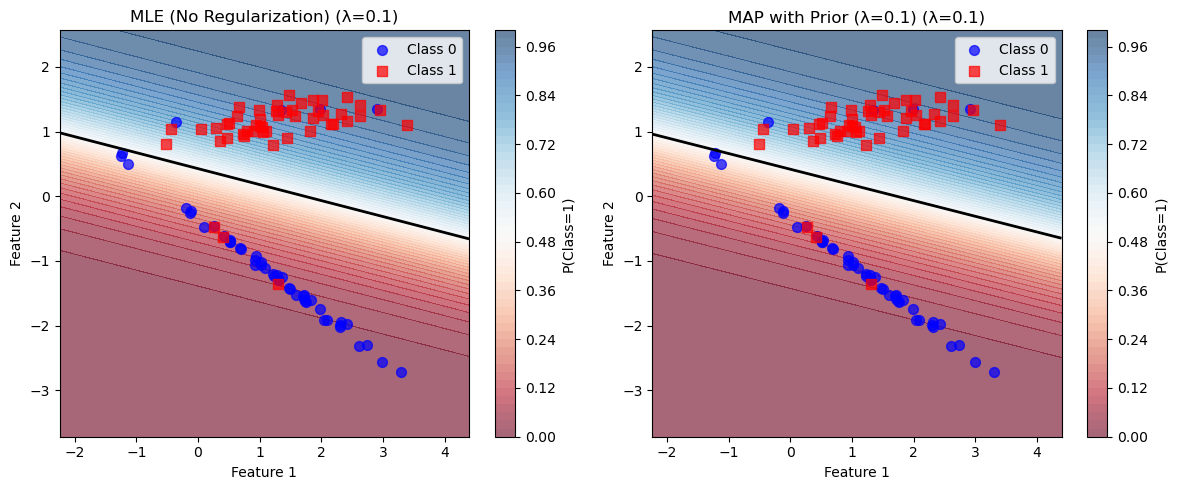


Weight Comparison (λ = 0.1):
MLE weights: [-0.91790675  0.52985537  2.14436686]
MAP weights: [-0.88293595  0.51226995  2.11149313]
Difference:  [ 0.0349708  -0.01758542 -0.03287373]
||w_MAP||:  2.3453
||w_MLE||:  2.3920

Prior precision λ = 1.0
Prior: p(w) = N(0, 1.0I)
----------------------------------------
w_MAP = [-0.66838265  0.40220949  1.89534691]
Posterior std = [0.38547442 0.3118195  0.29986352]
||w_MAP|| = 2.0496


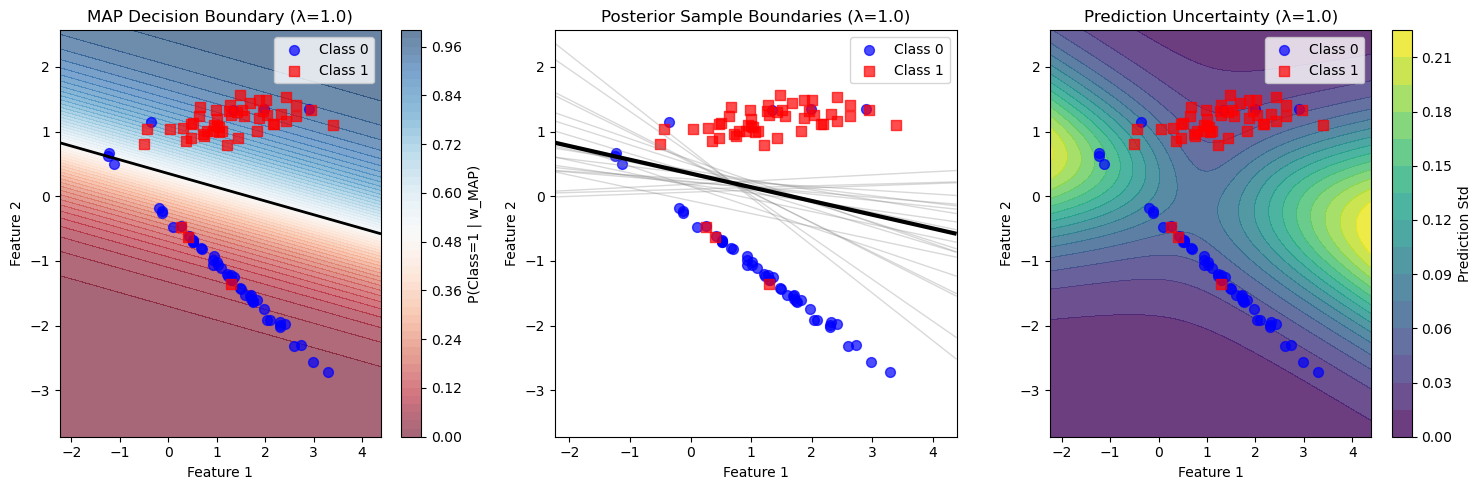

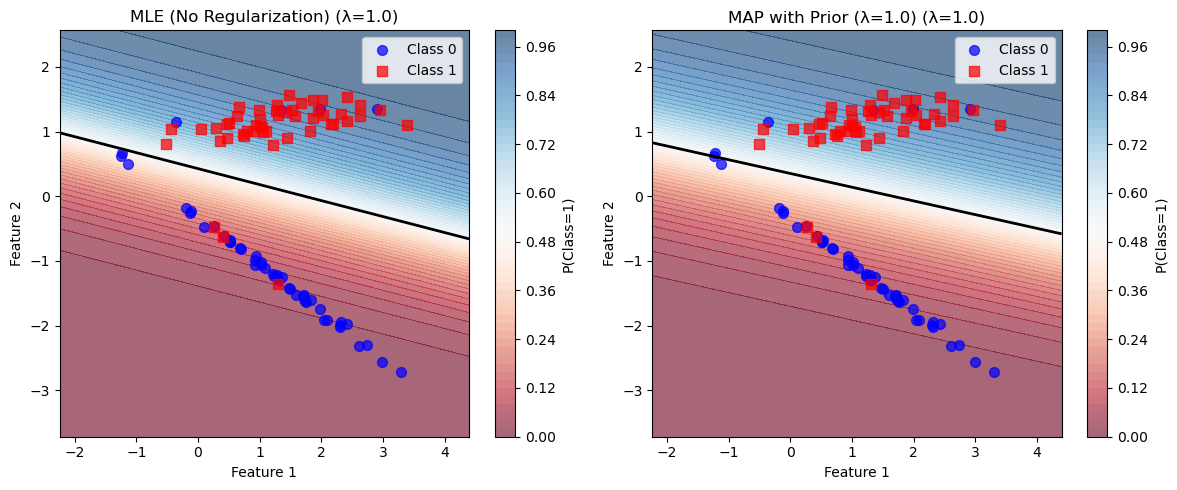


Weight Comparison (λ = 1.0):
MLE weights: [-0.91790675  0.52985537  2.14436686]
MAP weights: [-0.66838265  0.40220949  1.89534691]
Difference:  [ 0.2495241  -0.12764588 -0.24901995]
||w_MAP||:  2.0496
||w_MLE||:  2.3920

Prior precision λ = 10.0
Prior: p(w) = N(0, 0.1I)
----------------------------------------
w_MAP = [-0.19338814  0.14586159  1.19133136]
Posterior std = [0.22809257 0.18132733 0.17982622]
||w_MAP|| = 1.2157


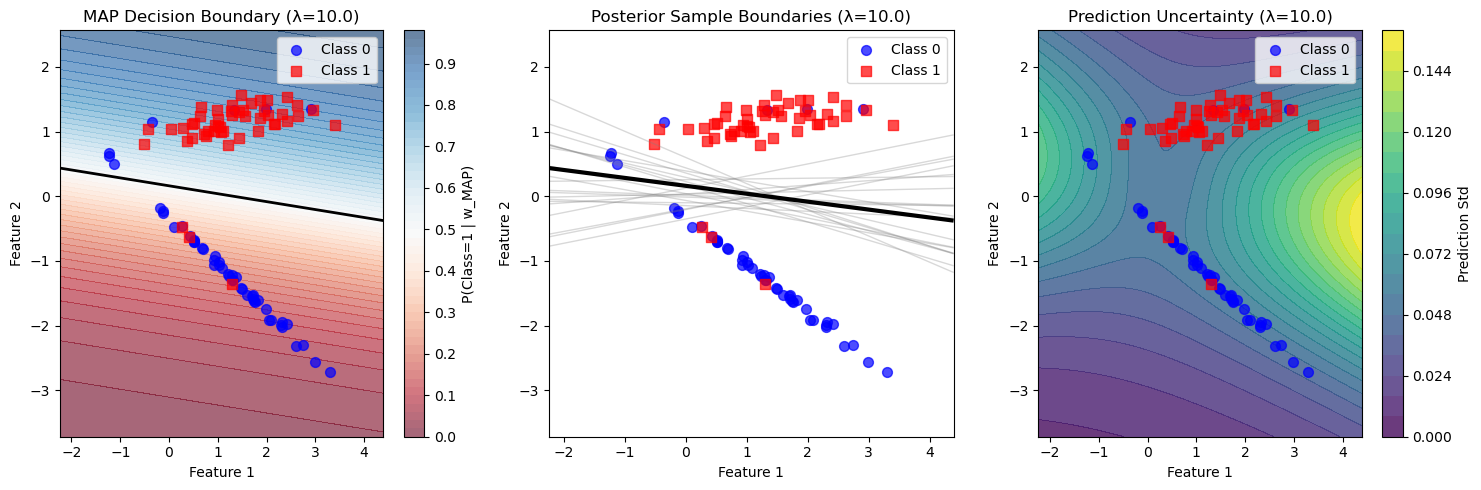

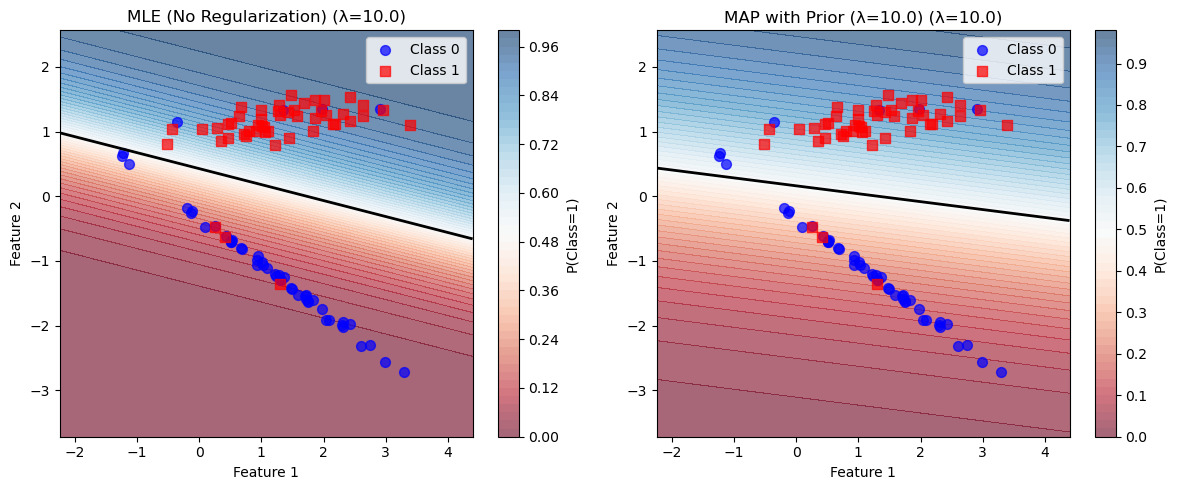


Weight Comparison (λ = 10.0):
MLE weights: [-0.91790675  0.52985537  2.14436686]
MAP weights: [-0.19338814  0.14586159  1.19133136]
Difference:  [ 0.72451861 -0.38399378 -0.9530355 ]
||w_MAP||:  1.2157
||w_MLE||:  2.3920

Data size: n = 20
Prior: p(w) = N(0, 1.0I)
------------------------------
w_MAP = [-0.49157123  0.40880138  1.52255529]
Posterior std = [0.62914136 0.50963324 0.50826225]
Total uncertainty = 1.6470


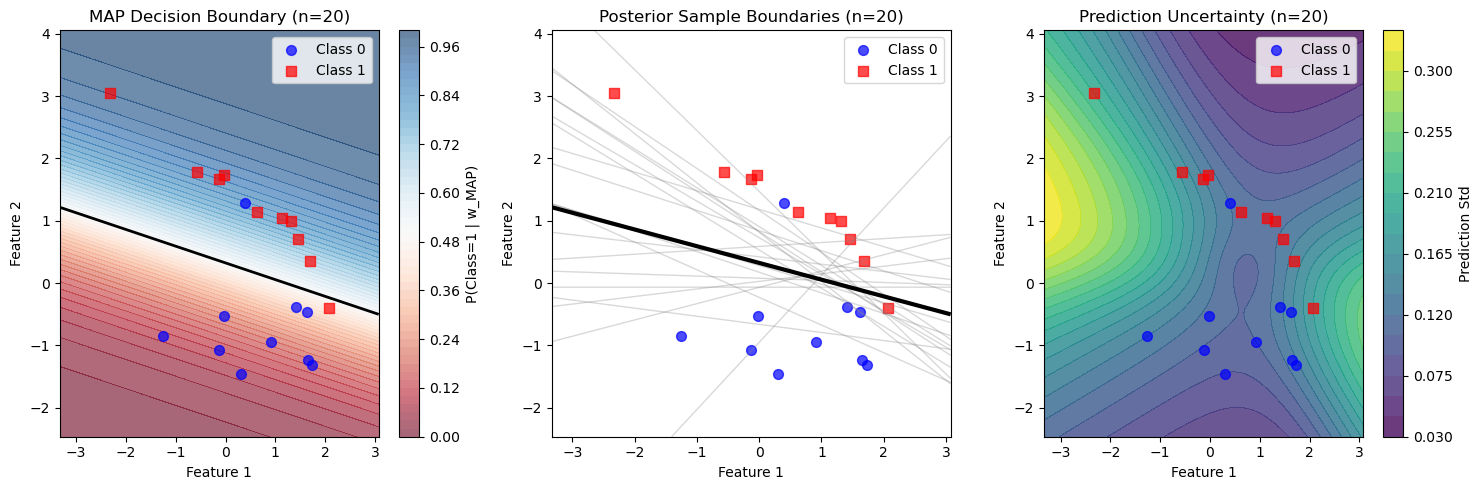


Data size: n = 100
Prior: p(w) = N(0, 1.0I)
------------------------------
w_MAP = [-1.11947062  0.94919747  2.20003678]
Posterior std = [0.51802641 0.33110625 0.34315394]
Total uncertainty = 1.1923


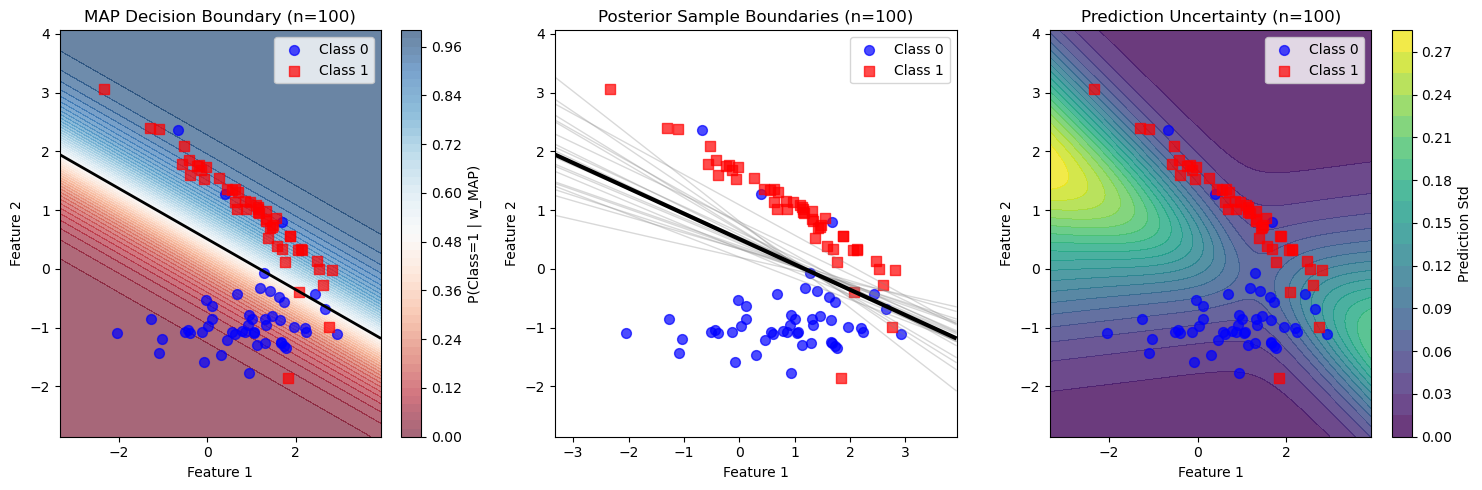


Data size: n = 500
Prior: p(w) = N(0, 1.0I)
------------------------------
w_MAP = [-1.61861209  1.24701935  3.39923856]
Posterior std = [0.39504593 0.21506882 0.26681473]
Total uncertainty = 0.8769


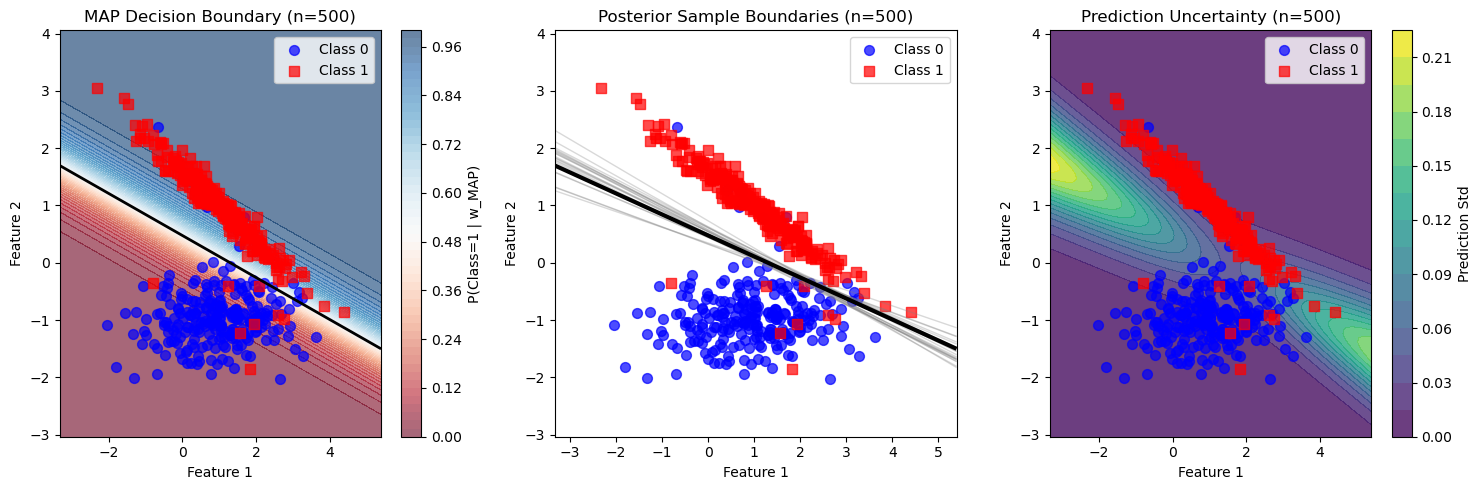

In [35]:
if __name__ == "__main__":
    logistic_regression_probabilistic()
    demonstrate_data_size_effect()

## **Part B.3**: Multiclass Logistic Regression

In [36]:
class BayesianMulticlassLogisticRegression:
    """
    Here also the posterior is intractable, so we do a monte carlo sampling for the posterior extraction
    """
    def __init__(self, n_classes = 3, prior_mean = None, prior_cov = None):
        self.n_classes = n_classes
        self.prior_mean = prior_mean
        self.prior_cov = prior_cov
        self.prior_precision = None
        
        self.map_estimate = None
        self.posterior_cov = None
        
        self.X = None
        self.y = None
        self.Y_one_hot = None
        
        self.true_weights = None
        
    def one_hot_encode(self, y):
        n_samples = len(y)
        Y_one_hot = np.zeros((n_samples, self.n_classes))
        Y_one_hot[np.arange(n_samples), y.astype(int)] = 1
        
        return Y_one_hot
    
    def generate_data(self, n_samples, n_features = 2, class_sep = 0.1, seed = None):
        if seed is not None:
            np.random.seed(seed)
            
        X_raw, y = make_classification(
            n_samples=n_samples,
            n_features=n_features,
            n_informative=n_features,
            n_redundant=0,
            n_clusters_per_class=1,
            n_classes=self.n_classes,
            class_sep=class_sep,
            random_state=seed
        )
        
        X = np.column_stack([np.ones(n_samples), X_raw])
        self.X = X
        self.y = y
        self.Y_one_hot = self.one_hot_encode(y)
        
        self.true_weights = np.random.normal(0, 1, (self.n_classes, X.shape[1]))
        
        return X, y
    
    def set_prior(self, prior_mean = None, prior_cov = None):
        if self.X is None:
            raise ValueError("Data not generated yet")
        
        n_features = self.X.shape[1]
        n_params = self.n_classes * n_features
        
        if prior_mean is not None:
            self.prior_mean = np.array(prior_mean).flatten()
        elif self.prior_mean is None:
            self.prior_mean = np.zeros(n_params)
            
        if prior_cov is not None:
            self.prior_cov = np.array(prior_cov)
        elif self.prior_cov is None:
            self.prior_cov = np.eye(n_params) * 10.0
            
        self.prior_precision = np.linalg.inv(self.prior_cov)
        
    def neg_log_posterior(self, w_vec):
        W = w_vec.reshape(self.n_classes, -1)
        logits = self.X @ W.T
        
        logits_max = np.max(logits, axis=1, keepdims=True)
        logits_stable = logits - logits_max
        log_sum_exp = np.log(np.sum(np.exp(logits_stable), axis=1, keepdims=True))
        log_softmax = logits_stable - log_sum_exp

        log_likelihood = np.sum(log_softmax * self.Y_one_hot)
        
        diff = w_vec - self.prior_mean
        log_prior = -0.5 * diff.T @ self.prior_precision @ diff

        return -(log_likelihood + log_prior)
    
    def neg_log_posterior_grad(self, w_vec):
        W = w_vec.reshape(self.n_classes, -1)
        logits = self.X @ W.T
        
        softmax_probs = softmax(logits, axis=1)
        grad_likelihood = self.X.T @ (self.Y_one_hot - softmax_probs)
        grad_likelihood = grad_likelihood.T.flatten()

        grad_prior = -self.prior_precision @ (w_vec - self.prior_mean)

        return -(grad_likelihood + grad_prior)
    
    def fit_laplace_approximation(self, maxiter=200, method='L-BFGS-B'):
        if self.X is None or self.y is None:
            raise ValueError("No data to fit on")
            
        self.set_prior()
        
        result = minimize(
            fun=self.neg_log_posterior,             
            x0=self.prior_mean,                     
            jac=self.neg_log_posterior_grad,        
            method=method,                          
            options={'maxiter': maxiter, 'disp': False}
        )
        
        if not result.success:
            print(f"Warning: MAP optimization did not converge: {result.message}")
            
        self.map_estimate = result.x  
        self.posterior_cov = np.linalg.inv(self.prior_precision + 
                                          1e-6 * np.eye(len(self.prior_mean)))
        
        return self.map_estimate, self.posterior_cov
    
    def get_estimates(self):
        if self.X is None or self.y is None:
            raise ValueError("No data available")
            
        clf = LogisticRegression(fit_intercept=False, solver='lbfgs', max_iter=1000, 
                               multi_class='ovr')
        clf.fit(self.X, self.y)
        mle_weights = clf.coef_.flatten()  
        
        map_weights = self.map_estimate
        
        return {
            'MLE': mle_weights,
            'MAP': map_weights,
            'True_Weights': self.true_weights.flatten() if self.true_weights is not None else None
        }
        
    def sample_posterior(self, n_samples=1000):
        """
        p(W|D) ≈ N(W_MAP, Λ^(-1))
        """
        if self.map_estimate is None or self.posterior_cov is None:
            raise ValueError("Laplace approximation not computed yet")
            
        return np.random.multivariate_normal(self.map_estimate, self.posterior_cov, n_samples)
        
    def predict_proba(self, X_new, use_samples=False, n_samples=100):
        if use_samples:
            weight_samples = self.sample_posterior(n_samples)
            probas = []
            for w_sample in weight_samples:
                W_sample = w_sample.reshape(self.n_classes, -1)  
                logits = X_new @ W_sample.T                      
                probs = softmax(logits, axis=1)                  
                probas.append(probs)
            return np.array(probas)  
        else:
            W = self.map_estimate.reshape(self.n_classes, -1)
            logits = X_new @ W.T
            return softmax(logits, axis=1)
        
    def predict(self, X_new, use_samples=False, n_samples=100):
        probs = self.predict_proba(X_new, use_samples, n_samples)
        if use_samples:
            return np.argmax(np.mean(probs, axis=0), axis=1)
        else:
            return np.argmax(probs, axis=1)

In [37]:
def plot_classification_boundaries_with_uncertainty(estimator, n_grid=50, n_samples=50, title_suffix=""):
    if estimator.X is None or estimator.y is None:
        raise ValueError("No data to plot")
        
    x1_min, x1_max = estimator.X[:, 1].min() - 1, estimator.X[:, 1].max() + 1
    x2_min, x2_max = estimator.X[:, 2].min() - 1, estimator.X[:, 2].max() + 1
    
    xx1, xx2 = np.meshgrid(
        np.linspace(x1_min, x1_max, n_grid),
        np.linspace(x2_min, x2_max, n_grid)
    )
    
    grid_points = np.column_stack([
        np.ones(xx1.ravel().shape[0]),  
        xx1.ravel(),
        xx2.ravel()
    ])
    
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 3, 1)
    
    proba_map = estimator.predict_proba(grid_points, use_samples=False)
    pred_map = np.argmax(proba_map, axis=1).reshape(xx1.shape)
    
    plt.contourf(xx1, xx2, pred_map, levels=np.arange(estimator.n_classes + 1) - 0.5, 
                 cmap='viridis', alpha=0.6)
    
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    for k in range(estimator.n_classes):
        mask = estimator.y == k
        plt.scatter(estimator.X[mask, 1], estimator.X[mask, 2], 
                   c=colors[k], marker='o', s=50, alpha=0.8, 
                   label=f'Class {k}', edgecolor='black', linewidth=0.5)
    
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(f'MAP Classification Boundaries {title_suffix}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    for k in range(estimator.n_classes):
        plt.subplot(2, 3, k + 2)
        
        Z_k = proba_map[:, k].reshape(xx1.shape)
        plt.contourf(xx1, xx2, Z_k, levels=20, cmap='Blues', alpha=0.8)
        plt.colorbar(label=f'P(Class {k})')
        
        for j in range(estimator.n_classes):
            mask = estimator.y == j
            alpha = 1.0 if j == k else 0.3
            plt.scatter(estimator.X[mask, 1], estimator.X[mask, 2], 
                       c=colors[j], marker='o', s=30, alpha=alpha,
                       edgecolor='black', linewidth=0.5)
        
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.title(f'P(Class {k}) {title_suffix}')
        plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 3, 5)
    
    probas_samples = estimator.predict_proba(grid_points, use_samples=True, n_samples=n_samples)
    proba_mean = np.mean(probas_samples, axis=0)
    
    entropy = -np.sum(proba_mean * np.log(proba_mean + 1e-12), axis=1)
    Z_entropy = entropy.reshape(xx1.shape)
    
    plt.contourf(xx1, xx2, Z_entropy, levels=20, cmap='Reds', alpha=0.8)
    plt.colorbar(label='Prediction Entropy')
    
    for k in range(estimator.n_classes):
        mask = estimator.y == k
        plt.scatter(estimator.X[mask, 1], estimator.X[mask, 2], 
                   c=colors[k], marker='o', s=50, alpha=0.8,
                   edgecolor='black', linewidth=0.5)
    
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(f'Prediction Uncertainty {title_suffix}')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 3, 6)
    
    weight_samples = estimator.sample_posterior(min(20, n_samples))
    
    for i, w_sample in enumerate(weight_samples):
        W_sample = w_sample.reshape(estimator.n_classes, -1)
        logits_sample = grid_points @ W_sample.T
        pred_sample = np.argmax(logits_sample, axis=1).reshape(xx1.shape)
        
        plt.contour(xx1, xx2, pred_sample, 
                   levels=np.arange(estimator.n_classes + 1) - 0.5,
                   colors='gray', alpha=0.2, linewidths=0.5)
    
    plt.contour(xx1, xx2, pred_map, 
               levels=np.arange(estimator.n_classes + 1) - 0.5,
               colors='black', linewidths=2)
    
    for k in range(estimator.n_classes):
        mask = estimator.y == k
        plt.scatter(estimator.X[mask, 1], estimator.X[mask, 2], 
                   c=colors[k], marker='o', s=50, alpha=0.8,
                   edgecolor='black', linewidth=0.5)
    
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(f'Posterior Sample Boundaries {title_suffix}')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [38]:
def compare_with_mle_multiclass(estimator, title_suffix=""):
    if estimator.X is None or estimator.y is None:
        raise ValueError("No data to compare")
        
    x1_min, x1_max = estimator.X[:, 1].min() - 1, estimator.X[:, 1].max() + 1
    x2_min, x2_max = estimator.X[:, 2].min() - 1, estimator.X[:, 2].max() + 1
    
    xx1, xx2 = np.meshgrid(
        np.linspace(x1_min, x1_max, 100),
        np.linspace(x2_min, x2_max, 100)
    )
    
    grid_points = np.column_stack([
        np.ones(xx1.ravel().shape[0]),
        xx1.ravel(),
        xx2.ravel()
    ])
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    
    clf = LogisticRegression(fit_intercept=False, solver='lbfgs', max_iter=1000, 
                           multi_class='ovr')
    clf.fit(estimator.X, estimator.y)
    Z_mle = clf.predict(grid_points).reshape(xx1.shape)
    
    plt.contourf(xx1, xx2, Z_mle, levels=np.arange(estimator.n_classes + 1) - 0.5, 
                 cmap='viridis', alpha=0.6)
    
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    for k in range(estimator.n_classes):
        mask = estimator.y == k
        plt.scatter(estimator.X[mask, 1], estimator.X[mask, 2], 
                   c=colors[k], marker='o', s=50, alpha=0.8, 
                   label=f'Class {k}', edgecolor='black', linewidth=0.5)
    
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(f'MLE (Standard Multiclass) {title_suffix}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    
    Z_map = estimator.predict(grid_points, use_samples=False).reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z_map, levels=np.arange(estimator.n_classes + 1) - 0.5, 
                 cmap='viridis', alpha=0.6)
    
    for k in range(estimator.n_classes):
        mask = estimator.y == k
        plt.scatter(estimator.X[mask, 1], estimator.X[mask, 2], 
                   c=colors[k], marker='o', s=50, alpha=0.8, 
                   label=f'Class {k}', edgecolor='black', linewidth=0.5)
    
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(f'Bayesian MAP (Laplace Approximation) {title_suffix}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    estimates = estimator.get_estimates()
    print("\nWeight Comparison:")
    print(f"Number of parameters: {len(estimates['MAP'])}")
    print(f"Max absolute difference: {np.max(np.abs(estimates['MAP'] - estimates['MLE'])):.6f}")

In [39]:
def demonstrate_posterior_predictive(estimator, n_test=5):
    if estimator.X is None or estimator.y is None:
        raise ValueError("No data available")
        
    print("\n=== Posterior Predictive Probabilities ===")
    print("=" * 50)
    
    np.random.seed(123)
    x1_range = [estimator.X[:, 1].min(), estimator.X[:, 1].max()]
    x2_range = [estimator.X[:, 2].min(), estimator.X[:, 2].max()]
    
    test_x1 = np.random.uniform(x1_range[0], x1_range[1], n_test)
    test_x2 = np.random.uniform(x2_range[0], x2_range[1], n_test)
    X_test = np.column_stack([np.ones(n_test), test_x1, test_x2])
    
    proba_map = estimator.predict_proba(X_test, use_samples=False)
    pred_map = estimator.predict(X_test, use_samples=False)
    
    probas_samples = estimator.predict_proba(X_test, use_samples=True, n_samples=100)
    proba_mean = np.mean(probas_samples, axis=0)
    proba_std = np.std(probas_samples, axis=0)
    
    print("Test Point Predictions:")
    print("-" * 25)
    
    for i in range(n_test):
        print(f"\nTest Point {i+1}: ({test_x1[i]:.2f}, {test_x2[i]:.2f})")
        print(f"MAP Prediction: Class {pred_map[i]}")
        print(f"MAP Probabilities: {proba_map[i]}")
        print(f"Posterior Mean Probabilities: {proba_mean[i]}")
        print(f"Posterior Std Probabilities:  {proba_std[i]}")
        
        entropy = -np.sum(proba_mean[i] * np.log(proba_mean[i] + 1e-12))
        print(f"Prediction Entropy: {entropy:.3f}")

In [40]:
def demonstrate_prior_effect_multiclass():
    print("Analysing different Priors\n")
    
    estimator_base = BayesianMulticlassLogisticRegression(n_classes=3)
    X, y = estimator_base.generate_data(n_samples=150, class_sep=0.8, seed=42)
    
    n_params = 3 * X.shape[1]
    priors = [
        (np.zeros(n_params), np.eye(n_params) * 100.0, "Uninformative"),
        (np.zeros(n_params), np.eye(n_params) * 1.0, "Moderate"),
        (np.zeros(n_params), np.eye(n_params) * 0.1, "Strong")
    ]
    
    for prior_mean, prior_cov, prior_name in priors:
        print(f"\n{prior_name}")
        tau = 1.0 / prior_cov[0,0]
        print(f"Prior precision τ = {tau:.2f}")
        
        estimator = BayesianMulticlassLogisticRegression(n_classes=3, 
                                                         prior_mean=prior_mean, 
                                                         prior_cov=prior_cov)
        estimator.X = X
        estimator.y = y
        estimator.Y_one_hot = estimator.one_hot_encode(y)
        estimator.fit_laplace_approximation()
        
        print(f"||W_MAP|| = {np.linalg.norm(estimator.map_estimate):.4f}")
        
        plot_classification_boundaries_with_uncertainty(estimator, 
                                                        title_suffix=f"- {prior_name}")

In [41]:
def demonstrate_bayesian_multiclass_logistic():
    estimator = BayesianMulticlassLogisticRegression(n_classes=3)
    X, y = estimator.generate_data(n_samples=200, class_sep=1.0, seed=42)
    
    n_params = estimator.n_classes * X.shape[1]
    estimator.set_prior(
        prior_mean=np.zeros(n_params),
        prior_cov=np.eye(n_params) * 5.0  
    )
    
    estimator.fit_laplace_approximation()
    
    print("\nMain Results:")
    estimates = estimator.get_estimates()
    print(f"Number of parameters: {len(estimates['MAP'])}")
    print(f"||W_MAP|| = {np.linalg.norm(estimates['MAP']):.4f}")
    print(f"||W_MLE|| = {np.linalg.norm(estimates['MLE']):.4f}")
    
    pred_map = estimator.predict(estimator.X, use_samples=False)
    accuracy = np.mean(pred_map == estimator.y)
    print(f"Training accuracy (MAP): {accuracy:.3f}")
    
    plot_classification_boundaries_with_uncertainty(estimator, 
                                                    title_suffix="- Main Demo")
    compare_with_mle_multiclass(estimator, title_suffix="- Main Demo")
    
    demonstrate_posterior_predictive(estimator)
    
    demonstrate_prior_effect_multiclass()


Main Results:
Number of parameters: 9
||W_MAP|| = 2.6885
||W_MLE|| = 3.9698
Training accuracy (MAP): 0.805


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


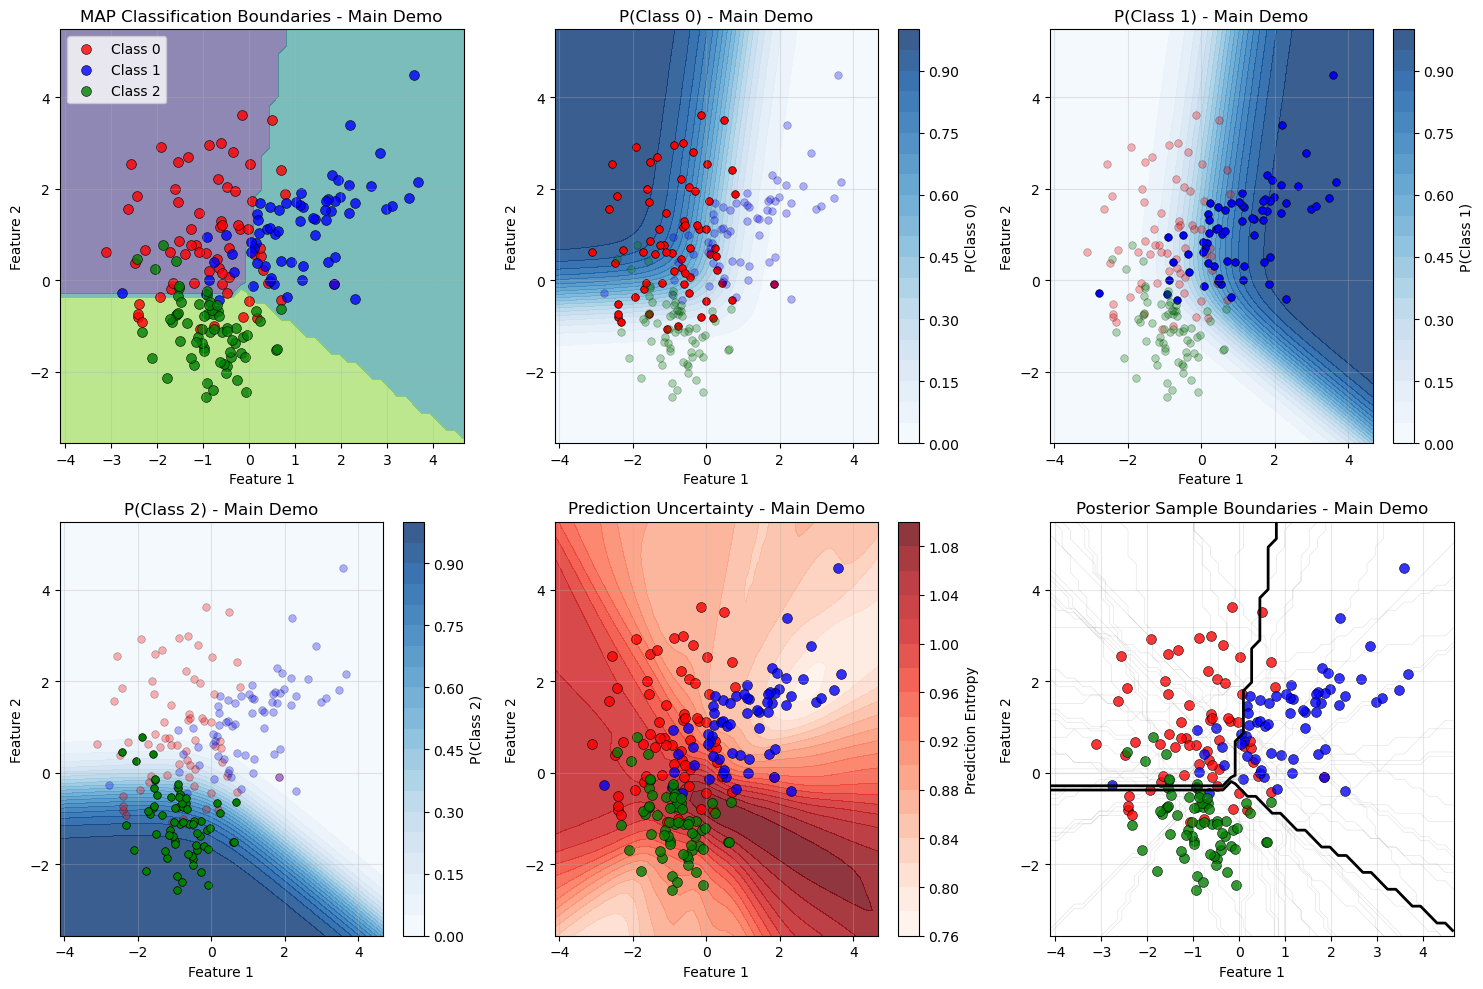

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


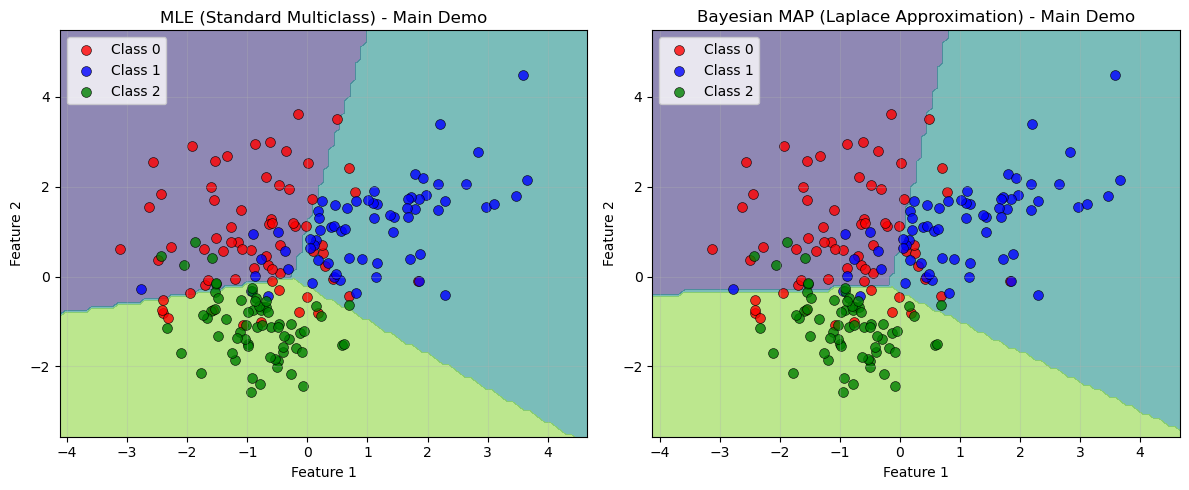

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(



Weight Comparison:
Number of parameters: 9
Max absolute difference: 1.598105

=== Posterior Predictive Probabilities ===
Test Point Predictions:
-------------------------

Test Point 1: (1.60, 0.42)
MAP Prediction: Class 1
MAP Probabilities: [0.04929837 0.94144054 0.0092611 ]
Posterior Mean Probabilities: [0.23167092 0.67073249 0.09759659]
Posterior Std Probabilities:  [0.34592175 0.39797666 0.24651307]
Prediction Entropy: 0.834

Test Point 2: (-1.18, 4.35)
MAP Prediction: Class 0
MAP Probabilities: [9.59868959e-01 4.01290363e-02 2.00429569e-06]
Posterior Mean Probabilities: [0.45337651 0.42527085 0.12135265]
Posterior Std Probabilities:  [0.45093868 0.45139807 0.29760837]
Prediction Entropy: 0.978

Test Point 3: (-1.58, 2.26)
MAP Prediction: Class 0
MAP Probabilities: [9.62240231e-01 3.70569902e-02 7.02778470e-04]
Posterior Mean Probabilities: [0.54090504 0.31354349 0.14555147]
Posterior Std Probabilities:  [0.43872567 0.40824789 0.30775357]
Prediction Entropy: 0.977

Test Point 4: (

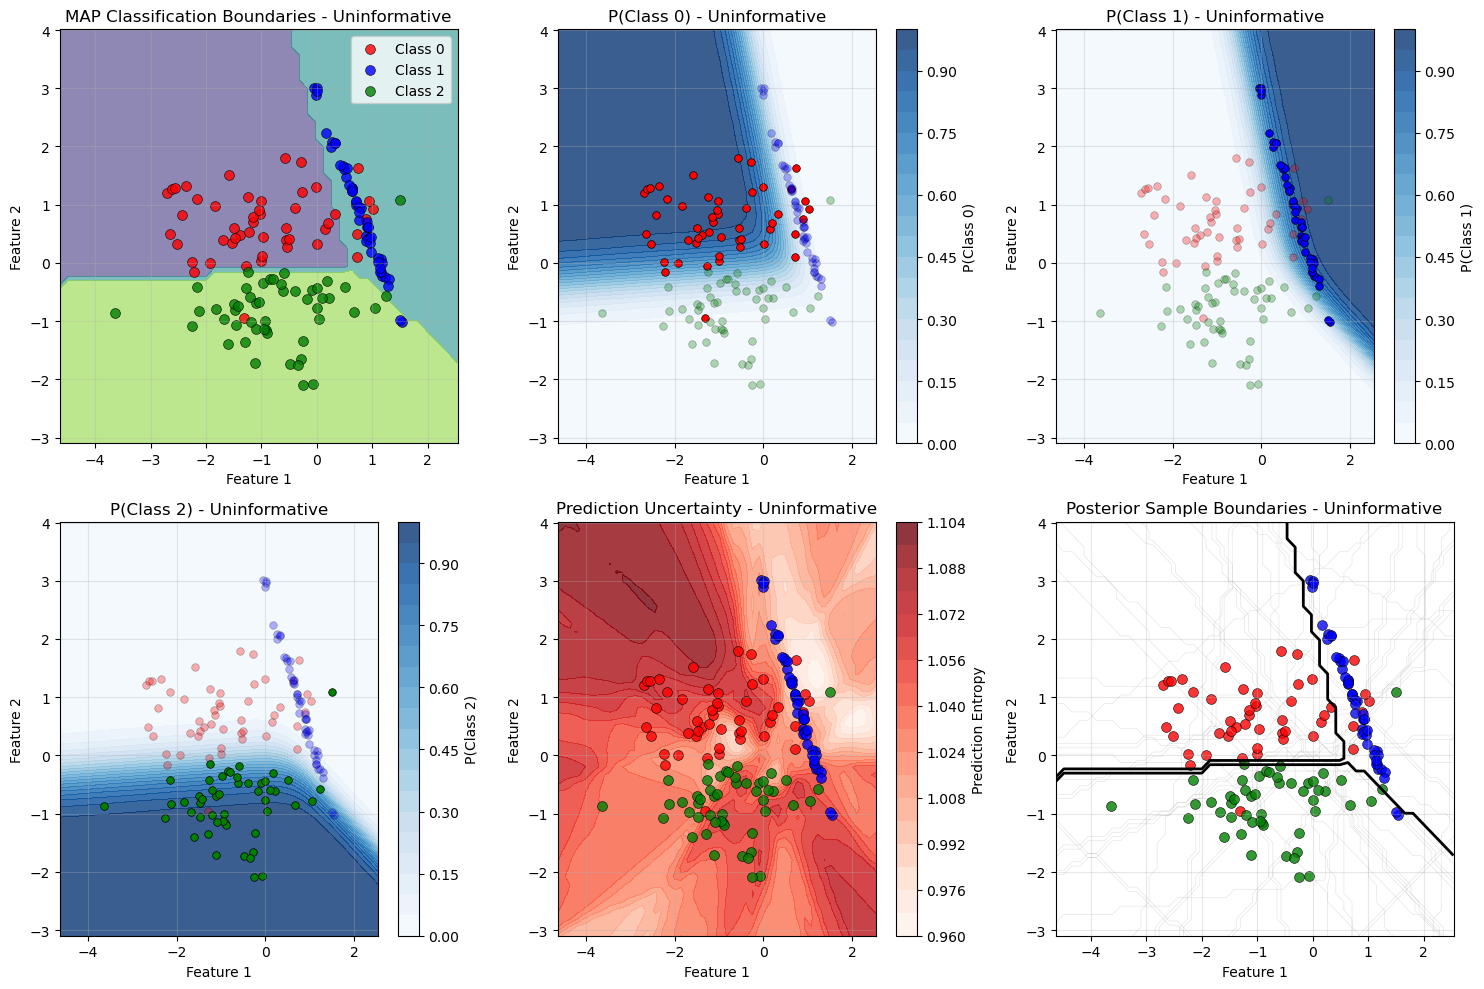


Moderate
Prior precision τ = 1.00
||W_MAP|| = 3.7182


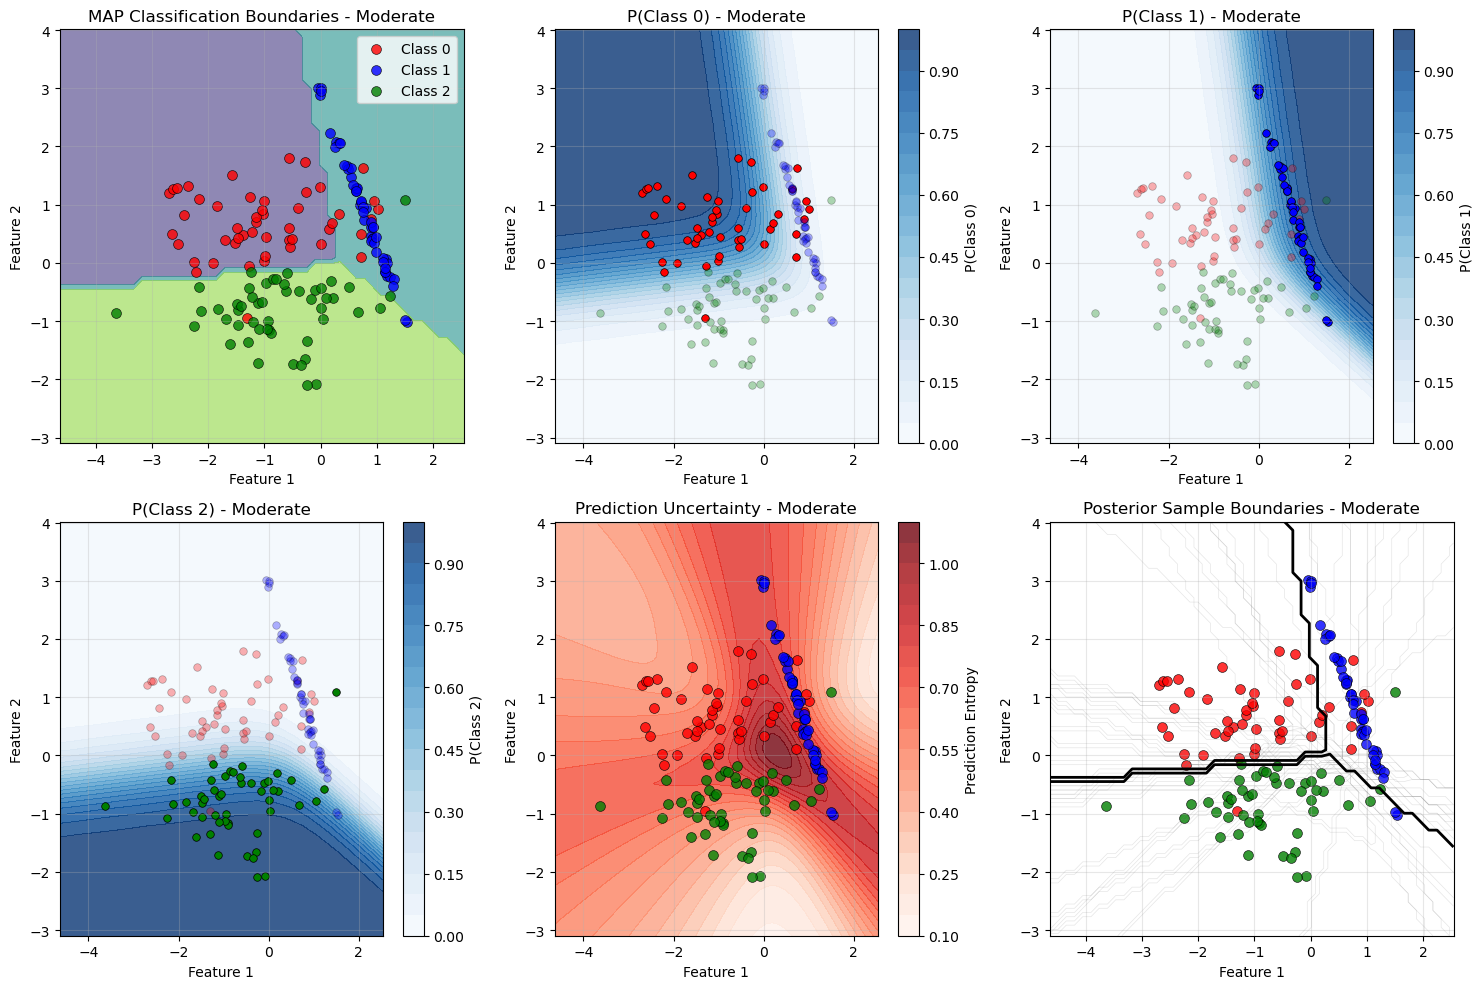


Strong
Prior precision τ = 10.00
||W_MAP|| = 1.8709


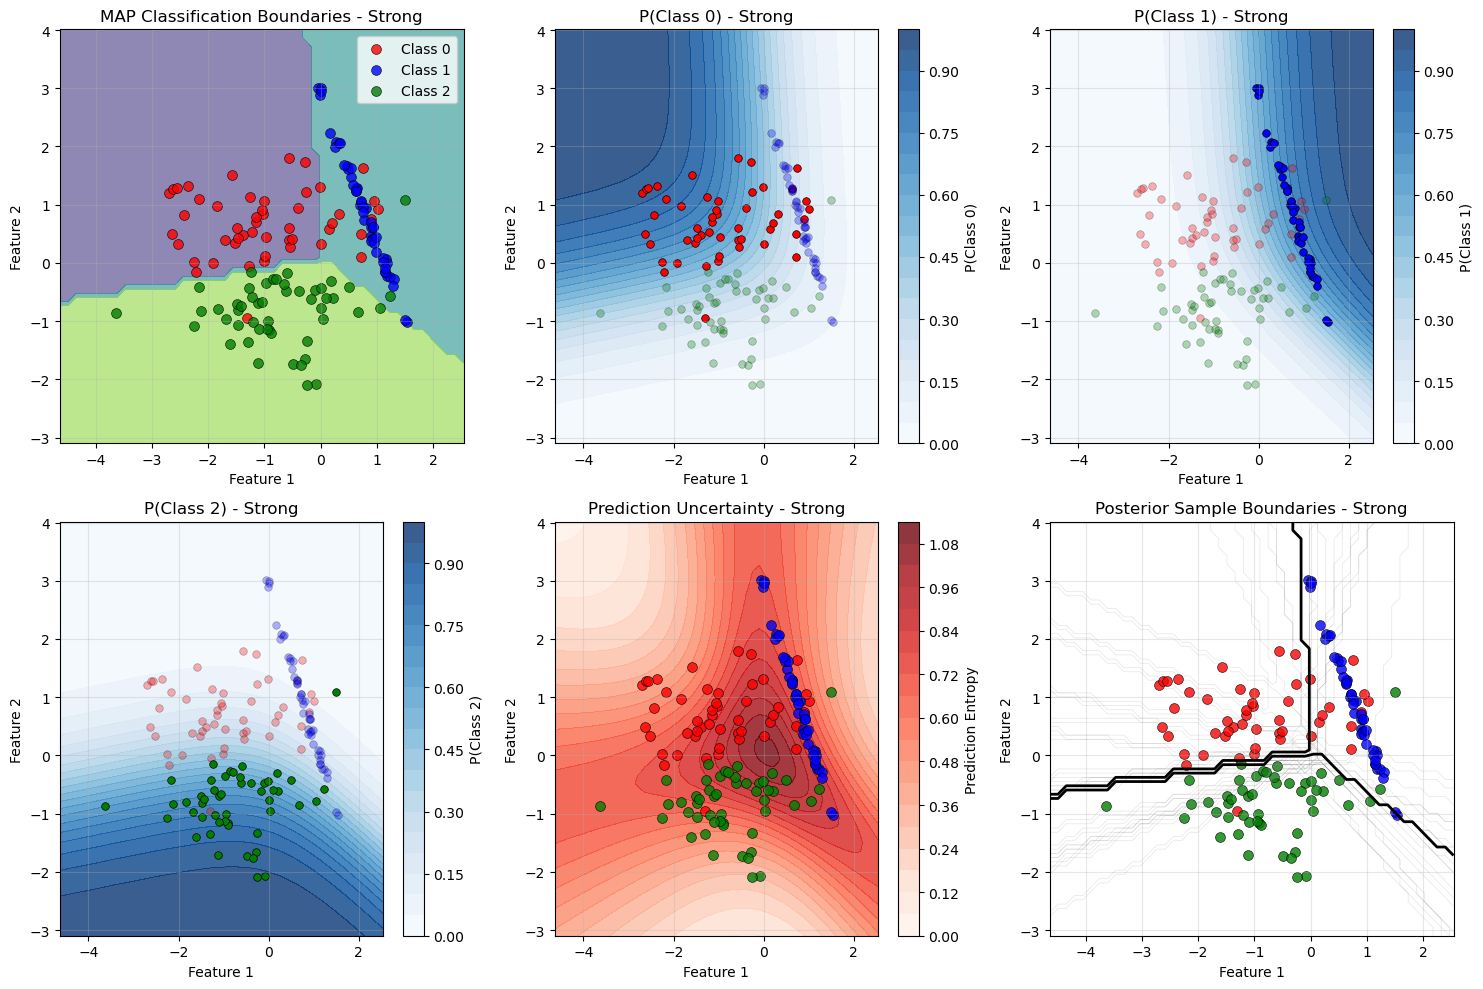

In [42]:
if __name__ == "__main__":
    demonstrate_bayesian_multiclass_logistic()